# This will be feature selection based on the paper by kniep HC in which they get tid off all those tumors which volume is less than 125 and select the 10 lasrgest metastsis per patient. I am going to go with 15 for now. The rest would be applying the same codes as before. Only the radiomic features of the 3 classes: Melanomma, Lung, Breast (0, 1, 2).

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, KFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
from collections import Counter
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as imbpipeline
from mrmr import mrmr_classif
from scipy import stats
from sklearn.feature_selection import f_classif
from sklearn.calibration import CalibratedClassifierCV

In [12]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, multi_class='ovr', average=average)

from sklearn.metrics import roc_auc_score

def class_vs_rest_roc_auc_score(y_test, y_pred):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test_bin = lb.transform(y_test)
    y_pred_bin = lb.transform(y_pred)
    roc_auc_scores = {}

    for i, class_label in enumerate(lb.classes_):
        class_indices = lb.transform([class_label])[0]
        rest_indices = ~class_indices
        y_test_class = y_test_bin[:, i]
        y_test_rest = y_test_bin[:, rest_indices]
        y_pred_class = y_pred_bin[:, i]
        y_pred_rest = y_pred_bin[:, rest_indices]
        roc_auc_scores[class_label] = roc_auc_score(y_test_class, y_pred_class, multi_class='ovr', average="macro")

    return roc_auc_scores

def calculate_specificity(cm):
    num_classes = cm.shape[0]
    specificity = {}

    for i in range(num_classes):
        tp = cm[i, i]
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp

        specificity[i] = 100*(tn / (tn + fp))

    return specificity

def calculate_sensitivity(cm):
    num_classes = cm.shape[0]
    sensitivity = {}

    for i in range(num_classes):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp

        sensitivity[i] = 100*(tp / (tp + fn))

    return sensitivity


def calculate_precision(cm):
    num_classes = cm.shape[0]
    precision = {}

    for i in range(num_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp

        precision[i] = 100*(tp / (tp + fp))

    return precision


def calculate_f1_score(cm):
    num_classes = cm.shape[0]
    f1_scores = {}

    for i in range(num_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_scores[i] = 2 * ((precision * recall) / (precision + recall)) * 100

    return f1_scores

def calculate_accuracy(cm):
    num_classes = cm.shape[0]
    accuracy = {}

    for i in range(num_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        tn = np.sum(cm) - tp - fp - fn

        accuracy[i] = 100 * ((tp + tn) / (tp + tn + fp + fn))

    return accuracy

In [13]:
df = pd.read_excel('all_patients.xlsx')
#df = df.set_index(['subjid'])
df = df.drop('number_annotations', axis = 1)
df = df[df.shape_VoxelVolume > 125]
df.drop(df[df['labels'] == 3].index, inplace = True) ## dropping label of the call OTHERS
df = df.set_index(['subjid', 'label'])
confidence = 0.95
seed = 0

In [14]:
# we select X and y
X = df.iloc[:, :-4] #leaving the sex and age features out for now
y = df.iloc[:, -1:]
print(Counter(y.values.ravel()))

Counter({1: 321, 2: 76, 0: 41})


There is an obvious inbalane of the labes wih a great majority coming from the lung. To counter attck this inbalance we eill make use of oversampling and undersapmling techniques that have proven to be useful in literature

## mRMR

In [19]:
pipelines = {
    'rf': imbpipeline([('smoteen', SMOTEENN(random_state=0)),
                       ('clf', RandomForestClassifier(random_state=0, class_weight="balanced"))]),
    'svc': imbpipeline([('smoteen', SMOTEENN(random_state=0)),
                        ('clf', CalibratedClassifierCV(LinearSVC(multi_class='ovr', random_state=0, class_weight="balanced")))])
    }

param_grids = {
    'rf': {'clf__n_estimators': [100, 250, 1000, 3500]},
    'svc': {'clf__base_estimator__C': [0.1, 1,10], 'clf__base_estimator__max_iter': [10000, 20000]}
}

cv_outer = RepeatedStratifiedKFold(n_splits=6, n_repeats=6, random_state=seed)

## f 5

In [12]:
# Store the scores and metrics
scores_rf = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
scores_svc = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI':[], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
best_features_RF = []
for name, pipeline in pipelines.items():
    # Initialize lists to store scores for each fold
    fold_acc = []
    fold_auc_tot = []
    fold_auc_class = []
    sensi = []
    speci = []
    features = []
    p_value = []
    feat = []
    value = []
    for train_index, test_index in cv_outer.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_normed = scaler.fit_transform(X_train)
        X_test_normed = scaler.transform(X_test)

        X_train_scal = pd.DataFrame(X_train_normed, columns=X_train.columns, index=X_train.index)
        X_test_scal = pd.DataFrame(X_test_normed, columns=X_test.columns, index=X_test.index)

        #select the best 15 features
        selected_feature_names = mrmr_classif(X_train_scal, y_train, K=5)
        X_train_new = X_train_scal[selected_feature_names]
        X_test_new = X_test_scal[selected_feature_names]
        f_scores, p_values = f_classif(X_train_new, y_train)
        feature_p_values = dict(zip(selected_feature_names, p_values))
        p_value.append(feature_p_values)

        cv_inner = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=seed)
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_inner, scoring='roc_auc_ovr', error_score="raise")
        grid_search.fit(X_train_new, y_train)
        clf = grid_search.best_estimator_
        print(clf)
        clf.fit(X_train_new, y_train)
        y_pred = clf.predict(X_test_new)
        accuracy = accuracy_score(y_test, y_pred)
        num_classes = len(np.unique(y_test))
        cm = confusion_matrix(y_test, y_pred)
        specificity = calculate_specificity(cm)
        sensitivity = calculate_sensitivity(cm)
        # Print the results

        accuracy = accuracy_score(y_test, y_pred)
        fold_acc.append(accuracy)

        # Calculate AUC score
        auc_tot = multiclass_roc_auc_score(y_test, y_pred)
        fold_auc_tot.append(auc_tot)

        auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
        fold_auc_class.append(auc_class)

        speci.append(specificity)
        sensi.append(sensitivity)

        print('Auc Score', multiclass_roc_auc_score(y_test, y_pred))
        print('Auc Score OvR', class_vs_rest_roc_auc_score(y_test, y_pred))

        if name == 'rf':
            params_rf = grid_search.best_estimator_
            feature_importance = clf.named_steps['clf'].feature_importances_
            for featureses, importance in zip(selected_feature_names, feature_importance):
                best_features_RF.append((featureses, importance))
        else:
            continue
    # Calculate average scores across folds
    if name == 'rf':
        #acc
        avg_acc = np.mean(fold_acc)
        scores_rf['acc'].append(avg_acc)
        scores_rf['acc'] = scores_rf['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_rf['CI_acc'].append(ci)
        scores_rf['SD_acc'].append(np.std(fold_acc))

        #auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_rf['auc_tot'].append(avg_auc_tot)
        scores_rf['auc_tot'] = scores_rf['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_rf['CI_auc_tot'].append(ci)
        scores_rf['SD_auc_tot'].append(np.std(fold_acc))

        #auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['CI_auc_class'].append(CI_auc_class)

        #sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Sen_CI'].append(CI_sen_class)

        #specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Spe_mean'].append(avg_speci_class)
        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Spe_CI'].append(CI_spe_class)

    elif name == 'svc':
        # acc
        avg_acc = np.mean(fold_acc)
        scores_svc['acc'].append(avg_acc)
        scores_svc['acc'] = scores_svc['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_svc['CI_acc'].append(ci)
        scores_svc['SD_acc'].append(np.std(fold_acc))

        # auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_svc['auc_tot'].append(avg_auc_tot)
        scores_svc['auc_tot'] = scores_svc['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_svc['CI_auc_tot'].append(ci)
        scores_svc['SD_auc_tot'].append(np.std(fold_acc))

        # auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['CI_auc_class'].append(CI_auc_class)

        # sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Sen_CI'].append(CI_sen_class)

        # specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Spe_mean'].append(avg_speci_class)

        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Spe_CI'].append(CI_spe_class)


100%|██████████| 5/5 [00:00<00:00,  5.59it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7023025148564407
Auc Score OvR {0: 0.7056277056277057, 1: 0.6403508771929824, 2: 0.7609289617486339}


100%|██████████| 5/5 [00:00<00:00,  9.33it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.5473781669496366
Auc Score OvR {0: 0.4913419913419913, 1: 0.4731968810916179, 2: 0.6775956284153005}


100%|██████████| 5/5 [00:00<00:00, 11.01it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.642527231678175
Auc Score OvR {0: 0.8636363636363636, 1: 0.5165094339622641, 2: 0.5474358974358975}


100%|██████████| 5/5 [00:00<00:00,  9.50it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5870078558757804
Auc Score OvR {0: 0.4761904761904762, 1: 0.5636792452830188, 2: 0.7211538461538461}


100%|██████████| 5/5 [00:00<00:00,  7.24it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5615825997901469
Auc Score OvR {0: 0.6417748917748918, 1: 0.4570754716981132, 2: 0.5858974358974358}


100%|██████████| 5/5 [00:00<00:00,  9.85it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.7790949100650592
Auc Score OvR {0: 0.8507462686567164, 1: 0.6666666666666666, 2: 0.8198717948717948}


100%|██████████| 5/5 [00:00<00:00,  9.17it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5434829380400276
Auc Score OvR {0: 0.4653679653679653, 1: 0.5209551656920078, 2: 0.6441256830601094}


100%|██████████| 5/5 [00:00<00:00, 10.47it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6856346446510381
Auc Score OvR {0: 0.724025974025974, 1: 0.6388888888888888, 2: 0.6939890710382514}


100%|██████████| 5/5 [00:00<00:00,  8.44it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5865533313646522
Auc Score OvR {0: 0.6006493506493507, 1: 0.5731132075471699, 2: 0.5858974358974358}


100%|██████████| 5/5 [00:00<00:00, 10.30it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6595924515735836
Auc Score OvR {0: 0.6493506493506493, 1: 0.619811320754717, 2: 0.7096153846153845}


100%|██████████| 5/5 [00:00<00:00,  9.90it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.7009061169438527
Auc Score OvR {0: 0.7359307359307359, 1: 0.635377358490566, 2: 0.7314102564102565}


100%|██████████| 5/5 [00:00<00:00,  9.99it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.5026467042505273
Auc Score OvR {0: 0.6243781094527363, 1: 0.4098440545808967, 2: 0.47371794871794876}


100%|██████████| 5/5 [00:00<00:00,  9.35it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.5654433525443016
Auc Score OvR {0: 0.5324675324675324, 1: 0.5614035087719298, 2: 0.6024590163934426}


100%|██████████| 5/5 [00:00<00:00,  9.87it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6755325797244117
Auc Score OvR {0: 0.6569264069264069, 1: 0.6340155945419103, 2: 0.7356557377049181}


100%|██████████| 5/5 [00:00<00:00,  9.77it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5503726357499943
Auc Score OvR {0: 0.4761904761904762, 1: 0.5537735849056604, 2: 0.6211538461538462}


100%|██████████| 5/5 [00:00<00:00, 10.45it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.5548094986774234
Auc Score OvR {0: 0.6417748917748918, 1: 0.46367924528301885, 2: 0.5589743589743591}


100%|██████████| 5/5 [00:00<00:00, 10.82it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.760199705954423
Auc Score OvR {0: 0.7813852813852814, 1: 0.6825471698113207, 2: 0.8166666666666667}


100%|██████████| 5/5 [00:00<00:00, 10.28it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.5689781524227715
Auc Score OvR {0: 0.49502487562189057, 1: 0.5394736842105263, 2: 0.6724358974358975}


100%|██████████| 5/5 [00:00<00:00,  9.56it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6647839931561531
Auc Score OvR {0: 0.6158008658008658, 1: 0.6340155945419103, 2: 0.7445355191256832}


100%|██████████| 5/5 [00:00<00:00,  9.95it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6576557237328017
Auc Score OvR {0: 0.6417748917748918, 1: 0.5784600389863548, 2: 0.7527322404371586}


100%|██████████| 5/5 [00:00<00:00, 10.73it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.5809581403921027
Auc Score OvR {0: 0.6190476190476191, 1: 0.4693396226415094, 2: 0.6544871794871795}


100%|██████████| 5/5 [00:00<00:00, 10.46it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6248154361361908
Auc Score OvR {0: 0.6266233766233766, 1: 0.5632075471698114, 2: 0.6846153846153846}


100%|██████████| 5/5 [00:00<00:00, 10.08it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7725496201911296
Auc Score OvR {0: 0.7662337662337663, 1: 0.7014150943396226, 2: 0.85}


100%|██████████| 5/5 [00:00<00:00,  9.24it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.5032808293216777
Auc Score OvR {0: 0.585820895522388, 1: 0.40350877192982454, 2: 0.5205128205128206}


100%|██████████| 5/5 [00:00<00:00, 10.08it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6534740664378283
Auc Score OvR {0: 0.6677489177489178, 1: 0.6403508771929824, 2: 0.6523224043715847}


100%|██████████| 5/5 [00:00<00:00, 10.60it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6425654749281439
Auc Score OvR {0: 0.5627705627705628, 1: 0.6033138401559455, 2: 0.7616120218579234}


100%|██████████| 5/5 [00:00<00:00, 10.45it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.61097162795276
Auc Score OvR {0: 0.672077922077922, 1: 0.5448113207547169, 2: 0.6160256410256411}


100%|██████████| 5/5 [00:00<00:00,  9.98it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5861280752790187
Auc Score OvR {0: 0.682900432900433, 1: 0.5665094339622642, 2: 0.5089743589743589}


100%|██████████| 5/5 [00:00<00:00, 10.62it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6519661680039038
Auc Score OvR {0: 0.6006493506493507, 1: 0.5853773584905659, 2: 0.7698717948717949}


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6609462620918499
Auc Score OvR {0: 0.6840796019900497, 1: 0.550682261208577, 2: 0.7480769230769232}


100%|██████████| 5/5 [00:00<00:00,  9.29it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5604922431928472
Auc Score OvR {0: 0.5064935064935064, 1: 0.564327485380117, 2: 0.6106557377049181}


100%|██████████| 5/5 [00:00<00:00,  9.58it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6137830016892427
Auc Score OvR {0: 0.5887445887445888, 1: 0.5258284600389864, 2: 0.7267759562841529}


100%|██████████| 5/5 [00:00<00:00,  8.62it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.5925665529439114
Auc Score OvR {0: 0.682900432900433, 1: 0.45377358490566033, 2: 0.6410256410256411}


100%|██████████| 5/5 [00:00<00:00,  9.82it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6579284970794405
Auc Score OvR {0: 0.6341991341991342, 1: 0.5915094339622642, 2: 0.7480769230769232}


100%|██████████| 5/5 [00:00<00:00,  9.69it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5686478615723898
Auc Score OvR {0: 0.6158008658008658, 1: 0.5292452830188679, 2: 0.5608974358974358}


100%|██████████| 5/5 [00:00<00:00,  9.05it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.5513362114304768
Auc Score OvR {0: 0.5634328358208955, 1: 0.45467836257309935, 2: 0.6358974358974359}


100%|██████████| 5/5 [00:00<00:00,  9.22it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6110808843049281
Auc Score OvR {0: 0.645021645021645, 1: 0.5092592592592593, 2: 0.6789617486338799}


100%|██████████| 5/5 [00:00<00:00, 10.06it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=10,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6446832362132909
Auc Score OvR {0: 0.670995670995671, 1: 0.5185185185185185, 2: 0.7445355191256832}


100%|██████████| 5/5 [00:00<00:00,  8.52it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.622066926783908
Auc Score OvR {0: 0.6677489177489178, 1: 0.5471698113207547, 2: 0.6512820512820513}


100%|██████████| 5/5 [00:00<00:00,  7.57it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5875901875901876
Auc Score OvR {0: 0.47943722943722944, 1: 0.5, 2: 0.7833333333333333}


100%|██████████| 5/5 [00:00<00:00,  9.01it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5840177118479005
Auc Score OvR {0: 0.6525974025974026, 1: 0.47830188679245284, 2: 0.6211538461538462}


100%|██████████| 5/5 [00:00<00:00,  9.45it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6764415103967343
Auc Score OvR {0: 0.7761194029850746, 1: 0.5, 2: 0.7532051282051281}


100%|██████████| 5/5 [00:00<00:00, 10.06it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6007462735604813
Auc Score OvR {0: 0.5887445887445888, 1: 0.5092592592592593, 2: 0.7042349726775956}


100%|██████████| 5/5 [00:00<00:00, 10.45it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6180875893990648
Auc Score OvR {0: 0.6406926406926406, 1: 0.5277777777777778, 2: 0.6857923497267759}


100%|██████████| 5/5 [00:00<00:00, 10.05it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5536186036186036
Auc Score OvR {0: 0.6634199134199135, 1: 0.475, 2: 0.5224358974358975}


100%|██████████| 5/5 [00:00<00:00,  5.90it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5937173937173937
Auc Score OvR {0: 0.6298701298701299, 1: 0.5, 2: 0.6512820512820513}


100%|██████████| 5/5 [00:00<00:00,  9.44it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6219181238049163
Auc Score OvR {0: 0.6071428571428572, 1: 0.5188679245283019, 2: 0.7397435897435898}


100%|██████████| 5/5 [00:00<00:00, 10.55it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5592519110848516
Auc Score OvR {0: 0.5945273631840795, 1: 0.4922027290448343, 2: 0.591025641025641}


100%|██████████| 5/5 [00:00<00:00, 10.38it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5065961877149682
Auc Score OvR {0: 0.5508658008658008, 1: 0.4566276803118908, 2: 0.5122950819672131}


100%|██████████| 5/5 [00:00<00:00,  9.77it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6002643738838734
Auc Score OvR {0: 0.6374458874458875, 1: 0.5014619883040936, 2: 0.6618852459016393}


100%|██████████| 5/5 [00:00<00:00, 10.74it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5803680072547998
Auc Score OvR {0: 0.5844155844155845, 1: 0.4688679245283019, 2: 0.6878205128205128}


100%|██████████| 5/5 [00:00<00:00, 10.06it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.576901557561935
Auc Score OvR {0: 0.6298701298701299, 1: 0.5316037735849056, 2: 0.5692307692307692}


100%|██████████| 5/5 [00:00<00:00, 10.47it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6774292793160717
Auc Score OvR {0: 0.7467532467532467, 1: 0.5188679245283019, 2: 0.7666666666666666}


100%|██████████| 5/5 [00:00<00:00,  9.91it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6003125398647787
Auc Score OvR {0: 0.5945273631840795, 1: 0.5, 2: 0.7064102564102565}


100%|██████████| 5/5 [00:00<00:00,  9.98it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6222973292645423
Auc Score OvR {0: 0.6298701298701299, 1: 0.5, 2: 0.7370218579234971}


100%|██████████| 5/5 [00:00<00:00,  9.51it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6006923909929374
Auc Score OvR {0: 0.6298701298701299, 1: 0.5185185185185185, 2: 0.6536885245901638}


100%|██████████| 5/5 [00:00<00:00,  9.98it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.650996225996226
Auc Score OvR {0: 0.7164502164502164, 1: 0.5, 2: 0.7365384615384616}


100%|██████████| 5/5 [00:00<00:00, 10.47it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5965589965589965
Auc Score OvR {0: 0.6114718614718614, 1: 0.5, 2: 0.6782051282051282}


100%|██████████| 5/5 [00:00<00:00, 10.37it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=10,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6299406568274493
Auc Score OvR {0: 0.6677489177489178, 1: 0.49386792452830186, 2: 0.7282051282051282}


100%|██████████| 5/5 [00:00<00:00, 10.28it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5587711465166297
Auc Score OvR {0: 0.6703980099502488, 1: 0.4751461988304093, 2: 0.5307692307692309}


100%|██████████| 5/5 [00:00<00:00,  6.48it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6179413836517661
Auc Score OvR {0: 0.6374458874458875, 1: 0.5462962962962963, 2: 0.6700819672131147}


100%|██████████| 5/5 [00:00<00:00,  9.29it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6499417148324252
Auc Score OvR {0: 0.682900432900433, 1: 0.5462962962962963, 2: 0.7206284153005464}


100%|██████████| 5/5 [00:00<00:00, 10.00it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6246614496614497
Auc Score OvR {0: 0.6374458874458875, 1: 0.5, 2: 0.7365384615384616}


100%|██████████| 5/5 [00:00<00:00,  9.42it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5239210998644961
Auc Score OvR {0: 0.5616883116883117, 1: 0.5094339622641509, 2: 0.5006410256410256}


100%|██████████| 5/5 [00:00<00:00,  9.60it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6502386502386502
Auc Score OvR {0: 0.7391774891774892, 1: 0.5, 2: 0.7115384615384616}


100%|██████████| 5/5 [00:00<00:00,  9.92it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6495149831887197
Auc Score OvR {0: 0.6318407960199004, 1: 0.5384990253411306, 2: 0.7782051282051281}


100%|██████████| 5/5 [00:00<00:00, 10.18it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5465131407754358
Auc Score OvR {0: 0.5357142857142857, 1: 0.5, 2: 0.6038251366120218}


100%|██████████| 5/5 [00:00<00:00, 10.52it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5640230039137143
Auc Score OvR {0: 0.4945887445887446, 1: 0.5185185185185185, 2: 0.6789617486338799}


100%|██████████| 5/5 [00:00<00:00,  6.68it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6364080364080364
Auc Score OvR {0: 0.6861471861471862, 1: 0.5, 2: 0.7230769230769232}


100%|██████████| 5/5 [00:00<00:00,  9.51it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.632378261151846
Auc Score OvR {0: 0.7164502164502164, 1: 0.4877358490566038, 2: 0.692948717948718}


100%|██████████| 5/5 [00:00<00:00,  9.19it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5266007053742902
Auc Score OvR {0: 0.5811688311688311, 1: 0.46273584905660375, 2: 0.5358974358974358}


100%|██████████| 5/5 [00:00<00:00,  9.65it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6193493098311112
Auc Score OvR {0: 0.6019900497512437, 1: 0.5214424951267057, 2: 0.7346153846153846}


In [13]:

for name, score in scores_svc.items():
    print('svc', f'{name}: {score}')

for name, score in scores_rf.items():
    print('rf', f'{name}: {score}')

svc acc: 0.2298325722983257
svc SD_acc: [0.03862580682024207]
svc CI_acc: [(0.21657809305941392, 0.2430870515372375)]
svc auc_tot: 0.6032177995268725
svc SD_auc_tot: [0.03862580682024207]
svc CI_auc_tot: [(0.5890960015340748, 0.6173395975196702)]
svc auc_class: [{0: 0.6331267543954111, 1: 0.504785483099783, 2: 0.6717411610854234}]
svc SD_auc_class: [{0: 0.06387994726810778, 1: 0.022113552982200406, 2: 0.0781472893708344}]
svc CI_auc_class: [{0: (0.6112062948749591, 0.6550472139158631), 1: (0.497197198141356, 0.51237376805821), 2: (0.6449248507009335, 0.6985574714699132)}]
svc Sen_mean: [{0: 71.62698412698413, 1: 3.9395527603074774, 2: 77.20797720797722}]
svc Sen_CI: [{0: (67.45039572824977, 75.80357252571848), 1: (2.560232774806136, 5.318872745808818), 2: (71.65974806225191, 82.75620635370254)}]
svc Sen_SD: [{0: 12.171288946876984, 1: 4.019573032101114, 2: 16.16848337187614}]
svc Spe_mean: [{0: 54.99836675209809, 1: 97.01754385964911, 2: 57.14025500910746}]
svc Spe_CI: [{0: (53.0132928

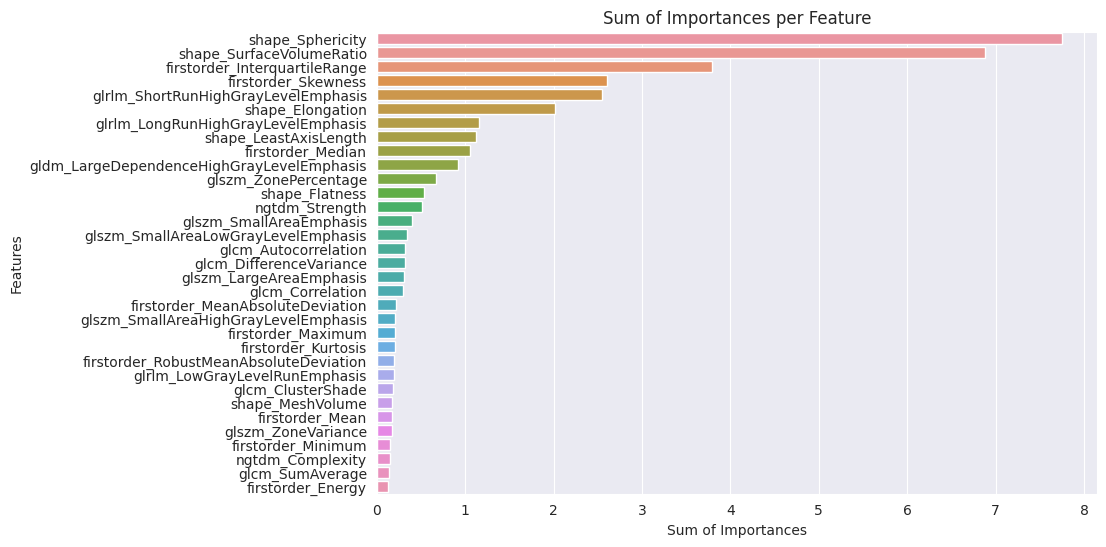

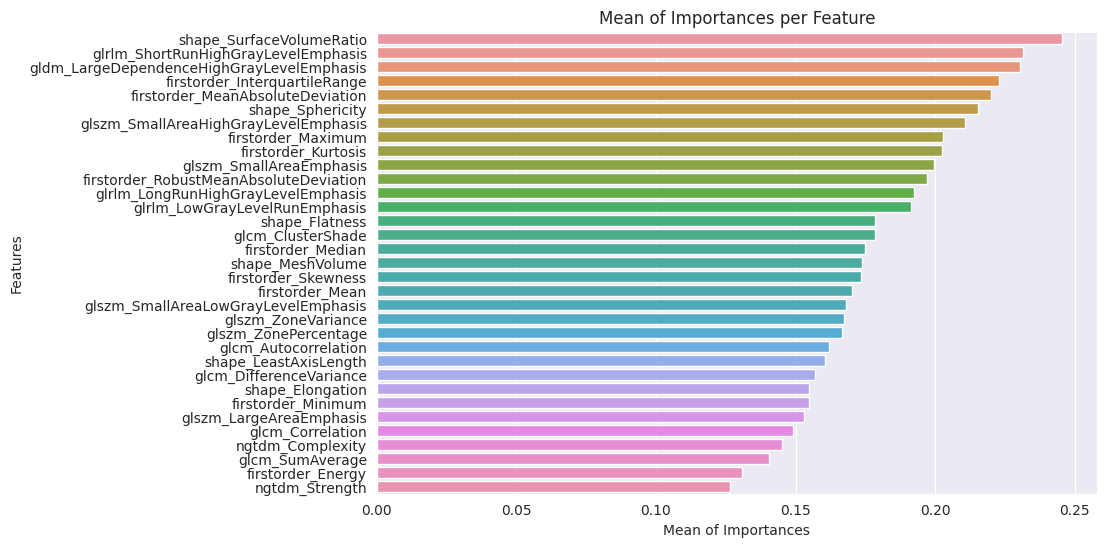

In [14]:

# Calculate the sum of importances per feature
feature_importance_sum = {}
for features, importance in best_features_RF:
    if features in feature_importance_sum:
        feature_importance_sum[features] += importance
    else:
        feature_importance_sum[features] = importance

# Convert the dictionary to lists for plotting
features = list(feature_importance_sum.keys())
importance_sum = list(feature_importance_sum.values())

# Sort the lists in descending order of importance_sum
sorted_indices = sorted(range(len(importance_sum)), key=lambda k: importance_sum[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_sum_sorted = [importance_sum[i] for i in sorted_indices]

# Plot the sum of importances per feature
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_sum_sorted, y=features_sorted)
plt.xlabel('Sum of Importances')
plt.ylabel('Features')
plt.title('Sum of Importances per Feature')
plt.subplots_adjust(left=0.3)
plt.show()

feature_importance_mean = {}
feature_importance_sd = {}
feature_importance_ci = {}

for features, importance in best_features_RF:
    if features in feature_importance_mean:
        feature_importance_mean[features].append(importance)
    else:
        feature_importance_mean[features] = [importance]

feature_importance_mean_ = {feature: np.mean(importances) for feature, importances in feature_importance_mean.items()}
feature_importance_sd = {feature: np.std(importances) for feature, importances in feature_importance_mean.items()}

# Convert the dictionary to lists for plotting
features = list(feature_importance_mean_.keys())
importance_mean = list(feature_importance_mean_.values())

# Sort the lists in descending order of importance_mean
sorted_indices = sorted(range(len(importance_mean)), key=lambda k: importance_mean[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_mean_sorted = [importance_mean[i] for i in sorted_indices]

# Plot the mean of importances per feature
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_mean_sorted, y=features_sorted)
plt.xlabel('Mean of Importances')
plt.ylabel('Features')
plt.title('Mean of Importances per Feature')

# Adjust the position of the figure
plt.subplots_adjust(left=0.3)

plt.show()

In [15]:

p_value_sum = {}
p_value_mean = {}
p_value_sd = {}

for p_value_dict in p_value:
    for feature, value in p_value_dict.items():
        if feature in p_value_sum:
            p_value_sum[feature] += value
        else:
            p_value_sum[feature] = value

# Calculate the mean and standard deviation of p-values per feature
for feature in p_value_sum:
    p_values_per_feature = [p_value_dict[feature] for p_value_dict in p_value if feature in p_value_dict]
    p_value_mean[feature] = np.mean(p_values_per_feature)
    p_value_sd[feature] = np.std(p_values_per_feature)

print('p_value_mean', p_value_mean)

p_value_mean {'shape_Sphericity': 1.6989878998720047e-08, 'shape_LeastAxisLength': 0.00152006612744453, 'firstorder_Median': 0.2322503151071418, 'shape_SurfaceVolumeRatio': 1.3399655397471068e-08, 'shape_Flatness': 1.140533173764662e-06, 'shape_Elongation': 4.282189228531456e-06, 'glrlm_LowGrayLevelRunEmphasis': 0.14570966756781048, 'firstorder_InterquartileRange': 0.02504902346384619, 'glszm_LargeAreaEmphasis': 0.006026322655512459, 'firstorder_Skewness': 0.008634800140128832, 'glrlm_LongRunHighGrayLevelEmphasis': 3.09714249436373e-07, 'glrlm_ShortRunHighGrayLevelEmphasis': 8.51566347599692e-07, 'glcm_Correlation': 0.13254392630282982, 'ngtdm_Strength': 0.013311584765932954, 'glszm_ZonePercentage': 0.0005448913635590089, 'glszm_SmallAreaHighGrayLevelEmphasis': 0.16543100094584035, 'firstorder_Maximum': 0.012190427602856067, 'glcm_SumAverage': 0.08647267748246291, 'glszm_SmallAreaLowGrayLevelEmphasis': 0.015149434124891281, 'gldm_LargeDependenceHighGrayLevelEmphasis': 6.729548005482164

In [16]:
print('p_value_sd', p_value_sd)

p_value_sd {'shape_Sphericity': 4.711554714493575e-08, 'shape_LeastAxisLength': 0.0020994212714331136, 'firstorder_Median': 0.08222821531204479, 'shape_SurfaceVolumeRatio': 3.106458274947851e-08, 'shape_Flatness': 1.4351490667853759e-06, 'shape_Elongation': 8.6066551457068e-06, 'glrlm_LowGrayLevelRunEmphasis': 0.0, 'firstorder_InterquartileRange': 0.023282970168228913, 'glszm_LargeAreaEmphasis': 0.005711078957078815, 'firstorder_Skewness': 0.007163493353856513, 'glrlm_LongRunHighGrayLevelEmphasis': 4.3092415904648797e-07, 'glrlm_ShortRunHighGrayLevelEmphasis': 1.1094001695605872e-06, 'glcm_Correlation': 0.003610264033239413, 'ngtdm_Strength': 0.011441146606839323, 'glszm_ZonePercentage': 0.0006038853466489883, 'glszm_SmallAreaHighGrayLevelEmphasis': 0.0, 'firstorder_Maximum': 0.0, 'glcm_SumAverage': 0.0, 'glszm_SmallAreaLowGrayLevelEmphasis': 0.007973456850414083, 'gldm_LargeDependenceHighGrayLevelEmphasis': 3.6190075294832343e-07, 'glcm_Autocorrelation': 0.024040970842044783, 'glszm_Z

In [17]:
print('p_value_sum', p_value_sum)

p_value_sum {'shape_Sphericity': 6.116356439539216e-07, 'shape_LeastAxisLength': 0.01064046289211171, 'firstorder_Median': 1.393501890642851, 'shape_SurfaceVolumeRatio': 3.751903511291899e-07, 'shape_Flatness': 3.4215995212939863e-06, 'shape_Elongation': 5.566845997090893e-05, 'glrlm_LowGrayLevelRunEmphasis': 0.14570966756781048, 'firstorder_InterquartileRange': 0.42583339888538524, 'glszm_LargeAreaEmphasis': 0.012052645311024918, 'firstorder_Skewness': 0.12952200210193246, 'glrlm_LongRunHighGrayLevelEmphasis': 1.858285496618238e-06, 'glrlm_ShortRunHighGrayLevelEmphasis': 9.367229823596613e-06, 'glcm_Correlation': 0.26508785260565965, 'ngtdm_Strength': 0.053246339063731815, 'glszm_ZonePercentage': 0.0021795654542360356, 'glszm_SmallAreaHighGrayLevelEmphasis': 0.16543100094584035, 'firstorder_Maximum': 0.012190427602856067, 'glcm_SumAverage': 0.08647267748246291, 'glszm_SmallAreaLowGrayLevelEmphasis': 0.030298868249782562, 'gldm_LargeDependenceHighGrayLevelEmphasis': 2.691819202192866e-

## f 10

In [23]:
# Store the scores and metrics
scores_rf = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
scores_svc = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI':[], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
best_features_RF = []
for name, pipeline in pipelines.items():
    # Initialize lists to store scores for each fold
    fold_acc = []
    fold_auc_tot = []
    fold_auc_class = []
    sensi = []
    speci = []
    features = []
    p_value = []
    feat = []
    value = []
    for train_index, test_index in cv_outer.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_normed = scaler.fit_transform(X_train)
        X_test_normed = scaler.transform(X_test)

        X_train_scal = pd.DataFrame(X_train_normed, columns=X_train.columns, index=X_train.index)
        X_test_scal = pd.DataFrame(X_test_normed, columns=X_test.columns, index=X_test.index)

        #select the best 15 features
        selected_feature_names = mrmr_classif(X_train_scal, y_train, K=10)
        X_train_new = X_train_scal[selected_feature_names]
        X_test_new = X_test_scal[selected_feature_names]
        f_scores, p_values = f_classif(X_train_new, y_train)
        feature_p_values = dict(zip(selected_feature_names, p_values))
        p_value.append(feature_p_values)

        cv_inner = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=seed)
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_inner, scoring='roc_auc_ovr', error_score="raise")
        grid_search.fit(X_train_new, y_train)
        clf = grid_search.best_estimator_
        print(clf)
        clf.fit(X_train_new, y_train)
        y_pred = clf.predict(X_test_new)
        accuracy = accuracy_score(y_test, y_pred)
        num_classes = len(np.unique(y_test))
        cm = confusion_matrix(y_test, y_pred)
        specificity = calculate_specificity(cm)
        sensitivity = calculate_sensitivity(cm)
        # Print the results

        accuracy = accuracy_score(y_test, y_pred)
        fold_acc.append(accuracy)

        # Calculate AUC score
        auc_tot = multiclass_roc_auc_score(y_test, y_pred)
        fold_auc_tot.append(auc_tot)

        auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
        fold_auc_class.append(auc_class)

        speci.append(specificity)
        sensi.append(sensitivity)

        print('Auc Score', multiclass_roc_auc_score(y_test, y_pred))
        print('Auc Score OvR', class_vs_rest_roc_auc_score(y_test, y_pred))

        if name == 'rf':
            params_rf = grid_search.best_estimator_
            feature_importance = clf.named_steps['clf'].feature_importances_
            for featureses, importance in zip(selected_feature_names, feature_importance):
                best_features_RF.append((featureses, importance))
        else:
            continue
    # Calculate average scores across folds
    if name == 'rf':
        #acc
        avg_acc = np.mean(fold_acc)
        scores_rf['acc'].append(avg_acc)
        scores_rf['acc'] = scores_rf['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_rf['CI_acc'].append(ci)
        scores_rf['SD_acc'].append(np.std(fold_acc))

        #auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_rf['auc_tot'].append(avg_auc_tot)
        scores_rf['auc_tot'] = scores_rf['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_rf['CI_auc_tot'].append(ci)
        scores_rf['SD_auc_tot'].append(np.std(fold_auc_tot))

        #auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['CI_auc_class'].append(CI_auc_class)

        #sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Sen_CI'].append(CI_sen_class)

        #specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Spe_mean'].append(avg_speci_class)
        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Spe_CI'].append(CI_spe_class)

    elif name == 'svc':
        # acc
        avg_acc = np.mean(fold_acc)
        scores_svc['acc'].append(avg_acc)
        scores_svc['acc'] = scores_svc['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_svc['CI_acc'].append(ci)
        scores_svc['SD_acc'].append(np.std(fold_acc))

        # auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_svc['auc_tot'].append(avg_auc_tot)
        scores_svc['auc_tot'] = scores_svc['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_svc['CI_auc_tot'].append(ci)
        scores_svc['SD_auc_tot'].append(np.std(fold_auc_tot))

        # auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['CI_auc_class'].append(CI_auc_class)

        # sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Sen_CI'].append(CI_sen_class)

        # specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Spe_mean'].append(avg_speci_class)

        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Spe_CI'].append(CI_spe_class)


100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.7284374449674997
Auc Score OvR {0: 0.7694805194805195, 1: 0.6296296296296297, 2: 0.7862021857923498}


100%|██████████| 10/10 [00:01<00:00,  9.50it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6297645089707212
Auc Score OvR {0: 0.645021645021645, 1: 0.5584795321637427, 2: 0.6857923497267759}


100%|██████████| 10/10 [00:01<00:00,  7.14it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6546484437993872
Auc Score OvR {0: 0.8333333333333334, 1: 0.5665094339622642, 2: 0.5641025641025642}


100%|██████████| 10/10 [00:01<00:00,  9.16it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.5988314620390093
Auc Score OvR {0: 0.4913419913419913, 1: 0.5820754716981132, 2: 0.7230769230769232}


100%|██████████| 10/10 [00:01<00:00,  8.55it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6650497301440698
Auc Score OvR {0: 0.6980519480519481, 1: 0.625943396226415, 2: 0.6711538461538462}


100%|██████████| 10/10 [00:01<00:00,  9.43it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6879455250363865
Auc Score OvR {0: 0.7437810945273631, 1: 0.5969785575048733, 2: 0.7230769230769232}


100%|██████████| 10/10 [00:01<00:00,  9.64it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6539958073967277
Auc Score OvR {0: 0.5703463203463204, 1: 0.621832358674464, 2: 0.7698087431693988}


100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6526323155960775
Auc Score OvR {0: 0.6374458874458875, 1: 0.5847953216374271, 2: 0.7356557377049181}


100%|██████████| 10/10 [00:01<00:00,  8.94it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.6398661087340333
Auc Score OvR {0: 0.7283549783549784, 1: 0.5886792452830188, 2: 0.6025641025641026}


100%|██████████| 10/10 [00:01<00:00,  8.53it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6494115423360706
Auc Score OvR {0: 0.6645021645021645, 1: 0.629245283018868, 2: 0.6544871794871795}


100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.7194309882989129
Auc Score OvR {0: 0.7132034632034633, 1: 0.6636792452830188, 2: 0.7814102564102565}


100%|██████████| 10/10 [00:01<00:00,  8.86it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.60886762394356
Auc Score OvR {0: 0.6691542288557213, 1: 0.5414230019493177, 2: 0.6160256410256411}


100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6183809173814926
Auc Score OvR {0: 0.6190476190476191, 1: 0.5414230019493177, 2: 0.694672131147541}


100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.579338656848004
Auc Score OvR {0: 0.5854978354978355, 1: 0.49951267056530213, 2: 0.6530054644808744}


100%|██████████| 10/10 [00:01<00:00,  9.26it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.5476403051874751
Auc Score OvR {0: 0.461038961038961, 1: 0.45047169811320753, 2: 0.7314102564102565}


100%|██████████| 10/10 [00:01<00:00,  9.16it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6051051673693183
Auc Score OvR {0: 0.7619047619047621, 1: 0.49764150943396224, 2: 0.5557692307692308}


100%|██████████| 10/10 [00:01<00:00,  9.21it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.731499370650314
Auc Score OvR {0: 0.7997835497835498, 1: 0.6165094339622641, 2: 0.7782051282051281}


100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6006755098402127
Auc Score OvR {0: 0.5559701492537313, 1: 0.5165692007797271, 2: 0.7294871794871794}


100%|██████████| 10/10 [00:01<00:00,  9.37it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.659586296701626
Auc Score OvR {0: 0.5930735930735931, 1: 0.6247563352826511, 2: 0.7609289617486339}


100%|██████████| 10/10 [00:01<00:00,  9.29it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.712009262268106
Auc Score OvR {0: 0.7543290043290043, 1: 0.6125730994152047, 2: 0.7691256830601094}


100%|██████████| 10/10 [00:01<00:00,  9.05it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5814631908971531
Auc Score OvR {0: 0.6038961038961039, 1: 0.4693396226415094, 2: 0.6711538461538462}


100%|██████████| 10/10 [00:01<00:00,  8.58it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.648659411866959
Auc Score OvR {0: 0.6677489177489178, 1: 0.5820754716981132, 2: 0.6961538461538461}


100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7053932964310322
Auc Score OvR {0: 0.7359307359307359, 1: 0.5853773584905659, 2: 0.7948717948717949}


100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5943999077934663
Auc Score OvR {0: 0.7002487562189056, 1: 0.5073099415204678, 2: 0.5756410256410255}


100%|██████████| 10/10 [00:01<00:00,  9.37it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6247947413104158
Auc Score OvR {0: 0.6525974025974026, 1: 0.5940545808966862, 2: 0.6277322404371586}


100%|██████████| 10/10 [00:01<00:00,  9.24it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.651644359007028
Auc Score OvR {0: 0.6038961038961039, 1: 0.5477582846003899, 2: 0.8032786885245902}


100%|██████████| 10/10 [00:01<00:00,  9.26it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.627306236740199
Auc Score OvR {0: 0.6645021645021645, 1: 0.5443396226415095, 2: 0.6730769230769231}


100%|██████████| 10/10 [00:01<00:00,  9.15it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6146506009713557
Auc Score OvR {0: 0.6980519480519481, 1: 0.5382075471698112, 2: 0.6076923076923078}


100%|██████████| 10/10 [00:01<00:00,  9.23it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6866397229604777
Auc Score OvR {0: 0.7435064935064934, 1: 0.5882075471698113, 2: 0.7282051282051282}


100%|██████████| 10/10 [00:01<00:00,  9.10it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.56161352854859
Auc Score OvR {0: 0.6007462686567164, 1: 0.4731968810916179, 2: 0.610897435897436}


100%|██████████| 10/10 [00:01<00:00,  5.28it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.5713158953020904
Auc Score OvR {0: 0.4913419913419913, 1: 0.5614035087719298, 2: 0.6612021857923498}


100%|██████████| 10/10 [00:01<00:00,  9.26it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.6036834614272061
Auc Score OvR {0: 0.5400432900432901, 1: 0.5599415204678362, 2: 0.7110655737704918}


100%|██████████| 10/10 [00:01<00:00,  9.27it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6128484722824346
Auc Score OvR {0: 0.6980519480519481, 1: 0.49433962264150944, 2: 0.6461538461538461}


100%|██████████| 10/10 [00:01<00:00,  9.48it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6526254667764101
Auc Score OvR {0: 0.6266233766233766, 1: 0.5665094339622642, 2: 0.7647435897435898}


100%|██████████| 10/10 [00:01<00:00,  8.87it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.7340697038810245
Auc Score OvR {0: 0.8528138528138529, 1: 0.6731132075471699, 2: 0.6762820512820512}


100%|██████████| 10/10 [00:01<00:00,  9.44it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.549922340613621
Auc Score OvR {0: 0.5485074626865671, 1: 0.42690058479532167, 2: 0.6743589743589744}


100%|██████████| 10/10 [00:01<00:00,  9.11it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.655953321649324
Auc Score OvR {0: 0.6677489177489178, 1: 0.5384990253411306, 2: 0.7616120218579234}


100%|██████████| 10/10 [00:02<00:00,  4.70it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6174525843780949
Auc Score OvR {0: 0.6558441558441559, 1: 0.5107212475633529, 2: 0.6857923497267759}


100%|██████████| 10/10 [00:01<00:00,  9.35it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6005462043197892
Auc Score OvR {0: 0.6677489177489178, 1: 0.5377358490566038, 2: 0.5961538461538461}


100%|██████████| 10/10 [00:01<00:00,  9.36it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5640039206076942
Auc Score OvR {0: 0.35930735930735924, 1: 0.5160377358490567, 2: 0.8166666666666667}


100%|██████████| 10/10 [00:01<00:00,  9.38it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6072023888061624
Auc Score OvR {0: 0.6677489177489178, 1: 0.5160377358490567, 2: 0.6378205128205128}


100%|██████████| 10/10 [00:01<00:00,  9.05it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6827189774623658
Auc Score OvR {0: 0.8134328358208955, 1: 0.5199805068226121, 2: 0.7147435897435898}


100%|██████████| 10/10 [00:01<00:00,  9.47it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6171463736893705
Auc Score OvR {0: 0.5887445887445888, 1: 0.4922027290448343, 2: 0.7704918032786885}


100%|██████████| 10/10 [00:01<00:00,  9.42it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6559065807699688
Auc Score OvR {0: 0.6861471861471862, 1: 0.537037037037037, 2: 0.7445355191256832}


100%|██████████| 10/10 [00:01<00:00,  8.50it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6349485943825567
Auc Score OvR {0: 0.7694805194805195, 1: 0.5443396226415095, 2: 0.591025641025641}


100%|██████████| 10/10 [00:01<00:00,  9.31it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6502386502386502
Auc Score OvR {0: 0.7391774891774892, 1: 0.5, 2: 0.7115384615384616}


100%|██████████| 10/10 [00:01<00:00,  9.37it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6702732278203977
Auc Score OvR {0: 0.6904761904761906, 1: 0.5754716981132075, 2: 0.7448717948717949}


100%|██████████| 10/10 [00:01<00:00,  8.99it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6144294646127587
Auc Score OvR {0: 0.6927860696517414, 1: 0.46588693957115007, 2: 0.6846153846153846}


100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5467528282814448
Auc Score OvR {0: 0.5021645021645021, 1: 0.48440545808966856, 2: 0.6536885245901638}


100%|██████████| 10/10 [00:01<00:00,  8.89it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6939323179616537
Auc Score OvR {0: 0.777056277056277, 1: 0.5847953216374271, 2: 0.7199453551912569}


100%|██████████| 10/10 [00:01<00:00,  9.37it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6161100429968355
Auc Score OvR {0: 0.6147186147186148, 1: 0.49386792452830186, 2: 0.7397435897435898}


100%|██████████| 10/10 [00:01<00:00,  9.41it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=10,
                                                            class_weight='balanced',
                                                            max_iter=20000,
                                                            random_state=0)))])
Auc Score 0.6390927206964943
Auc Score OvR {0: 0.7467532467532467, 1: 0.5410377358490566, 2: 0.6294871794871795}


100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.7044179091348903
Auc Score OvR {0: 0.8712121212121212, 1: 0.5471698113207547, 2: 0.6948717948717948}


100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6322126061848502
Auc Score OvR {0: 0.6243781094527363, 1: 0.5107212475633529, 2: 0.7615384615384615}


100%|██████████| 10/10 [00:01<00:00,  9.32it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6331066979974084
Auc Score OvR {0: 0.6601731601731602, 1: 0.5185185185185185, 2: 0.7206284153005464}


100%|██████████| 10/10 [00:02<00:00,  4.34it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6006992905900009
Auc Score OvR {0: 0.6601731601731602, 1: 0.5462962962962963, 2: 0.5956284153005464}


100%|██████████| 10/10 [00:01<00:00,  9.04it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6791093078828928
Auc Score OvR {0: 0.8181818181818181, 1: 0.5127358490566037, 2: 0.7064102564102565}


100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.611484689314878
Auc Score OvR {0: 0.6298701298701299, 1: 0.5283018867924528, 2: 0.6762820512820512}


100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6721262490130414
Auc Score OvR {0: 0.7391774891774892, 1: 0.49386792452830186, 2: 0.7833333333333333}


100%|██████████| 10/10 [00:01<00:00,  9.11it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6245724817209499
Auc Score OvR {0: 0.6853233830845772, 1: 0.530701754385965, 2: 0.6576923076923077}


100%|██████████| 10/10 [00:01<00:00,  9.52it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6386644877082035
Auc Score OvR {0: 0.7088744588744589, 1: 0.537037037037037, 2: 0.6700819672131147}


100%|██████████| 10/10 [00:01<00:00,  9.04it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6633903437182126
Auc Score OvR {0: 0.777056277056277, 1: 0.5, 2: 0.7131147540983607}


100%|██████████| 10/10 [00:01<00:00,  8.45it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6788407085576896
Auc Score OvR {0: 0.7694805194805195, 1: 0.5471698113207547, 2: 0.7198717948717949}


100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5087879625615475
Auc Score OvR {0: 0.512987012987013, 1: 0.5127358490566037, 2: 0.5006410256410256}


100%|██████████| 10/10 [00:01<00:00,  8.88it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6555178574046499
Auc Score OvR {0: 0.7694805194805195, 1: 0.49386792452830186, 2: 0.7032051282051281}


100%|██████████| 10/10 [00:01<00:00,  9.11it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6158233237769766
Auc Score OvR {0: 0.5708955223880597, 1: 0.5336257309941521, 2: 0.742948717948718}


100%|██████████| 10/10 [00:01<00:00,  8.53it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5624594237982217
Auc Score OvR {0: 0.5995670995670996, 1: 0.5092592592592593, 2: 0.5785519125683061}


100%|██████████| 10/10 [00:01<00:00,  8.91it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6001041268513228
Auc Score OvR {0: 0.6266233766233766, 1: 0.5029239766081872, 2: 0.6707650273224044}


100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6699224255828029
Auc Score OvR {0: 0.7467532467532467, 1: 0.5566037735849056, 2: 0.7064102564102565}


100%|██████████| 10/10 [00:01<00:00,  8.82it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6552705156478742
Auc Score OvR {0: 0.7056277056277057, 1: 0.5287735849056604, 2: 0.7314102564102565}


100%|██████████| 10/10 [00:01<00:00,  9.05it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6602066696406319
Auc Score OvR {0: 0.7132034632034633, 1: 0.5693396226415094, 2: 0.6980769230769232}


100%|██████████| 10/10 [00:01<00:00,  9.07it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6695030060374392
Auc Score OvR {0: 0.6853233830845772, 1: 0.5199805068226121, 2: 0.8032051282051282}


In [24]:
for value, score in scores_svc.items():
    print('svc', f'{value}: {score}')

for value, score in scores_rf.items():
    print('rf', f'{value}: {score}')

svc acc: 0.28310502283105027
svc SD_acc: [0.04917958727976716]
svc CI_acc: [(0.2662290046390803, 0.29998104102302026)]
svc auc_tot: 0.6334146744943903
svc SD_auc_tot: [0.04203556788610724]
svc CI_auc_tot: [(0.6189901327771078, 0.6478392162116727)]
svc auc_class: [{0: 0.6809360484733619, 1: 0.5238246370059788, 2: 0.6954833380038298}]
svc SD_auc_class: [{0: 0.09700611194967287, 1: 0.025789891403124706, 2: 0.06601047832839266}]
svc CI_auc_class: [{0: (0.6476483167020043, 0.7142237802447194), 1: (0.514974813317704, 0.5326744606942536), 2: (0.67283178489515, 0.7181348911125095)}]
svc Sen_mean: [{0: 75.26455026455028, 1: 9.764927401195745, 2: 81.35683760683762}]
svc Sen_CI: [{0: (69.55420180500091, 80.97489872409965), 1: (7.606885552277211, 11.92296925011428), 2: (76.68042263292287, 86.03325258075236)}]
svc Sen_SD: [{0: 16.640926625566134, 1: 6.28890098689151, 2: 13.627868597314162}]
svc Spe_mean: [{0: 60.92265943012212, 1: 95.0, 2: 57.73982999392836}]
svc Spe_CI: [{0: (58.46838399681653, 63

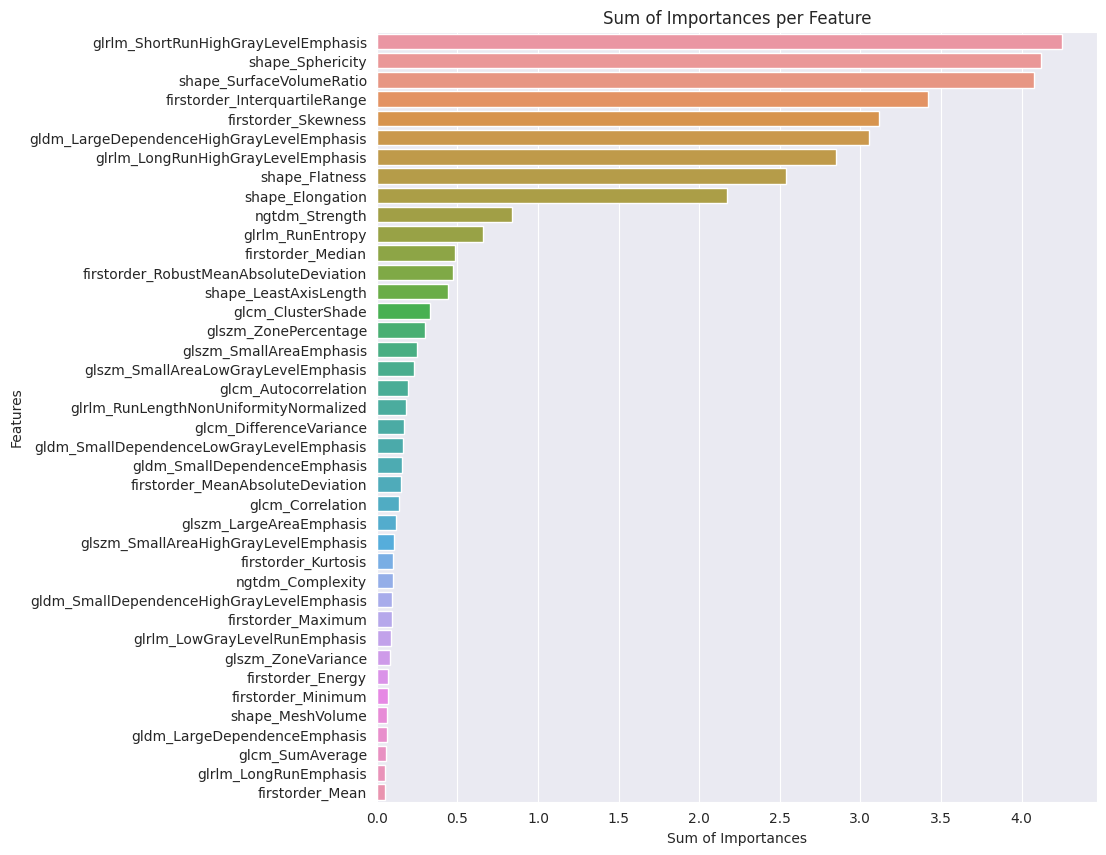

In [81]:
# Calculate the sum of importances per feature
feature_importance_sum = {}
for features, importance in best_features_RF:
    if features in feature_importance_sum:
        feature_importance_sum[features] += importance
    else:
        feature_importance_sum[features] = importance

# Convert the dictionary to lists for plotting
features = list(feature_importance_sum.keys())
importance_sum = list(feature_importance_sum.values())

# Sort the lists in descending order of importance_sum
sorted_indices = sorted(range(len(importance_sum)), key=lambda k: importance_sum[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_sum_sorted = [importance_sum[i] for i in sorted_indices]

# Plot the sum of importances per feature
plt.figure(figsize=(12, 10))
sns.barplot(x=importance_sum_sorted, y=features_sorted)
plt.xlabel('Sum of Importances')
plt.ylabel('Features')
plt.title('Sum of Importances per Feature')
plt.subplots_adjust(left=0.3)
plt.show()

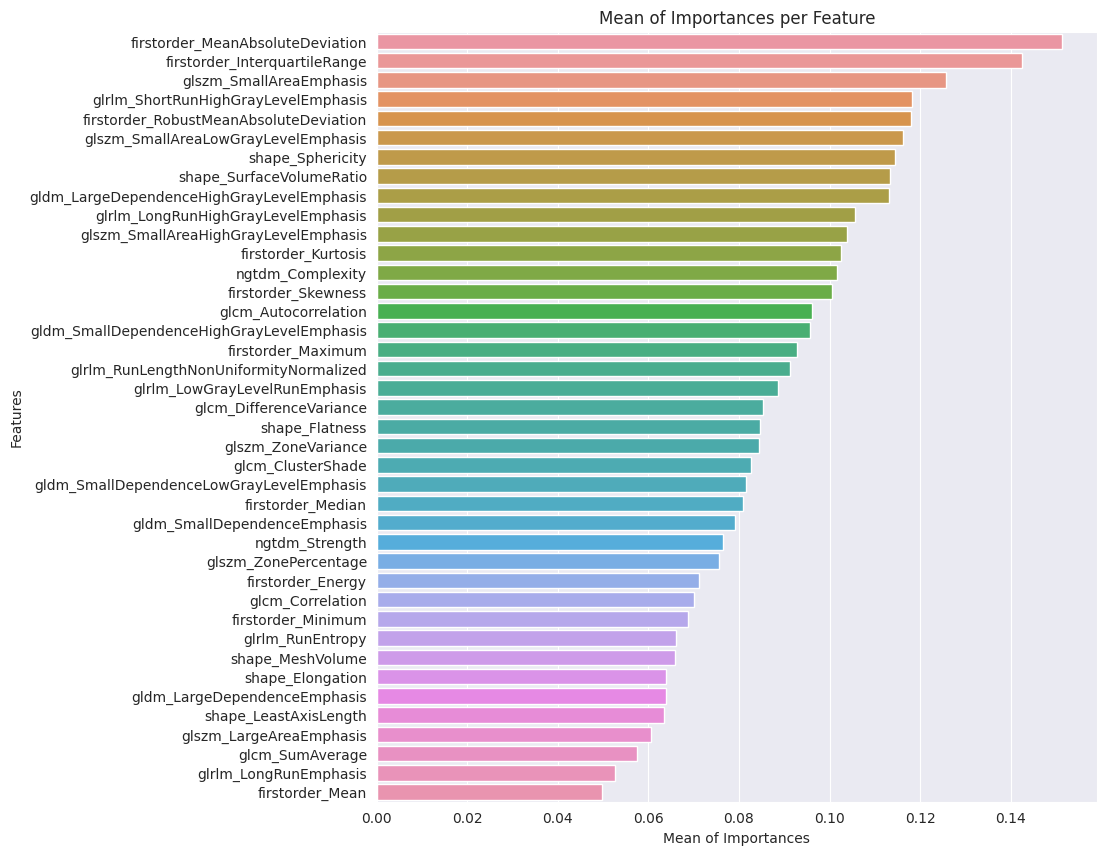

In [82]:
feature_importance_mean = {}
feature_importance_sd = {}
feature_importance_ci = {}

for features, importance in best_features_RF:
    if features in feature_importance_mean:
        feature_importance_mean[features].append(importance)
    else:
        feature_importance_mean[features] = [importance]

feature_importance_mean_ = {feature: np.mean(importances) for feature, importances in feature_importance_mean.items()}
feature_importance_sd = {feature: np.std(importances) for feature, importances in feature_importance_mean.items()}

# Convert the dictionary to lists for plotting
features = list(feature_importance_mean_.keys())
importance_mean = list(feature_importance_mean_.values())

# Sort the lists in descending order of importance_mean
sorted_indices = sorted(range(len(importance_mean)), key=lambda k: importance_mean[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_mean_sorted = [importance_mean[i] for i in sorted_indices]

# Plot the mean of importances per feature
plt.figure(figsize=(12, 10))
sns.barplot(x=importance_mean_sorted, y=features_sorted)
plt.xlabel('Mean of Importances')
plt.ylabel('Features')
plt.title('Mean of Importances per Feature')

# Adjust the position of the figure
plt.subplots_adjust(left=0.3)

plt.show()

In [83]:

p_value_sum = {}
p_value_mean = {}
p_value_sd = {}

for p_value_dict in p_value:
    for feature, value in p_value_dict.items():
        if feature in p_value_sum:
            p_value_sum[feature] += value
        else:
            p_value_sum[feature] = value

# Calculate the mean and standard deviation of p-values per feature
for feature in p_value_sum:
    p_values_per_feature = [p_value_dict[feature] for p_value_dict in p_value if feature in p_value_dict]
    print(f'{feature}', f'{p_values_per_feature}')
    p_value_mean[feature] = np.mean(p_values_per_feature)
    p_value_sd[feature] = np.std(p_values_per_feature)

print('p_value_sum', p_value_sum)

shape_Sphericity [7.340024810748706e-10, 1.5852055096110667e-10, 4.845232619846369e-10, 5.978344593597296e-10, 1.0573969191123729e-11, 1.3249754906121298e-07, 3.6358882930484856e-09, 3.27702239125033e-09, 4.828923723511336e-11, 4.00769244115798e-08, 9.051715321386993e-10, 5.624247403668833e-12, 2.83723355425192e-12, 3.2590845656020095e-09, 1.1326422827312138e-10, 1.6927917337955153e-11, 5.082239568085029e-08, 3.988411663913418e-08, 1.088901094767292e-09, 2.5809119070560546e-11, 8.821501067929461e-09, 2.3408895316426624e-09, 3.7655789953213575e-08, 3.494830381208989e-12, 1.5432667067415894e-09, 3.0797942684387565e-11, 1.9736432214051076e-08, 1.7979917241715228e-12, 2.5497129214785107e-07, 1.153760812180569e-10, 4.0443896955897466e-10, 8.346527784618831e-10, 5.186867307168091e-09, 1.0086951603238135e-09, 6.797373144358107e-11, 1.2671171644979694e-09]
shape_LeastAxisLength [0.0018303328912114762, 0.00010713075284605753, 0.00028971714215519944, 0.00021221049784003076, 0.006390121006268141,

In [84]:
print('p_value_mean', p_value_mean)

p_value_mean {'shape_Sphericity': 1.6989878998720047e-08, 'shape_LeastAxisLength': 0.00152006612744453, 'firstorder_Median': 0.2322503151071418, 'shape_SurfaceVolumeRatio': 1.2641548606147338e-08, 'shape_Flatness': 3.727152015253242e-06, 'glrlm_ShortRunHighGrayLevelEmphasis': 2.868037669812981e-06, 'gldm_LargeDependenceHighGrayLevelEmphasis': 7.5412630627711195e-06, 'shape_Elongation': 5.254445030458125e-05, 'glrlm_LongRunHighGrayLevelEmphasis': 9.299017909940981e-06, 'firstorder_Skewness': 0.013058224906208702, 'glrlm_RunEntropy': 2.162792545137367e-06, 'glrlm_LowGrayLevelRunEmphasis': 0.14570966756781048, 'firstorder_InterquartileRange': 0.03432080992642406, 'glszm_LargeAreaEmphasis': 0.006026322655512459, 'firstorder_RobustMeanAbsoluteDeviation': 0.005593630834746486, 'gldm_SmallDependenceLowGrayLevelEmphasis': 0.00012420559512658704, 'ngtdm_Strength': 0.010512622650910798, 'glcm_Correlation': 0.13254392630282982, 'glcm_ClusterShade': 0.02738976303874823, 'glszm_ZonePercentage': 0.0

In [85]:
print('p_value_sd', p_value_sd)

p_value_sd {'shape_Sphericity': 4.711554714493575e-08, 'shape_LeastAxisLength': 0.0020994212714331136, 'firstorder_Median': 0.08222821531204479, 'shape_SurfaceVolumeRatio': 2.8073867336962688e-08, 'shape_Flatness': 6.838313935014929e-06, 'glrlm_ShortRunHighGrayLevelEmphasis': 4.995900444062914e-06, 'gldm_LargeDependenceHighGrayLevelEmphasis': 1.4152192768678566e-05, 'shape_Elongation': 0.00011119841268188059, 'glrlm_LongRunHighGrayLevelEmphasis': 2.248945715856638e-05, 'firstorder_Skewness': 0.012036381896435015, 'glrlm_RunEntropy': 5.0555858195163435e-06, 'glrlm_LowGrayLevelRunEmphasis': 0.0, 'firstorder_InterquartileRange': 0.03017039855082851, 'glszm_LargeAreaEmphasis': 0.005711078957078815, 'firstorder_RobustMeanAbsoluteDeviation': 0.0034756070357551795, 'gldm_SmallDependenceLowGrayLevelEmphasis': 0.00010272250533577485, 'ngtdm_Strength': 0.009091510913036784, 'glcm_Correlation': 0.003610264033239413, 'glcm_ClusterShade': 0.016801946267622717, 'glszm_ZonePercentage': 0.000603885346

## f 20

In [28]:
# Store the scores and metrics
scores_rf = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
scores_svc = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI':[], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
best_features_RF = []
for name, pipeline in pipelines.items():
    # Initialize lists to store scores for each fold
    fold_acc = []
    fold_auc_tot = []
    fold_auc_class = []
    sensi = []
    speci = []
    features = []
    p_value = []
    feat = []
    value = []
    for train_index, test_index in cv_outer.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_normed = scaler.fit_transform(X_train)
        X_test_normed = scaler.transform(X_test)

        X_train_scal = pd.DataFrame(X_train_normed, columns=X_train.columns, index=X_train.index)
        X_test_scal = pd.DataFrame(X_test_normed, columns=X_test.columns, index=X_test.index)

        #select the best 15 features
        selected_feature_names = mrmr_classif(X_train_scal, y_train, K=20)
        X_train_new = X_train_scal[selected_feature_names]
        X_test_new = X_test_scal[selected_feature_names]
        f_scores, p_values = f_classif(X_train_new, y_train)
        feature_p_values = dict(zip(selected_feature_names, p_values))
        p_value.append(feature_p_values)

        cv_inner = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=seed)
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_inner, scoring='roc_auc_ovr', error_score="raise")
        grid_search.fit(X_train_new, y_train)
        clf = grid_search.best_estimator_
        print(clf)
        clf.fit(X_train_new, y_train)
        y_pred = clf.predict(X_test_new)
        accuracy = accuracy_score(y_test, y_pred)
        num_classes = len(np.unique(y_test))
        cm = confusion_matrix(y_test, y_pred)
        specificity = calculate_specificity(cm)
        sensitivity = calculate_sensitivity(cm)
        # Print the results

        accuracy = accuracy_score(y_test, y_pred)
        fold_acc.append(accuracy)

        # Calculate AUC score
        auc_tot = multiclass_roc_auc_score(y_test, y_pred)
        fold_auc_tot.append(auc_tot)

        auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
        fold_auc_class.append(auc_class)

        speci.append(specificity)
        sensi.append(sensitivity)

        print('Auc Score', multiclass_roc_auc_score(y_test, y_pred))
        print('Auc Score OvR', class_vs_rest_roc_auc_score(y_test, y_pred))

        if name == 'rf':
            params_rf = grid_search.best_estimator_
            feature_importance = clf.named_steps['clf'].feature_importances_
            for featureses, importance in zip(selected_feature_names, feature_importance):
                best_features_RF.append((featureses, importance))
        else:
            continue
    # Calculate average scores across folds
    if name == 'rf':
        #acc
        avg_acc = np.mean(fold_acc)
        scores_rf['acc'].append(avg_acc)
        scores_rf['acc'] = scores_rf['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_rf['CI_acc'].append(ci)
        scores_rf['SD_acc'].append(np.std(fold_acc))

        #auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_rf['auc_tot'].append(avg_auc_tot)
        scores_rf['auc_tot'] = scores_rf['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_rf['CI_auc_tot'].append(ci)
        scores_rf['SD_auc_tot'].append(np.std(fold_acc))

        #auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['CI_auc_class'].append(CI_auc_class)

        #sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Sen_CI'].append(CI_sen_class)

        #specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Spe_mean'].append(avg_speci_class)
        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Spe_CI'].append(CI_spe_class)

    elif name == 'svc':
        # acc
        avg_acc = np.mean(fold_acc)
        scores_svc['acc'].append(avg_acc)
        scores_svc['acc'] = scores_svc['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_svc['CI_acc'].append(ci)
        scores_svc['SD_acc'].append(np.std(fold_acc))

        # auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_svc['auc_tot'].append(avg_auc_tot)
        scores_svc['auc_tot'] = scores_svc['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_svc['CI_auc_tot'].append(ci)
        scores_svc['SD_auc_tot'].append(np.std(fold_acc))

        # auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['CI_auc_class'].append(CI_auc_class)

        # sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Sen_CI'].append(CI_sen_class)

        # specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Spe_mean'].append(avg_speci_class)

        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Spe_CI'].append(CI_spe_class)


100%|██████████| 20/20 [00:04<00:00,  4.11it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6838046951291128
Auc Score OvR {0: 0.7132034632034633, 1: 0.5847953216374271, 2: 0.753415300546448}


100%|██████████| 20/20 [00:04<00:00,  4.30it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6233320267329471
Auc Score OvR {0: 0.645021645021645, 1: 0.5384990253411306, 2: 0.6864754098360656}


100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6547467207844567
Auc Score OvR {0: 0.7846320346320347, 1: 0.5853773584905659, 2: 0.5942307692307692}


100%|██████████| 20/20 [00:04<00:00,  4.58it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.5782970174479608
Auc Score OvR {0: 0.4837662337662338, 1: 0.5415094339622641, 2: 0.7096153846153845}


100%|██████████| 20/20 [00:04<00:00,  4.25it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6361475002984437
Auc Score OvR {0: 0.7207792207792209, 1: 0.5165094339622641, 2: 0.6711538461538462}


100%|██████████| 20/20 [00:04<00:00,  4.35it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6838226210378605
Auc Score OvR {0: 0.6990049751243781, 1: 0.587719298245614, 2: 0.7647435897435898}


100%|██████████| 20/20 [00:04<00:00,  4.00it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6307211666357482
Auc Score OvR {0: 0.5703463203463204, 1: 0.5847953216374271, 2: 0.7370218579234971}


100%|██████████| 20/20 [00:04<00:00,  4.79it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.6017130471760901
Auc Score OvR {0: 0.6374458874458875, 1: 0.5399610136452242, 2: 0.6277322404371586}


100%|██████████| 20/20 [00:04<00:00,  4.57it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.7144310092423302
Auc Score OvR {0: 0.8073593073593074, 1: 0.64811320754717, 2: 0.6878205128205128}


100%|██████████| 20/20 [00:04<00:00,  4.33it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6090789713431223
Auc Score OvR {0: 0.6417748917748918, 1: 0.5476415094339622, 2: 0.6378205128205128}


100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.7490540382049816
Auc Score OvR {0: 0.8409090909090909, 1: 0.6415094339622641, 2: 0.7647435897435898}


100%|██████████| 20/20 [00:05<00:00,  3.84it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5867553445846192
Auc Score OvR {0: 0.6156716417910447, 1: 0.5151072124756335, 2: 0.6294871794871795}


100%|██████████| 20/20 [00:04<00:00,  4.10it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.5944118728127932
Auc Score OvR {0: 0.461038961038961, 1: 0.5940545808966862, 2: 0.7281420765027323}


100%|██████████| 20/20 [00:04<00:00,  4.54it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.5577807015468793
Auc Score OvR {0: 0.514069264069264, 1: 0.48099415204678364, 2: 0.6782786885245902}


100%|██████████| 20/20 [00:04<00:00,  4.82it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.5727414618924053
Auc Score OvR {0: 0.4837662337662338, 1: 0.5165094339622641, 2: 0.717948717948718}


100%|██████████| 20/20 [00:04<00:00,  4.42it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6145523239862862
Auc Score OvR {0: 0.7467532467532467, 1: 0.5193396226415095, 2: 0.5775641025641025}


100%|██████████| 20/20 [00:04<00:00,  4.75it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.6954488383733667
Auc Score OvR {0: 0.6872294372294372, 1: 0.629245283018868, 2: 0.7698717948717949}


100%|██████████| 20/20 [00:04<00:00,  4.27it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6445101863601471
Auc Score OvR {0: 0.6094527363184079, 1: 0.5862573099415204, 2: 0.7378205128205128}


100%|██████████| 20/20 [00:04<00:00,  4.77it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6692859024251029
Auc Score OvR {0: 0.6645021645021645, 1: 0.6076998050682261, 2: 0.7356557377049181}


100%|██████████| 20/20 [00:04<00:00,  4.67it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.7675121630039663
Auc Score OvR {0: 0.8300865800865801, 1: 0.6944444444444444, 2: 0.7780054644808744}


100%|██████████| 20/20 [00:04<00:00,  4.48it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.572039857417216
Auc Score OvR {0: 0.5963203463203464, 1: 0.4787735849056604, 2: 0.6410256410256411}


100%|██████████| 20/20 [00:04<00:00,  4.63it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5775793389000935
Auc Score OvR {0: 0.5400432900432901, 1: 0.5382075471698112, 2: 0.6544871794871795}


100%|██████████| 20/20 [00:04<00:00,  4.68it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6876260008335481
Auc Score OvR {0: 0.7359307359307359, 1: 0.5570754716981132, 2: 0.7698717948717949}


100%|██████████| 20/20 [00:04<00:00,  4.09it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.647311985581166
Auc Score OvR {0: 0.7450248756218906, 1: 0.5443469785575049, 2: 0.6525641025641025}


100%|██████████| 20/20 [00:04<00:00,  4.41it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6599208320519795
Auc Score OvR {0: 0.6222943722943723, 1: 0.6388888888888888, 2: 0.7185792349726775}


100%|██████████| 20/20 [00:04<00:00,  4.34it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6291833865172951
Auc Score OvR {0: 0.6190476190476191, 1: 0.5321637426900585, 2: 0.7363387978142077}


100%|██████████| 20/20 [00:04<00:00,  4.26it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6835056976566412
Auc Score OvR {0: 0.7359307359307359, 1: 0.5915094339622642, 2: 0.7230769230769232}


100%|██████████| 20/20 [00:04<00:00,  4.79it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5960326361269758
Auc Score OvR {0: 0.6980519480519481, 1: 0.5259433962264151, 2: 0.5641025641025642}


100%|██████████| 20/20 [00:04<00:00,  4.83it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6296878697822094
Auc Score OvR {0: 0.6233766233766234, 1: 0.575943396226415, 2: 0.6897435897435897}


100%|██████████| 20/20 [00:04<00:00,  4.22it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.5512990043037175
Auc Score OvR {0: 0.6156716417910447, 1: 0.48245614035087714, 2: 0.5557692307692308}


100%|██████████| 20/20 [00:04<00:00,  4.32it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.5862131974800943
Auc Score OvR {0: 0.5854978354978355, 1: 0.5536062378167641, 2: 0.6195355191256832}


100%|██████████| 20/20 [00:05<00:00,  3.90it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6071504311366261
Auc Score OvR {0: 0.6266233766233766, 1: 0.5336257309941521, 2: 0.6612021857923498}


100%|██████████| 20/20 [00:04<00:00,  4.43it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6568600162939785
Auc Score OvR {0: 0.7467532467532467, 1: 0.5693396226415094, 2: 0.6544871794871795}


100%|██████████| 20/20 [00:04<00:00,  4.44it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6428114338491696
Auc Score OvR {0: 0.6417748917748918, 1: 0.560377358490566, 2: 0.7262820512820513}


100%|██████████| 20/20 [00:04<00:00,  4.41it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7220599630976988
Auc Score OvR {0: 0.7359307359307359, 1: 0.660377358490566, 2: 0.7698717948717949}


100%|██████████| 20/20 [00:04<00:00,  4.16it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.5953848429169193
Auc Score OvR {0: 0.585820895522388, 1: 0.5009746588693956, 2: 0.6993589743589743}


100%|██████████| 20/20 [00:04<00:00,  4.68it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.699744078554835
Auc Score OvR {0: 0.7467532467532467, 1: 0.5662768031189084, 2: 0.7862021857923498}


100%|██████████| 20/20 [00:04<00:00,  4.39it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6407951489918703
Auc Score OvR {0: 0.6222943722943723, 1: 0.5555555555555556, 2: 0.7445355191256832}


100%|██████████| 20/20 [00:04<00:00,  4.11it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6004080301250113
Auc Score OvR {0: 0.682900432900433, 1: 0.5221698113207547, 2: 0.5961538461538461}


100%|██████████| 20/20 [00:04<00:00,  4.78it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5208004783476481
Auc Score OvR {0: 0.39718614718614714, 1: 0.45047169811320753, 2: 0.7147435897435898}


100%|██████████| 20/20 [00:04<00:00,  4.71it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6844123381859232
Auc Score OvR {0: 0.8257575757575757, 1: 0.5377358490566038, 2: 0.6897435897435897}


100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.7050149052309305
Auc Score OvR {0: 0.8432835820895522, 1: 0.5570175438596492, 2: 0.7147435897435898}


100%|██████████| 20/20 [00:04<00:00,  4.51it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6281627303341425
Auc Score OvR {0: 0.6114718614718614, 1: 0.5107212475633529, 2: 0.7622950819672132}


100%|██████████| 20/20 [00:04<00:00,  4.22it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6552575344637468
Auc Score OvR {0: 0.6937229437229437, 1: 0.5029239766081872, 2: 0.7691256830601094}


100%|██████████| 20/20 [00:04<00:00,  4.48it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.672875709196464
Auc Score OvR {0: 0.8560606060606061, 1: 0.5632075471698114, 2: 0.5993589743589743}


100%|██████████| 20/20 [00:04<00:00,  4.76it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6525059322229133
Auc Score OvR {0: 0.6904761904761906, 1: 0.5471698113207547, 2: 0.7198717948717949}


100%|██████████| 20/20 [00:04<00:00,  4.67it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6465835003570853
Auc Score OvR {0: 0.6904761904761906, 1: 0.5377358490566038, 2: 0.7115384615384616}


100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6646022026619042
Auc Score OvR {0: 0.7151741293532338, 1: 0.5555555555555556, 2: 0.7230769230769232}


100%|██████████| 20/20 [00:04<00:00,  4.13it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6188301174639972
Auc Score OvR {0: 0.5963203463203464, 1: 0.5648148148148148, 2: 0.6953551912568307}


100%|██████████| 20/20 [00:04<00:00,  4.72it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6147477002380655
Auc Score OvR {0: 0.7467532467532467, 1: 0.4936647173489279, 2: 0.6038251366120218}


100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5797087084822934
Auc Score OvR {0: 0.5584415584415584, 1: 0.4877358490566038, 2: 0.692948717948718}


100%|██████████| 20/20 [00:03<00:00,  5.03it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6494118041287853
Auc Score OvR {0: 0.7164502164502164, 1: 0.5471698113207547, 2: 0.6846153846153846}


100%|██████████| 20/20 [00:04<00:00,  4.13it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.7184079547287094
Auc Score OvR {0: 0.8939393939393939, 1: 0.5632075471698114, 2: 0.6980769230769232}


100%|██████████| 20/20 [00:04<00:00,  4.30it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6290834028985377
Auc Score OvR {0: 0.6019900497512437, 1: 0.5121832358674463, 2: 0.7730769230769231}


100%|██████████| 20/20 [00:04<00:00,  4.11it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6011250251256003
Auc Score OvR {0: 0.5811688311688311, 1: 0.4858674463937621, 2: 0.7363387978142077}


100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6628278622814142
Auc Score OvR {0: 0.6677489177489178, 1: 0.5925925925925926, 2: 0.7281420765027323}


100%|██████████| 20/20 [00:04<00:00,  4.59it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6521712040579966
Auc Score OvR {0: 0.803030303030303, 1: 0.49386792452830186, 2: 0.6596153846153847}


100%|██████████| 20/20 [00:04<00:00,  4.87it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6104346910950685
Auc Score OvR {0: 0.6266233766233766, 1: 0.5316037735849056, 2: 0.6730769230769231}


100%|██████████| 20/20 [00:04<00:00,  4.66it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6566423094724981
Auc Score OvR {0: 0.7467532467532467, 1: 0.47830188679245284, 2: 0.7448717948717949}


100%|██████████| 20/20 [00:04<00:00,  4.82it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6019794377937872
Auc Score OvR {0: 0.7077114427860697, 1: 0.4873294346978557, 2: 0.610897435897436}


100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6503018080886934
Auc Score OvR {0: 0.7088744588744589, 1: 0.5555555555555556, 2: 0.6864754098360656}


100%|██████████| 20/20 [00:04<00:00,  4.43it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6866649844791922
Auc Score OvR {0: 0.777056277056277, 1: 0.537037037037037, 2: 0.7459016393442623}


100%|██████████| 20/20 [00:04<00:00,  4.82it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6511502124709673
Auc Score OvR {0: 0.7056277056277057, 1: 0.5632075471698114, 2: 0.6846153846153846}


100%|██████████| 20/20 [00:04<00:00,  4.64it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5408831734303433
Auc Score OvR {0: 0.6298701298701299, 1: 0.47547169811320755, 2: 0.5173076923076924}


100%|██████████| 20/20 [00:04<00:00,  4.18it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6201266239002089
Auc Score OvR {0: 0.682900432900433, 1: 0.4877358490566038, 2: 0.6897435897435897}


100%|██████████| 20/20 [00:04<00:00,  4.89it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5747436531542318
Auc Score OvR {0: 0.6318407960199004, 1: 0.4346978557504873, 2: 0.6576923076923077}


100%|██████████| 20/20 [00:04<00:00,  4.73it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5803620797868713
Auc Score OvR {0: 0.5584415584415584, 1: 0.5214424951267057, 2: 0.6612021857923498}


100%|██████████| 20/20 [00:04<00:00,  4.46it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6408559311564775
Auc Score OvR {0: 0.6114718614718614, 1: 0.5740740740740741, 2: 0.7370218579234971}


100%|██████████| 20/20 [00:03<00:00,  5.11it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6691809238979051
Auc Score OvR {0: 0.8257575757575757, 1: 0.5221698113207547, 2: 0.6596153846153847}


100%|██████████| 20/20 [00:04<00:00,  4.78it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6590477656515392
Auc Score OvR {0: 0.682900432900433, 1: 0.5410377358490566, 2: 0.7532051282051281}


100%|██████████| 20/20 [00:04<00:00,  4.16it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6889629762271271
Auc Score OvR {0: 0.7846320346320347, 1: 0.5976415094339622, 2: 0.6846153846153846}


100%|██████████| 20/20 [00:03<00:00,  5.03it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6295269789901892
Auc Score OvR {0: 0.6318407960199004, 1: 0.48879142300194933, 2: 0.7679487179487179}


In [29]:

for name, score in scores_svc.items():
    print('svc', f'{name}: {score}')

for name, score in scores_rf.items():
    print('rf', f'{name}: {score}')

svc acc: 0.3059360730593607
svc SD_acc: [0.04096885489709214]
svc CI_acc: [(0.29187757483296445, 0.319994571285757)]
svc auc_tot: 0.6377316643798049
svc SD_auc_tot: [0.04096885489709214]
svc CI_auc_tot: [(0.6228577349152313, 0.6526055938443784)]
svc auc_class: [{0: 0.6903806185522603, 1: 0.5262150798321217, 2: 0.6965992947550325}]
svc SD_auc_class: [{0: 0.09880321602161024, 1: 0.03860950785305811, 2: 0.05761030092569286}]
svc CI_auc_class: [{0: (0.6564762089540159, 0.7242850281505047), 1: (0.5129661935979893, 0.539463966066254), 2: (0.6768302698354833, 0.7163683196745816)}]
svc Sen_mean: [{0: 75.26455026455027, 1: 13.232782048295675, 2: 79.9323361823362}]
svc Sen_CI: [{0: (69.2536300894531, 81.27547043964744), 1: (11.348431021216667, 15.117133075374683), 2: (75.66862134792268, 84.19605101674972)}]
svc Sen_SD: [{0: 17.516843725824195, 1: 5.491319382794116, 2: 12.425190198885417}]
svc Spe_mean: [{0: 62.811573445901786, 1: 92.01023391812865, 2: 59.387522768670316}]
svc Spe_CI: [{0: (60.78

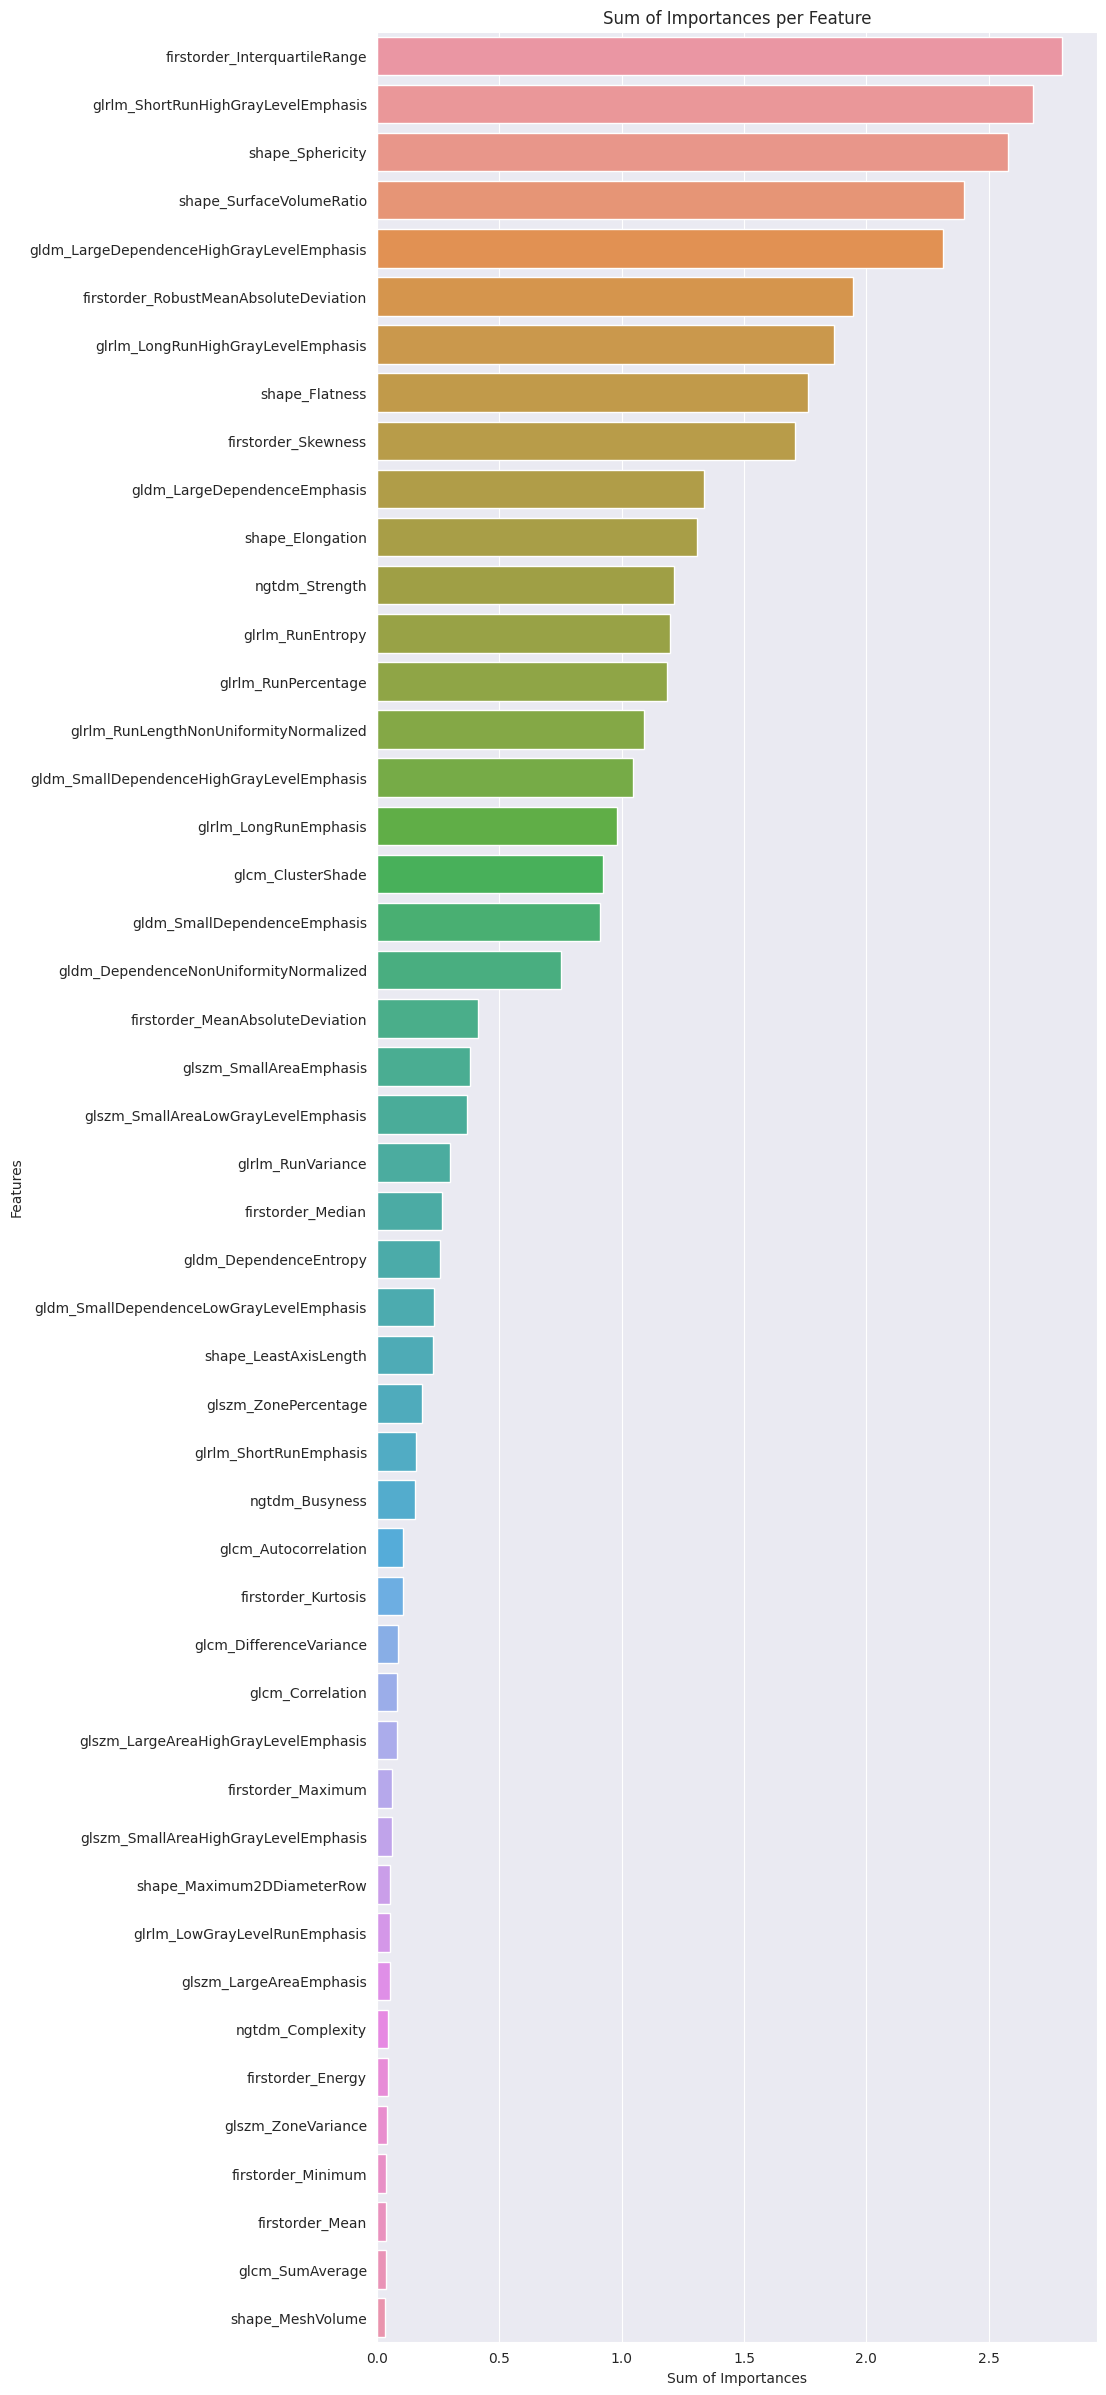

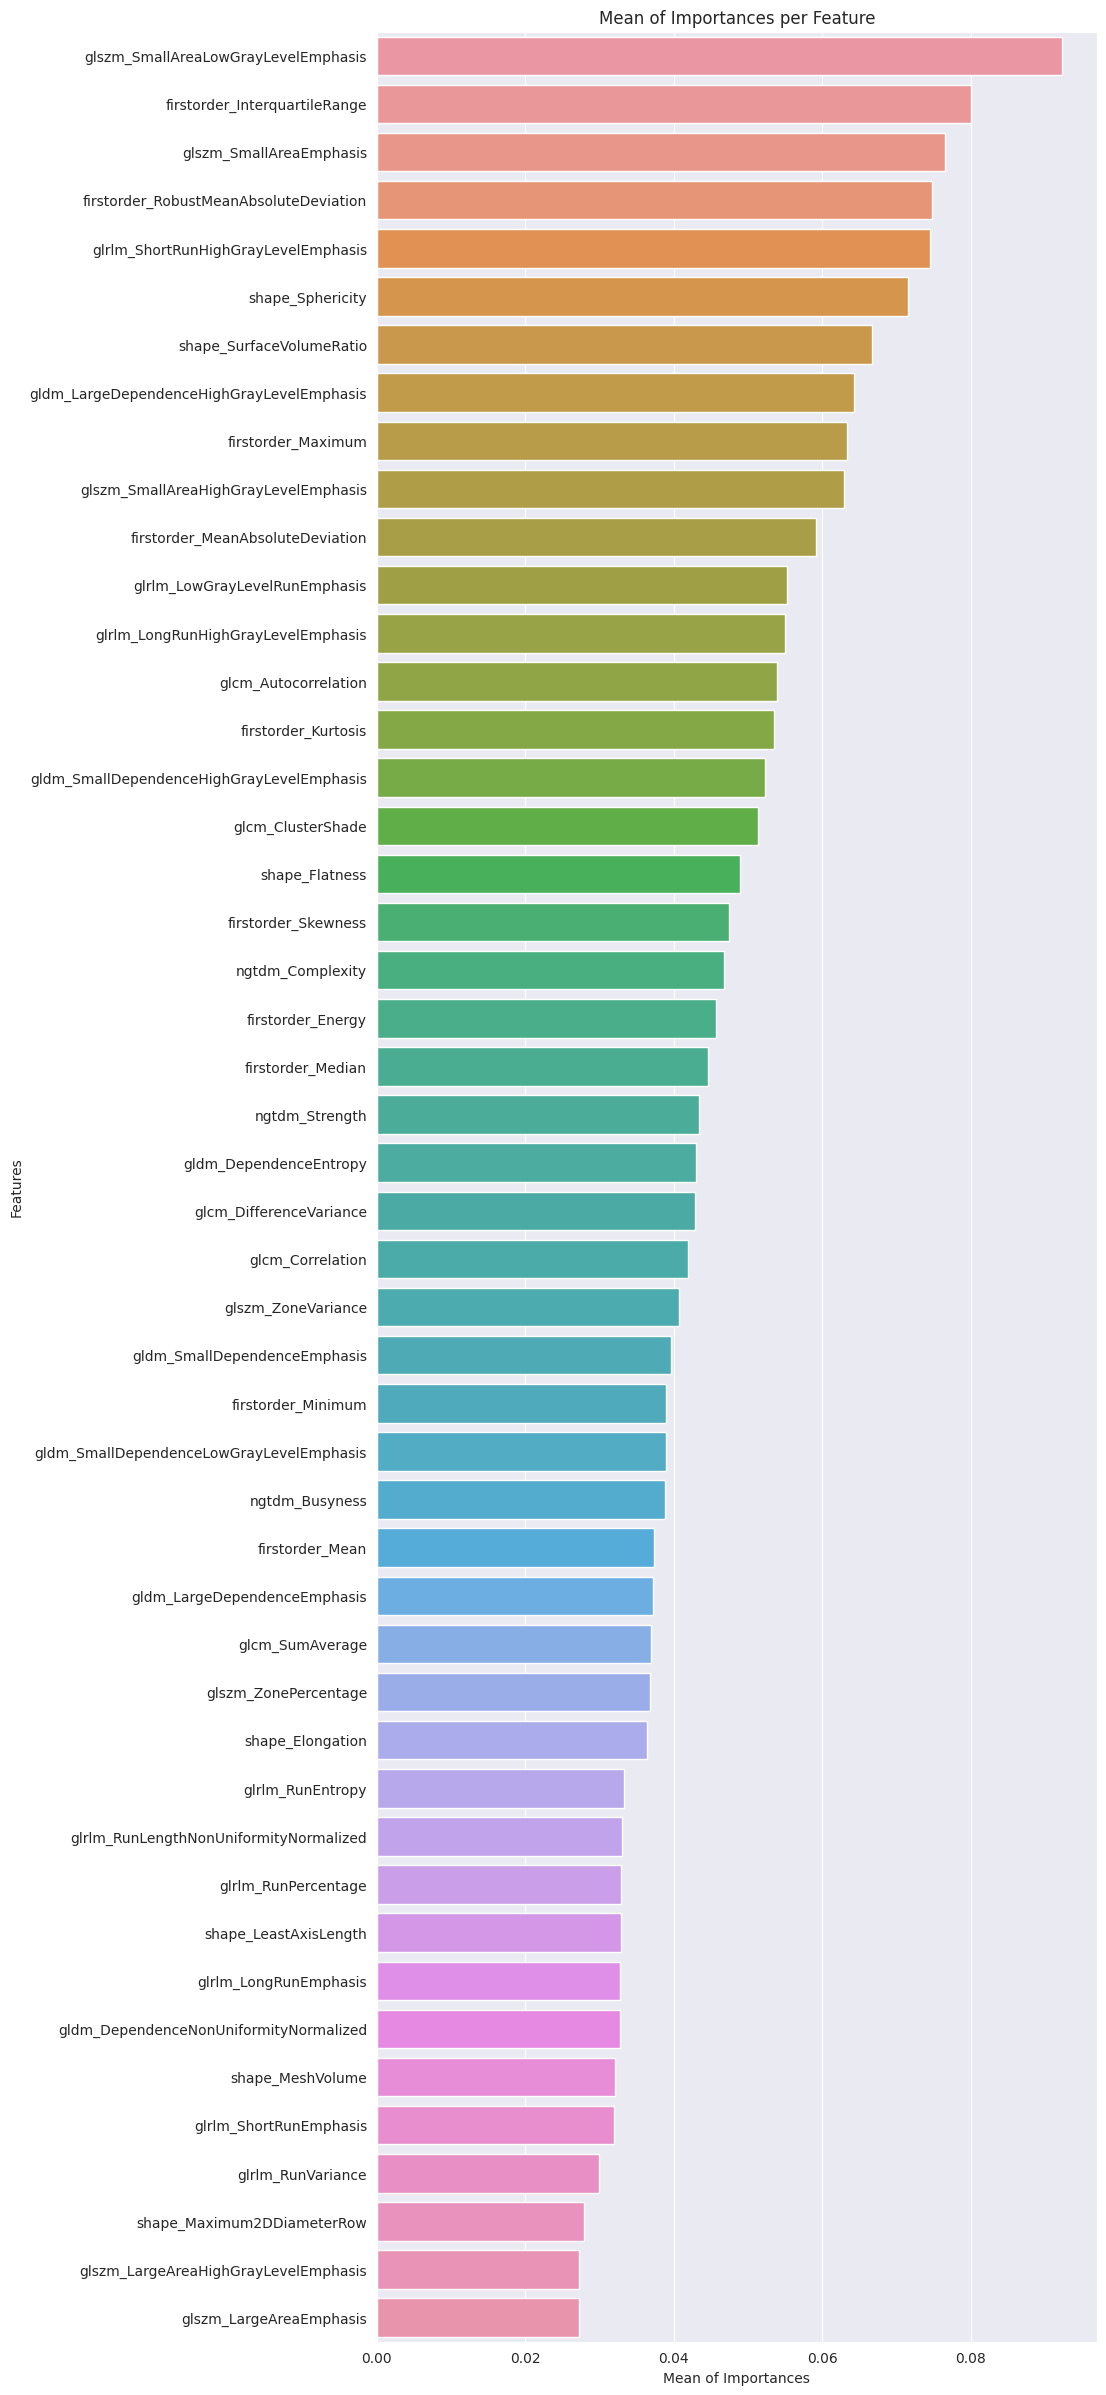

In [30]:
# Calculate the sum of importances per feature
feature_importance_sum = {}
for features, importance in best_features_RF:
    if features in feature_importance_sum:
        feature_importance_sum[features] += importance
    else:
        feature_importance_sum[features] = importance

# Convert the dictionary to lists for plotting
features = list(feature_importance_sum.keys())
importance_sum = list(feature_importance_sum.values())

# Sort the lists in descending order of importance_sum
sorted_indices = sorted(range(len(importance_sum)), key=lambda k: importance_sum[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_sum_sorted = [importance_sum[i] for i in sorted_indices]

# Plot the sum of importances per feature
plt.figure(figsize=(12, 30))
sns.barplot(x=importance_sum_sorted, y=features_sorted)
plt.xlabel('Sum of Importances')
plt.ylabel('Features')
plt.title('Sum of Importances per Feature')
plt.subplots_adjust(left=0.3)
plt.show()

feature_importance_mean = {}
feature_importance_sd = {}
feature_importance_ci = {}

for features, importance in best_features_RF:
    if features in feature_importance_mean:
        feature_importance_mean[features].append(importance)
    else:
        feature_importance_mean[features] = [importance]

feature_importance_mean_ = {feature: np.mean(importances) for feature, importances in feature_importance_mean.items()}
feature_importance_sd = {feature: np.std(importances) for feature, importances in feature_importance_mean.items()}

# Convert the dictionary to lists for plotting
features = list(feature_importance_mean_.keys())
importance_mean = list(feature_importance_mean_.values())

# Sort the lists in descending order of importance_mean
sorted_indices = sorted(range(len(importance_mean)), key=lambda k: importance_mean[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_mean_sorted = [importance_mean[i] for i in sorted_indices]

# Plot the mean of importances per feature
plt.figure(figsize=(12, 30))
sns.barplot(x=importance_mean_sorted, y=features_sorted)
plt.xlabel('Mean of Importances')
plt.ylabel('Features')
plt.title('Mean of Importances per Feature')

# Adjust the position of the figure
plt.subplots_adjust(left=0.3)

plt.show()

In [31]:
p_value_sum = {}
p_value_mean = {}
p_value_sd = {}

for p_value_dict in p_value:
    for feature, value in p_value_dict.items():
        if feature in p_value_sum:
            p_value_sum[feature] += value
        else:
            p_value_sum[feature] = value

# Calculate the mean and standard deviation of p-values per feature
for feature in p_value_sum:
    p_values_per_feature = [p_value_dict[feature] for p_value_dict in p_value if feature in p_value_dict]
    p_value_mean[feature] = np.mean(p_values_per_feature)
    p_value_sd[feature] = np.std(p_values_per_feature)

print('p_value_mean', p_value_mean)

p_value_mean {'shape_Sphericity': 1.6989878998720047e-08, 'shape_LeastAxisLength': 0.00152006612744453, 'firstorder_Median': 0.2322503151071418, 'shape_SurfaceVolumeRatio': 1.2641548606147338e-08, 'shape_Flatness': 2.4351297447469278e-05, 'glrlm_ShortRunHighGrayLevelEmphasis': 2.868037669812981e-06, 'gldm_LargeDependenceHighGrayLevelEmphasis': 7.1712495345269785e-06, 'shape_Elongation': 5.3046220023814455e-05, 'glrlm_LongRunHighGrayLevelEmphasis': 2.85803305571285e-05, 'firstorder_Skewness': 0.013945919770663666, 'glrlm_RunEntropy': 4.9185602608819765e-06, 'gldm_LargeDependenceEmphasis': 2.796487864389888e-06, 'glrlm_RunPercentage': 6.281361669995924e-06, 'glcm_ClusterShade': 0.03463574787487064, 'glrlm_RunLengthNonUniformityNormalized': 9.950577519759421e-06, 'firstorder_InterquartileRange': 0.047397274020059395, 'glrlm_LongRunEmphasis': 3.085780220141314e-05, 'gldm_SmallDependenceEmphasis': 0.00019912358092499162, 'glrlm_ShortRunEmphasis': 2.790153841488644e-05, 'gldm_DependenceNonUn

In [32]:
print('p_value_sd', p_value_sd)

p_value_sd {'shape_Sphericity': 4.711554714493575e-08, 'shape_LeastAxisLength': 0.0020994212714331136, 'firstorder_Median': 0.08222821531204479, 'shape_SurfaceVolumeRatio': 2.8073867336962688e-08, 'shape_Flatness': 5.777083728394784e-05, 'glrlm_ShortRunHighGrayLevelEmphasis': 4.995900444062914e-06, 'gldm_LargeDependenceHighGrayLevelEmphasis': 1.3329613007372974e-05, 'shape_Elongation': 0.000108500659256053, 'glrlm_LongRunHighGrayLevelEmphasis': 0.00010022515020291115, 'firstorder_Skewness': 0.011733970969218596, 'glrlm_RunEntropy': 1.0781450743137927e-05, 'gldm_LargeDependenceEmphasis': 4.511456376294803e-06, 'glrlm_RunPercentage': 9.643788346569239e-06, 'glcm_ClusterShade': 0.015449230519717338, 'glrlm_RunLengthNonUniformityNormalized': 1.7723131068865884e-05, 'firstorder_InterquartileRange': 0.04475954613057476, 'glrlm_LongRunEmphasis': 5.8982266201984574e-05, 'gldm_SmallDependenceEmphasis': 0.00025624338653006785, 'glrlm_ShortRunEmphasis': 1.0174916226745076e-05, 'gldm_DependenceNon

In [33]:
print('p_value_sum', p_value_sum)

p_value_sum {'shape_Sphericity': 6.116356439539216e-07, 'shape_LeastAxisLength': 0.01064046289211171, 'firstorder_Median': 1.393501890642851, 'shape_SurfaceVolumeRatio': 4.5509574982130425e-07, 'shape_Flatness': 0.0008766467081088941, 'glrlm_ShortRunHighGrayLevelEmphasis': 0.00010324935611326732, 'gldm_LargeDependenceHighGrayLevelEmphasis': 0.00025816498324297127, 'shape_Elongation': 0.00190966392085732, 'glrlm_LongRunHighGrayLevelEmphasis': 0.000971731238942369, 'firstorder_Skewness': 0.5020531117438919, 'glrlm_RunEntropy': 0.00017706816939175115, 'gldm_LargeDependenceEmphasis': 0.000100673563118036, 'glrlm_RunPercentage': 0.0002261290201198533, 'glcm_ClusterShade': 0.6234434617476716, 'glrlm_RunLengthNonUniformityNormalized': 0.00032836905815206103, 'firstorder_InterquartileRange': 1.6589045907020787, 'glrlm_LongRunEmphasis': 0.000925734066042394, 'gldm_SmallDependenceEmphasis': 0.004579842361274808, 'glrlm_ShortRunEmphasis': 0.0001395076920744322, 'gldm_DependenceNonUniformityNormal

## f 80

In [21]:
# Store the scores and metrics
scores_rf = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
scores_svc = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI':[], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
best_features_RF = []
for name, pipeline in pipelines.items():
    # Initialize lists to store scores for each fold
    fold_acc = []
    fold_auc_tot = []
    fold_auc_class = []
    sensi = []
    speci = []
    features = []
    p_value = []
    feat = []
    value = []
    for train_index, test_index in cv_outer.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_normed = scaler.fit_transform(X_train)
        X_test_normed = scaler.transform(X_test)

        X_train_scal = pd.DataFrame(X_train_normed, columns=X_train.columns, index=X_train.index)
        X_test_scal = pd.DataFrame(X_test_normed, columns=X_test.columns, index=X_test.index)

        #select the best 15 features
        selected_feature_names = mrmr_classif(X_train_scal, y_train, K=80)
        X_train_new = X_train_scal[selected_feature_names]
        X_test_new = X_test_scal[selected_feature_names]
        f_scores, p_values = f_classif(X_train_new, y_train)
        feature_p_values = dict(zip(selected_feature_names, p_values))
        p_value.append(feature_p_values)

        cv_inner = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=seed)
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_inner, scoring='roc_auc_ovr', error_score="raise")
        grid_search.fit(X_train_new, y_train)
        clf = grid_search.best_estimator_
        print(clf)
        clf.fit(X_train_new, y_train)
        y_pred = clf.predict(X_test_new)
        accuracy = accuracy_score(y_test, y_pred)
        num_classes = len(np.unique(y_test))
        cm = confusion_matrix(y_test, y_pred)
        specificity = calculate_specificity(cm)
        sensitivity = calculate_sensitivity(cm)
        # Print the results

        accuracy = accuracy_score(y_test, y_pred)
        fold_acc.append(accuracy)

        # Calculate AUC score
        auc_tot = multiclass_roc_auc_score(y_test, y_pred)
        fold_auc_tot.append(auc_tot)

        auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
        fold_auc_class.append(auc_class)

        speci.append(specificity)
        sensi.append(sensitivity)

        print('Auc Score', multiclass_roc_auc_score(y_test, y_pred))
        print('Auc Score OvR', class_vs_rest_roc_auc_score(y_test, y_pred))

        if name == 'rf':
            params_rf = grid_search.best_estimator_
            feature_importance = clf.named_steps['clf'].feature_importances_
            for featureses, importance in zip(selected_feature_names, feature_importance):
                best_features_RF.append((featureses, importance))
        else:
            continue
    # Calculate average scores across folds
    if name == 'rf':
        #acc
        avg_acc = np.mean(fold_acc)
        scores_rf['acc'].append(avg_acc)
        scores_rf['acc'] = scores_rf['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_rf['CI_acc'].append(ci)
        scores_rf['SD_acc'].append(np.std(fold_acc))

        #auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_rf['auc_tot'].append(avg_auc_tot)
        scores_rf['auc_tot'] = scores_rf['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_rf['CI_auc_tot'].append(ci)
        scores_rf['SD_auc_tot'].append(np.std(fold_auc_tot))

        #auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['CI_auc_class'].append(CI_auc_class)

        #sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Sen_CI'].append(CI_sen_class)

        #specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Spe_mean'].append(avg_speci_class)
        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Spe_CI'].append(CI_spe_class)

    elif name == 'svc':
        # acc
        avg_acc = np.mean(fold_acc)
        scores_svc['acc'].append(avg_acc)
        scores_svc['acc'] = scores_svc['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_svc['CI_acc'].append(ci)
        scores_svc['SD_acc'].append(np.std(fold_acc))

        # auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_svc['auc_tot'].append(avg_auc_tot)
        scores_svc['auc_tot'] = scores_svc['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_svc['CI_auc_tot'].append(ci)
        scores_svc['SD_auc_tot'].append(np.std(fold_auc_tot))

        # auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['CI_auc_class'].append(CI_auc_class)

        # sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Sen_CI'].append(CI_sen_class)

        # specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Spe_mean'].append(avg_speci_class)

        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Spe_CI'].append(CI_spe_class)


100%|██████████| 80/80 [00:30<00:00,  2.60it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6732020722170278
Auc Score OvR {0: 0.7283549783549784, 1: 0.6047758284600391, 2: 0.6864754098360656}


100%|██████████| 80/80 [00:26<00:00,  3.06it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6200835615560953
Auc Score OvR {0: 0.5400432900432901, 1: 0.5428849902534113, 2: 0.7773224043715847}


100%|██████████| 80/80 [00:24<00:00,  3.32it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7084925033038241
Auc Score OvR {0: 0.7510822510822511, 1: 0.6731132075471699, 2: 0.7012820512820512}


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5643388582067826
Auc Score OvR {0: 0.5216450216450216, 1: 0.5386792452830188, 2: 0.6326923076923077}


100%|██████████| 80/80 [00:24<00:00,  3.30it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6974212894024214
Auc Score OvR {0: 0.7846320346320347, 1: 0.619811320754717, 2: 0.6878205128205128}


100%|██████████| 80/80 [00:25<00:00,  3.16it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6867612753446742
Auc Score OvR {0: 0.7898009950248756, 1: 0.5692007797270955, 2: 0.7012820512820512}


100%|██████████| 80/80 [00:24<00:00,  3.29it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.6276469897766993
Auc Score OvR {0: 0.4837662337662338, 1: 0.6047758284600391, 2: 0.7943989071038251}


100%|██████████| 80/80 [00:26<00:00,  2.97it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6403599901946178
Auc Score OvR {0: 0.6525974025974026, 1: 0.5492202729044834, 2: 0.7192622950819672}


100%|██████████| 80/80 [00:25<00:00,  3.17it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6266893483874617
Auc Score OvR {0: 0.7207792207792209, 1: 0.6169811320754718, 2: 0.5423076923076923}


100%|██████████| 80/80 [00:26<00:00,  3.02it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.53541270050704
Auc Score OvR {0: 0.6796536796536796, 1: 0.45094339622641505, 2: 0.4756410256410256}


100%|██████████| 80/80 [00:24<00:00,  3.21it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6613311217084803
Auc Score OvR {0: 0.6904761904761906, 1: 0.5537735849056604, 2: 0.7397435897435898}


100%|██████████| 80/80 [00:24<00:00,  3.22it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5903306790384559
Auc Score OvR {0: 0.5783582089552238, 1: 0.5599415204678362, 2: 0.6326923076923077}


100%|██████████| 80/80 [00:24<00:00,  3.29it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.7238676118457539
Auc Score OvR {0: 0.7543290043290043, 1: 0.6481481481481481, 2: 0.7691256830601094}


100%|██████████| 80/80 [00:26<00:00,  3.02it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.61320877883288
Auc Score OvR {0: 0.5930735930735931, 1: 0.5272904483430798, 2: 0.7192622950819672}


100%|██████████| 80/80 [00:25<00:00,  3.08it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.4526791342829078
Auc Score OvR {0: 0.35930735930735924, 1: 0.3660377358490566, 2: 0.6326923076923077}


100%|██████████| 80/80 [00:24<00:00,  3.30it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6184040278379901
Auc Score OvR {0: 0.6980519480519481, 1: 0.5193396226415095, 2: 0.6378205128205128}


100%|██████████| 80/80 [00:26<00:00,  3.05it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.7240669707650841
Auc Score OvR {0: 0.773809523809524, 1: 0.6419811320754718, 2: 0.7564102564102566}


100%|██████████| 80/80 [00:26<00:00,  3.01it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6171141406477881
Auc Score OvR {0: 0.5410447761194029, 1: 0.550682261208577, 2: 0.7596153846153846}


100%|██████████| 80/80 [00:25<00:00,  3.19it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.6585117579509296
Auc Score OvR {0: 0.6266233766233766, 1: 0.6125730994152047, 2: 0.7363387978142077}


100%|██████████| 80/80 [00:24<00:00,  3.23it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.652960867837198
Auc Score OvR {0: 0.6082251082251082, 1: 0.621832358674464, 2: 0.7288251366120218}


100%|██████████| 80/80 [00:26<00:00,  3.04it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.6215831338472847
Auc Score OvR {0: 0.6677489177489178, 1: 0.5476415094339622, 2: 0.6493589743589744}


100%|██████████| 80/80 [00:26<00:00,  3.01it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6503072922884244
Auc Score OvR {0: 0.6266233766233766, 1: 0.6448113207547169, 2: 0.6794871794871796}


100%|██████████| 80/80 [00:26<00:00,  3.06it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.5938237339180735
Auc Score OvR {0: 0.6645021645021645, 1: 0.500943396226415, 2: 0.6160256410256411}


100%|██████████| 80/80 [00:25<00:00,  3.15it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.609731370139854
Auc Score OvR {0: 0.691542288557214, 1: 0.5350877192982456, 2: 0.6025641025641026}


100%|██████████| 80/80 [00:25<00:00,  3.20it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6694742320281578
Auc Score OvR {0: 0.6904761904761906, 1: 0.6403508771929824, 2: 0.6775956284153005}


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6749187576768825
Auc Score OvR {0: 0.6569264069264069, 1: 0.6232943469785575, 2: 0.7445355191256832}


100%|██████████| 80/80 [00:24<00:00,  3.30it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6628408279351676
Auc Score OvR {0: 0.6645021645021645, 1: 0.6009433962264151, 2: 0.7230769230769232}


100%|██████████| 80/80 [00:24<00:00,  3.26it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.5368611472385058
Auc Score OvR {0: 0.5811688311688311, 1: 0.5287735849056604, 2: 0.5006410256410256}


100%|██████████| 80/80 [00:25<00:00,  3.20it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6692683103060463
Auc Score OvR {0: 0.6493506493506493, 1: 0.6103773584905661, 2: 0.7480769230769232}


100%|██████████| 80/80 [00:25<00:00,  3.08it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.5992244318965975
Auc Score OvR {0: 0.5932835820895523, 1: 0.5165692007797271, 2: 0.6878205128205128}


100%|██████████| 80/80 [00:25<00:00,  3.09it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5729998811678421
Auc Score OvR {0: 0.44588744588744583, 1: 0.5955165692007798, 2: 0.6775956284153005}


100%|██████████| 80/80 [00:25<00:00,  3.12it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.602380509700038
Auc Score OvR {0: 0.6493506493506493, 1: 0.5799220272904483, 2: 0.5778688524590164}


100%|██████████| 80/80 [00:24<00:00,  3.26it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6423462805538279
Auc Score OvR {0: 0.6904761904761906, 1: 0.5570754716981132, 2: 0.6794871794871796}


100%|██████████| 80/80 [00:25<00:00,  3.15it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6691301361112681
Auc Score OvR {0: 0.6645021645021645, 1: 0.594811320754717, 2: 0.7480769230769232}


100%|██████████| 80/80 [00:24<00:00,  3.27it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6839946740890137
Auc Score OvR {0: 0.6645021645021645, 1: 0.625943396226415, 2: 0.7615384615384615}


100%|██████████| 80/80 [00:24<00:00,  3.28it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5432368447162895
Auc Score OvR {0: 0.5024875621890547, 1: 0.47465886939571145, 2: 0.6525641025641025}


100%|██████████| 80/80 [00:24<00:00,  3.22it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6509623710155779
Auc Score OvR {0: 0.6904761904761906, 1: 0.567738791423002, 2: 0.694672131147541}


100%|██████████| 80/80 [00:25<00:00,  3.11it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6509342884450736
Auc Score OvR {0: 0.6753246753246754, 1: 0.5336257309941521, 2: 0.7438524590163934}


100%|██████████| 80/80 [00:25<00:00,  3.11it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.599001784379143
Auc Score OvR {0: 0.5887445887445888, 1: 0.5287735849056604, 2: 0.6794871794871796}


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5316803217746614
Auc Score OvR {0: 0.3896103896103896, 1: 0.500943396226415, 2: 0.7044871794871794}


100%|██████████| 80/80 [00:26<00:00,  3.07it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.7053188425829937
Auc Score OvR {0: 0.7619047619047621, 1: 0.5976415094339622, 2: 0.7564102564102566}


100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6431631205197584
Auc Score OvR {0: 0.7524875621890547, 1: 0.5058479532163743, 2: 0.6711538461538462}


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6531070735844967
Auc Score OvR {0: 0.6114718614718614, 1: 0.6033138401559455, 2: 0.7445355191256832}


100%|██████████| 80/80 [00:26<00:00,  3.06it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6384153759405412
Auc Score OvR {0: 0.6937229437229437, 1: 0.4858674463937621, 2: 0.7356557377049181}


100%|██████████| 80/80 [00:24<00:00,  3.27it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6272719942531263
Auc Score OvR {0: 0.8863636363636364, 1: 0.46981132075471693, 2: 0.5256410256410257}


100%|██████████| 80/80 [00:24<00:00,  3.21it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6151157542666977
Auc Score OvR {0: 0.6493506493506493, 1: 0.5415094339622641, 2: 0.6544871794871795}


100%|██████████| 80/80 [00:25<00:00,  3.18it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6619582723356308
Auc Score OvR {0: 0.6038961038961039, 1: 0.6037735849056604, 2: 0.7782051282051281}


100%|██████████| 80/80 [00:25<00:00,  3.16it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6558618103066912
Auc Score OvR {0: 0.7375621890547265, 1: 0.5755360623781677, 2: 0.6544871794871795}


100%|██████████| 80/80 [00:24<00:00,  3.25it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6958559913334145
Auc Score OvR {0: 0.6980519480519481, 1: 0.6033138401559455, 2: 0.7862021857923498}


100%|██████████| 80/80 [00:26<00:00,  2.98it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5985380220712404
Auc Score OvR {0: 0.7132034632034633, 1: 0.45467836257309935, 2: 0.6277322404371586}


100%|██████████| 80/80 [00:25<00:00,  3.12it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5004042079513777
Auc Score OvR {0: 0.37445887445887444, 1: 0.4254716981132075, 2: 0.7012820512820512}


100%|██████████| 80/80 [00:25<00:00,  3.18it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6234597163842447
Auc Score OvR {0: 0.6417748917748918, 1: 0.5792452830188679, 2: 0.6493589743589744}


100%|██████████| 80/80 [00:25<00:00,  3.14it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.7521642403717875
Auc Score OvR {0: 0.8712121212121212, 1: 0.6070754716981132, 2: 0.7782051282051281}


100%|██████████| 80/80 [00:24<00:00,  3.33it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6290765023286626
Auc Score OvR {0: 0.6467661691542288, 1: 0.5058479532163743, 2: 0.7346153846153846}


100%|██████████| 80/80 [00:25<00:00,  3.11it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6013320130375063
Auc Score OvR {0: 0.5735930735930735, 1: 0.4858674463937621, 2: 0.7445355191256832}


100%|██████████| 80/80 [00:23<00:00,  3.44it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.639960055656058
Auc Score OvR {0: 0.6753246753246754, 1: 0.5662768031189084, 2: 0.6782786885245902}


100%|██████████| 80/80 [00:22<00:00,  3.55it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6015247331285067
Auc Score OvR {0: 0.7391774891774892, 1: 0.44103773584905664, 2: 0.6243589743589744}


100%|██████████| 80/80 [00:24<00:00,  3.32it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6024866119205742
Auc Score OvR {0: 0.5400432900432901, 1: 0.5443396226415095, 2: 0.7230769230769232}


100%|██████████| 80/80 [00:24<00:00,  3.25it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.665868827189582
Auc Score OvR {0: 0.7997835497835498, 1: 0.5132075471698113, 2: 0.6846153846153846}


100%|██████████| 80/80 [00:22<00:00,  3.52it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6683914920822488
Auc Score OvR {0: 0.6467661691542288, 1: 0.5769980506822612, 2: 0.7814102564102565}


100%|██████████| 80/80 [00:24<00:00,  3.20it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6399460143708059
Auc Score OvR {0: 0.6677489177489178, 1: 0.5492202729044834, 2: 0.7028688524590165}


100%|██████████| 80/80 [00:23<00:00,  3.46it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6361313672213873
Auc Score OvR {0: 0.7997835497835498, 1: 0.496588693957115, 2: 0.6120218579234972}


100%|██████████| 80/80 [00:24<00:00,  3.23it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.7029263189640548
Auc Score OvR {0: 0.6753246753246754, 1: 0.635377358490566, 2: 0.798076923076923}


100%|██████████| 80/80 [00:24<00:00,  3.22it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6334518207159716
Auc Score OvR {0: 0.645021645021645, 1: 0.5976415094339622, 2: 0.6576923076923077}


100%|██████████| 80/80 [00:24<00:00,  3.26it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.643547752038318
Auc Score OvR {0: 0.6341991341991342, 1: 0.5599056603773584, 2: 0.7365384615384616}


100%|██████████| 80/80 [00:25<00:00,  3.20it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6525263918822443
Auc Score OvR {0: 0.691542288557214, 1: 0.5365497076023392, 2: 0.7294871794871794}


100%|██████████| 80/80 [00:23<00:00,  3.39it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6248276829956438
Auc Score OvR {0: 0.5735930735930735, 1: 0.5399610136452242, 2: 0.7609289617486339}


100%|██████████| 80/80 [00:23<00:00,  3.46it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6975936176755848
Auc Score OvR {0: 0.6645021645021645, 1: 0.6666666666666666, 2: 0.7616120218579234}


100%|██████████| 80/80 [00:22<00:00,  3.48it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6892315755523303
Auc Score OvR {0: 0.8333333333333334, 1: 0.5632075471698114, 2: 0.6711538461538462}


100%|██████████| 80/80 [00:24<00:00,  3.30it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6576920458995931
Auc Score OvR {0: 0.6980519480519481, 1: 0.5570754716981132, 2: 0.717948717948718}


100%|██████████| 80/80 [00:23<00:00,  3.45it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6778357910433384
Auc Score OvR {0: 0.7283549783549784, 1: 0.5820754716981132, 2: 0.7230769230769232}


100%|██████████| 80/80 [00:24<00:00,  3.32it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6374460729789351
Auc Score OvR {0: 0.5634328358208955, 1: 0.5258284600389864, 2: 0.8230769230769232}


In [22]:
for name, score in scores_svc.items():
    print('svc', f'{name}: {score}')

for name, score in scores_rf.items():
    print('rf', f'{name}: {score}')

svc acc: 0.3721461187214612
svc SD_acc: [0.048807210790940525]
svc CI_acc: [(0.3553978818458319, 0.3888943555970905)]
svc auc_tot: 0.6418058298388281
svc SD_auc_tot: [0.04551223690211834]
svc CI_auc_tot: [(0.6261882661218307, 0.6574233935558255)]
svc auc_class: [{0: 0.6704433280925818, 1: 0.545217786196215, 2: 0.7097563752276868}]
svc SD_auc_class: [{0: 0.10698826157076527, 1: 0.053733254726479114, 2: 0.06025572612004181}]
svc CI_auc_class: [{0: (0.6337302129880495, 0.707156443197114), 1: (0.5267791730553746, 0.5636563993370554), 2: (0.6890795703495267, 0.7304331801058468)}]
svc Sen_mean: [{0: 67.92328042328043, 1: 24.145896420529546, 2: 75.92592592592592}]
svc Sen_CI: [{0: (61.397049512342, 74.44951133421887), 1: (21.983842058353403, 26.30795078270569), 2: (72.02171921061105, 79.8301326412408)}]
svc Sen_SD: [{0: 19.018546853968786, 1: 6.300594132971289, 2: 11.377522394793484}]
svc Spe_mean: [{0: 66.16538519523594, 1: 84.89766081871345, 2: 66.0253491196114}]
svc Spe_CI: [{0: (64.196319

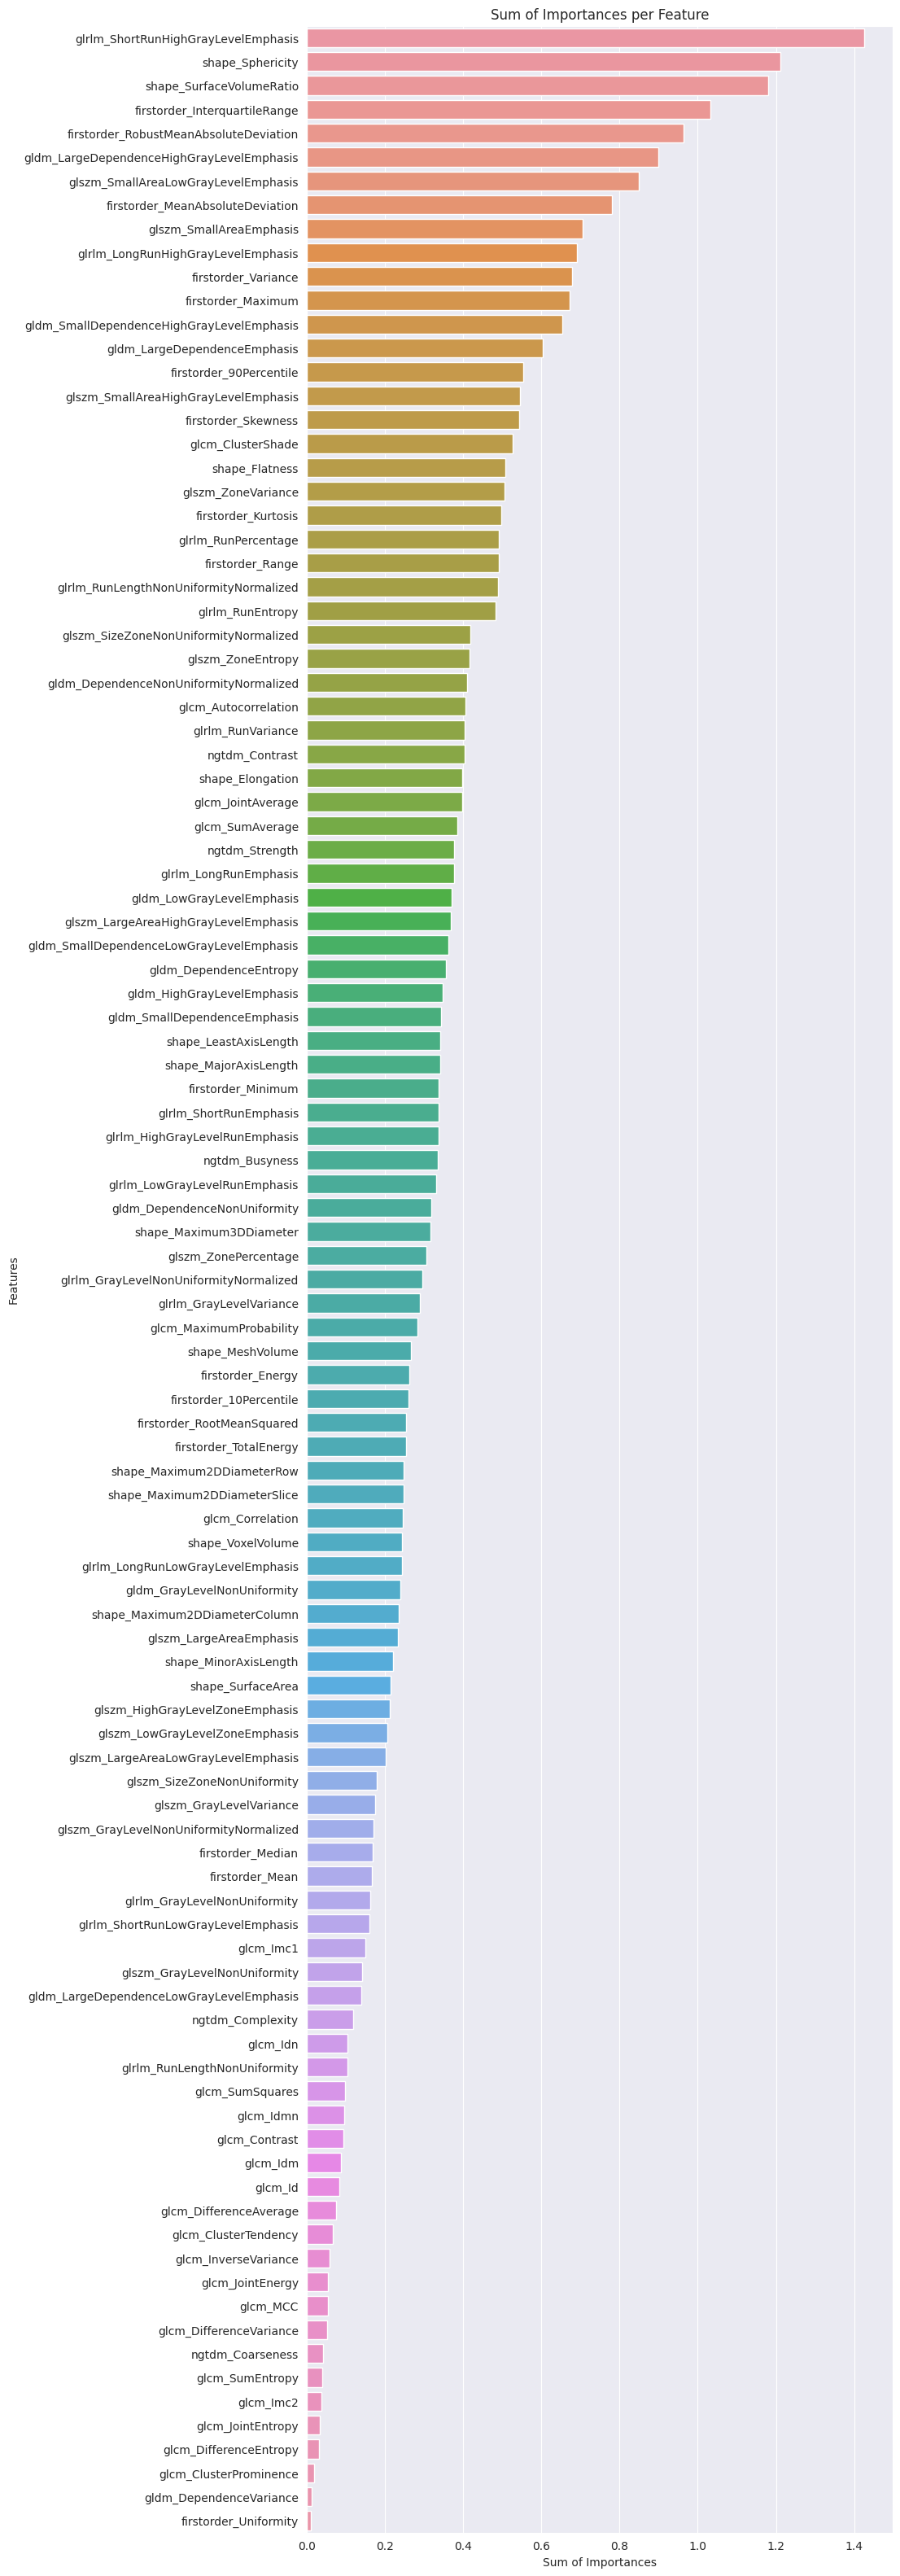

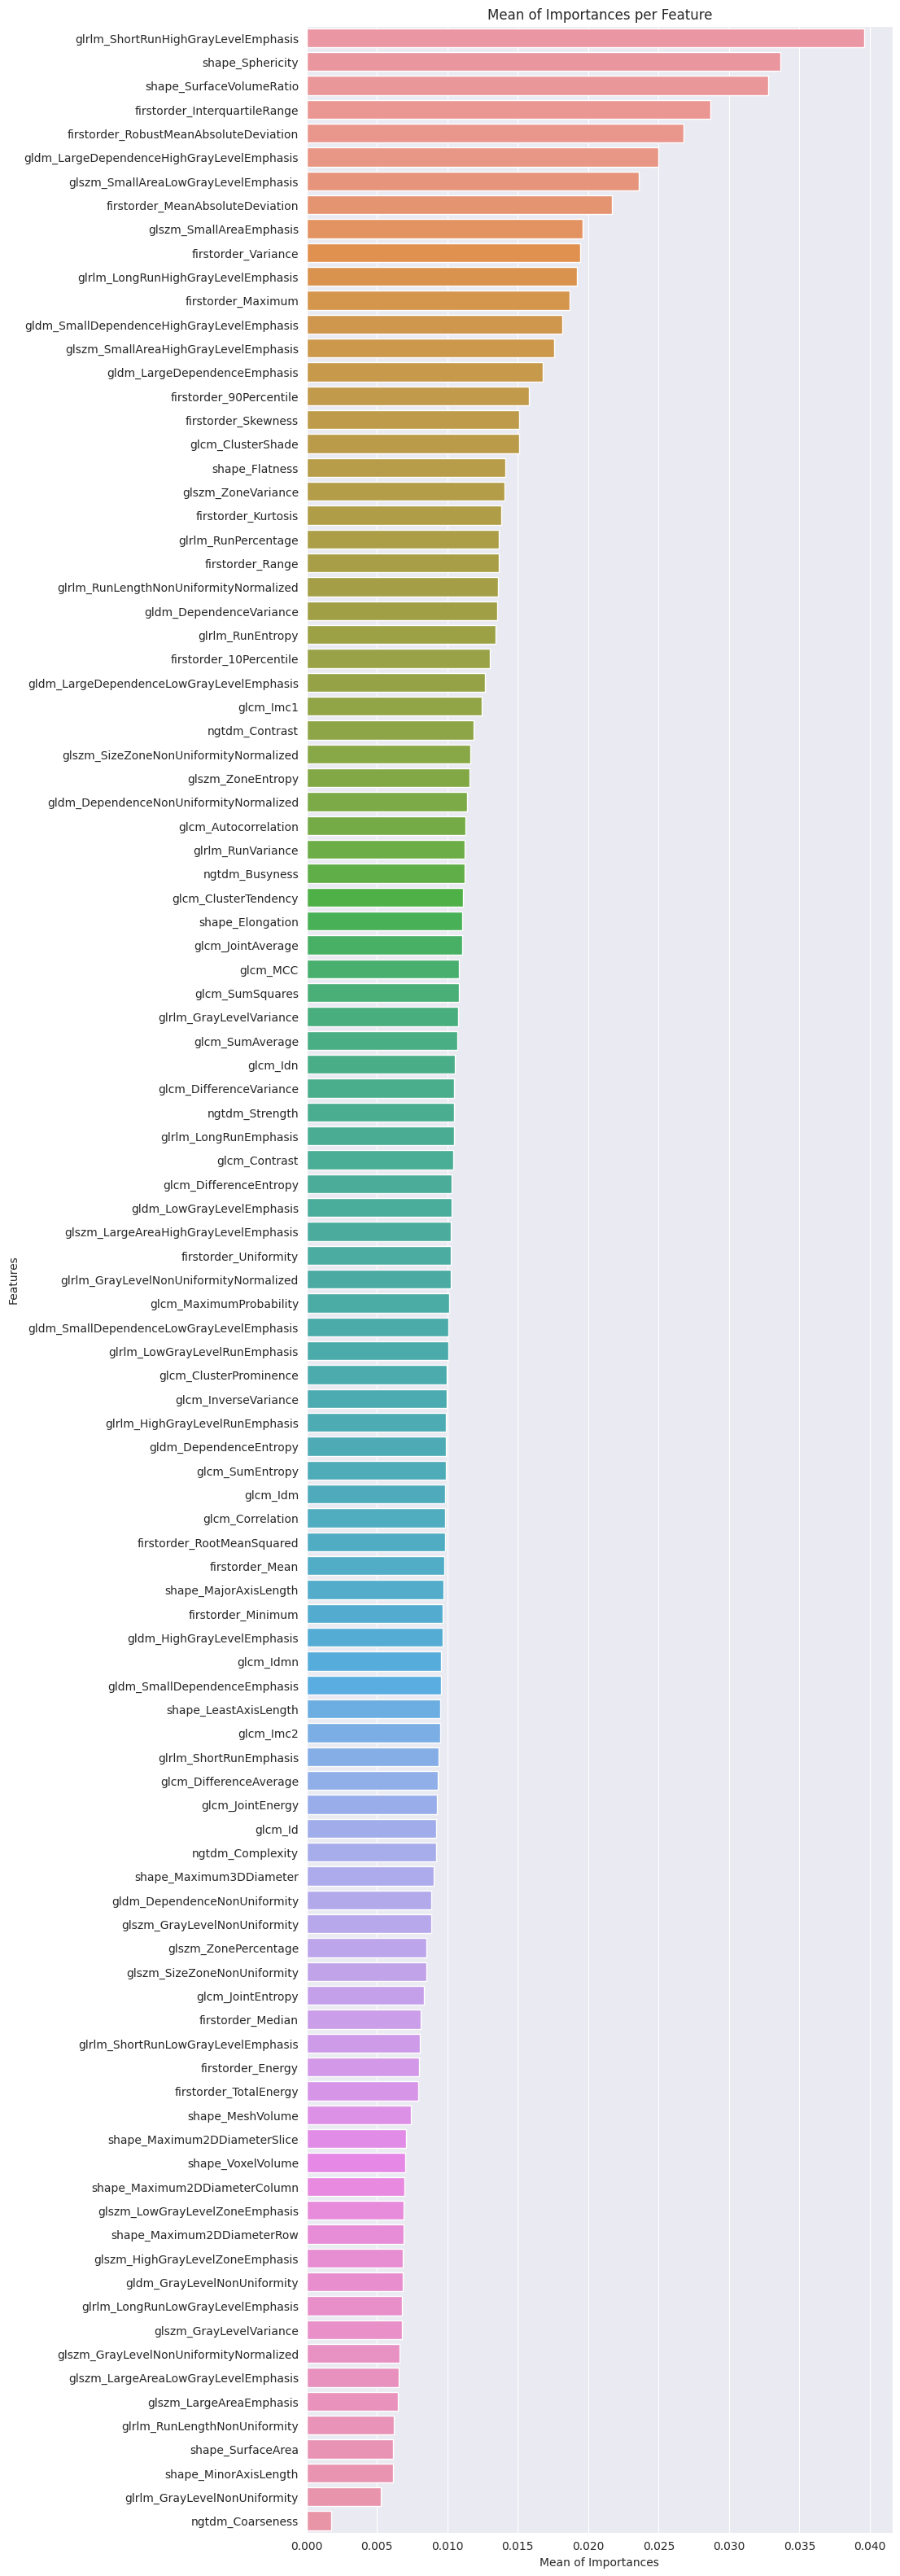

In [36]:

# Calculate the sum of importances per feature
feature_importance_sum = {}
for features, importance in best_features_RF:
    if features in feature_importance_sum:
        feature_importance_sum[features] += importance
    else:
        feature_importance_sum[features] = importance

# Convert the dictionary to lists for plotting
features = list(feature_importance_sum.keys())
importance_sum = list(feature_importance_sum.values())

# Sort the lists in descending order of importance_sum
sorted_indices = sorted(range(len(importance_sum)), key=lambda k: importance_sum[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_sum_sorted = [importance_sum[i] for i in sorted_indices]

# Plot the sum of importances per feature
plt.figure(figsize=(12, 40))
sns.barplot(x=importance_sum_sorted, y=features_sorted)
plt.xlabel('Sum of Importances')
plt.ylabel('Features')
plt.title('Sum of Importances per Feature')
plt.subplots_adjust(left=0.3)
plt.show()

feature_importance_mean = {}
feature_importance_sd = {}
feature_importance_ci = {}

for features, importance in best_features_RF:
    if features in feature_importance_mean:
        feature_importance_mean[features].append(importance)
    else:
        feature_importance_mean[features] = [importance]

feature_importance_mean_ = {feature: np.mean(importances) for feature, importances in feature_importance_mean.items()}
feature_importance_sd = {feature: np.std(importances) for feature, importances in feature_importance_mean.items()}

# Convert the dictionary to lists for plotting
features = list(feature_importance_mean_.keys())
importance_mean = list(feature_importance_mean_.values())

# Sort the lists in descending order of importance_mean
sorted_indices = sorted(range(len(importance_mean)), key=lambda k: importance_mean[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_mean_sorted = [importance_mean[i] for i in sorted_indices]

# Plot the mean of importances per feature
plt.figure(figsize=(12, 40))
sns.barplot(x=importance_mean_sorted, y=features_sorted)
plt.xlabel('Mean of Importances')
plt.ylabel('Features')
plt.title('Mean of Importances per Feature')

# Adjust the position of the figure
plt.subplots_adjust(left=0.3)

plt.show()

In [37]:

p_value_sum = {}
p_value_mean = {}
p_value_sd = {}

for p_value_dict in p_value:
    for feature, value in p_value_dict.items():
        if feature in p_value_sum:
            p_value_sum[feature] += value
        else:
            p_value_sum[feature] = value

# Calculate the mean and standard deviation of p-values per feature
for feature in p_value_sum:
    p_values_per_feature = [p_value_dict[feature] for p_value_dict in p_value if feature in p_value_dict]
    p_value_mean[feature] = np.mean(p_values_per_feature)
    p_value_sd[feature] = np.std(p_values_per_feature)

print('p_value_mean', p_value_mean)

p_value_mean {'shape_Sphericity': 1.6989878998720047e-08, 'shape_LeastAxisLength': 0.0023920191556815987, 'firstorder_Median': 0.22147755428633867, 'shape_SurfaceVolumeRatio': 1.2641548606147338e-08, 'shape_Flatness': 2.4351297447469278e-05, 'glrlm_ShortRunHighGrayLevelEmphasis': 2.868037669812981e-06, 'gldm_LargeDependenceHighGrayLevelEmphasis': 7.1712495345269785e-06, 'shape_Elongation': 5.3046220023814455e-05, 'glrlm_LongRunHighGrayLevelEmphasis': 0.00012742435203988623, 'firstorder_Skewness': 0.013945919770663666, 'glrlm_RunEntropy': 4.9185602608819765e-06, 'gldm_LargeDependenceEmphasis': 2.796487864389888e-06, 'glrlm_RunPercentage': 6.281361669995924e-06, 'glcm_ClusterShade': 0.08322257525371458, 'glrlm_RunLengthNonUniformityNormalized': 1.2648778291153216e-05, 'firstorder_InterquartileRange': 0.05238467222821548, 'glrlm_LongRunEmphasis': 0.00022815667832039787, 'gldm_SmallDependenceEmphasis': 0.0006259386581176366, 'glrlm_ShortRunEmphasis': 0.00040123859168996915, 'gldm_Dependenc

In [38]:
print('p_value_sd', p_value_sd)

p_value_sd {'shape_Sphericity': 4.711554714493575e-08, 'shape_LeastAxisLength': 0.0038175948236600287, 'firstorder_Median': 0.09077475943840341, 'shape_SurfaceVolumeRatio': 2.8073867336962688e-08, 'shape_Flatness': 5.777083728394784e-05, 'glrlm_ShortRunHighGrayLevelEmphasis': 4.995900444062914e-06, 'gldm_LargeDependenceHighGrayLevelEmphasis': 1.3329613007372974e-05, 'shape_Elongation': 0.000108500659256053, 'glrlm_LongRunHighGrayLevelEmphasis': 0.0004881755387030806, 'firstorder_Skewness': 0.011733970969218596, 'glrlm_RunEntropy': 1.0781450743137927e-05, 'gldm_LargeDependenceEmphasis': 4.511456376294803e-06, 'glrlm_RunPercentage': 9.643788346569239e-06, 'glcm_ClusterShade': 0.07528943036102337, 'glrlm_RunLengthNonUniformityNormalized': 2.0221520851862862e-05, 'firstorder_InterquartileRange': 0.05308824191350143, 'glrlm_LongRunEmphasis': 0.0007745574363085473, 'gldm_SmallDependenceEmphasis': 0.0008922220066537611, 'glrlm_ShortRunEmphasis': 0.0005138282302660797, 'gldm_DependenceNonUnifo

In [39]:
print('p_value_sum', p_value_sum)

p_value_sum {'shape_Sphericity': 6.116356439539216e-07, 'shape_LeastAxisLength': 0.08611268960453754, 'firstorder_Median': 4.651028640013113, 'shape_SurfaceVolumeRatio': 4.5509574982130425e-07, 'shape_Flatness': 0.0008766467081088941, 'glrlm_ShortRunHighGrayLevelEmphasis': 0.00010324935611326732, 'gldm_LargeDependenceHighGrayLevelEmphasis': 0.00025816498324297127, 'shape_Elongation': 0.00190966392085732, 'glrlm_LongRunHighGrayLevelEmphasis': 0.0045872766734359055, 'firstorder_Skewness': 0.5020531117438919, 'glrlm_RunEntropy': 0.00017706816939175115, 'gldm_LargeDependenceEmphasis': 0.000100673563118036, 'glrlm_RunPercentage': 0.0002261290201198533, 'glcm_ClusterShade': 2.91279013388001, 'glrlm_RunLengthNonUniformityNormalized': 0.00045535601848151593, 'firstorder_InterquartileRange': 1.8858482002157575, 'glrlm_LongRunEmphasis': 0.008213640419534323, 'gldm_SmallDependenceEmphasis': 0.022533791692234916, 'glrlm_ShortRunEmphasis': 0.014444589300838888, 'gldm_DependenceNonUniformityNormaliz

## f 30

In [40]:
# Store the scores and metrics
scores_rf = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
scores_svc = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI':[], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
best_features_RF = []
for name, pipeline in pipelines.items():
    # Initialize lists to store scores for each fold
    fold_acc = []
    fold_auc_tot = []
    fold_auc_class = []
    sensi = []
    speci = []
    features = []
    p_value = []
    feat = []
    value = []
    for train_index, test_index in cv_outer.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_normed = scaler.fit_transform(X_train)
        X_test_normed = scaler.transform(X_test)

        X_train_scal = pd.DataFrame(X_train_normed, columns=X_train.columns, index=X_train.index)
        X_test_scal = pd.DataFrame(X_test_normed, columns=X_test.columns, index=X_test.index)

        #select the best 15 features
        selected_feature_names = mrmr_classif(X_train_scal, y_train, K=30)
        X_train_new = X_train_scal[selected_feature_names]
        X_test_new = X_test_scal[selected_feature_names]
        f_scores, p_values = f_classif(X_train_new, y_train)
        feature_p_values = dict(zip(selected_feature_names, p_values))
        p_value.append(feature_p_values)

        cv_inner = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=seed)
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_inner, scoring='roc_auc_ovr', error_score="raise")
        grid_search.fit(X_train_new, y_train)
        clf = grid_search.best_estimator_
        print(clf)
        clf.fit(X_train_new, y_train)
        y_pred = clf.predict(X_test_new)
        accuracy = accuracy_score(y_test, y_pred)
        num_classes = len(np.unique(y_test))
        cm = confusion_matrix(y_test, y_pred)
        specificity = calculate_specificity(cm)
        sensitivity = calculate_sensitivity(cm)
        # Print the results

        accuracy = accuracy_score(y_test, y_pred)
        fold_acc.append(accuracy)

        # Calculate AUC score
        auc_tot = multiclass_roc_auc_score(y_test, y_pred)
        fold_auc_tot.append(auc_tot)

        auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
        fold_auc_class.append(auc_class)

        speci.append(specificity)
        sensi.append(sensitivity)

        print('Auc Score', multiclass_roc_auc_score(y_test, y_pred))
        print('Auc Score OvR', class_vs_rest_roc_auc_score(y_test, y_pred))

        if name == 'rf':
            params_rf = grid_search.best_estimator_
            feature_importance = clf.named_steps['clf'].feature_importances_
            for featureses, importance in zip(selected_feature_names, feature_importance):
                best_features_RF.append((featureses, importance))
        else:
            continue
    # Calculate average scores across folds
    if name == 'rf':
        #acc
        avg_acc = np.mean(fold_acc)
        scores_rf['acc'].append(avg_acc)
        scores_rf['acc'] = scores_rf['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_rf['CI_acc'].append(ci)
        scores_rf['SD_acc'].append(np.std(fold_acc))

        #auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_rf['auc_tot'].append(avg_auc_tot)
        scores_rf['auc_tot'] = scores_rf['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_rf['CI_auc_tot'].append(ci)
        scores_rf['SD_auc_tot'].append(np.std(fold_acc))

        #auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['CI_auc_class'].append(CI_auc_class)

        #sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Sen_CI'].append(CI_sen_class)

        #specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Spe_mean'].append(avg_speci_class)
        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Spe_CI'].append(CI_spe_class)

    elif name == 'svc':
        # acc
        avg_acc = np.mean(fold_acc)
        scores_svc['acc'].append(avg_acc)
        scores_svc['acc'] = scores_svc['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_svc['CI_acc'].append(ci)
        scores_svc['SD_acc'].append(np.std(fold_acc))

        # auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_svc['auc_tot'].append(avg_auc_tot)
        scores_svc['auc_tot'] = scores_svc['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_svc['CI_auc_tot'].append(ci)
        scores_svc['SD_auc_tot'].append(np.std(fold_acc))

        # auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['CI_auc_class'].append(CI_auc_class)

        # sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Sen_CI'].append(CI_sen_class)

        # specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Spe_mean'].append(avg_speci_class)

        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Spe_CI'].append(CI_spe_class)


100%|██████████| 30/30 [00:08<00:00,  3.68it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.7402746115717068
Auc Score OvR {0: 0.7846320346320347, 1: 0.658869395711501, 2: 0.7773224043715847}


100%|██████████| 30/30 [00:08<00:00,  3.35it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6064758269244895
Auc Score OvR {0: 0.6374458874458875, 1: 0.5043859649122807, 2: 0.6775956284153005}


100%|██████████| 30/30 [00:08<00:00,  3.34it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.687142103179839
Auc Score OvR {0: 0.8484848484848485, 1: 0.6103773584905661, 2: 0.6025641025641026}


100%|██████████| 30/30 [00:08<00:00,  3.42it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.5780444921954355
Auc Score OvR {0: 0.4913419913419913, 1: 0.5415094339622641, 2: 0.7012820512820512}


100%|██████████| 30/30 [00:09<00:00,  3.28it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6500231948345155
Auc Score OvR {0: 0.7359307359307359, 1: 0.5481132075471699, 2: 0.6660256410256411}


100%|██████████| 30/30 [00:08<00:00,  3.50it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6337798375046345
Auc Score OvR {0: 0.6766169154228855, 1: 0.5151072124756335, 2: 0.7096153846153845}


100%|██████████| 30/30 [00:09<00:00,  3.20it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6330445324549437
Auc Score OvR {0: 0.5216450216450216, 1: 0.6247563352826511, 2: 0.7527322404371586}


100%|██████████| 30/30 [00:08<00:00,  3.35it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.6364111208085899
Auc Score OvR {0: 0.6147186147186148, 1: 0.567738791423002, 2: 0.7267759562841529}


100%|██████████| 30/30 [00:09<00:00,  3.19it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6456503664050834
Auc Score OvR {0: 0.7435064935064934, 1: 0.5825471698113208, 2: 0.610897435897436}


100%|██████████| 30/30 [00:08<00:00,  3.68it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6378192038569397
Auc Score OvR {0: 0.6569264069264069, 1: 0.6103773584905661, 2: 0.6461538461538461}


100%|██████████| 30/30 [00:08<00:00,  3.50it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6788458920534394
Auc Score OvR {0: 0.6980519480519481, 1: 0.5820754716981132, 2: 0.7564102564102566}


100%|██████████| 30/30 [00:08<00:00,  3.40it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.6201827494705211
Auc Score OvR {0: 0.6318407960199004, 1: 0.5492202729044834, 2: 0.6794871794871796}


100%|██████████| 30/30 [00:08<00:00,  3.42it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5931020214885616
Auc Score OvR {0: 0.5400432900432901, 1: 0.5862573099415204, 2: 0.6530054644808744}


100%|██████████| 30/30 [00:09<00:00,  3.31it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6233435433536095
Auc Score OvR {0: 0.6341991341991342, 1: 0.5165692007797271, 2: 0.7192622950819672}


100%|██████████| 30/30 [00:08<00:00,  3.48it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5362019531830853
Auc Score OvR {0: 0.4426406926406926, 1: 0.49481132075471695, 2: 0.6711538461538462}


100%|██████████| 30/30 [00:08<00:00,  3.37it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.610506474657418
Auc Score OvR {0: 0.7207792207792209, 1: 0.5415094339622641, 2: 0.5692307692307692}


100%|██████████| 30/30 [00:09<00:00,  3.33it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6799648988328233
Auc Score OvR {0: 0.6948051948051948, 1: 0.6136792452830188, 2: 0.7314102564102565}


100%|██████████| 30/30 [00:09<00:00,  3.32it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6415152830837565
Auc Score OvR {0: 0.6318407960199004, 1: 0.5414230019493177, 2: 0.7512820512820513}


100%|██████████| 30/30 [00:08<00:00,  3.49it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.6744907405678185
Auc Score OvR {0: 0.6645021645021645, 1: 0.6062378167641325, 2: 0.7527322404371586}


100%|██████████| 30/30 [00:08<00:00,  3.47it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7293330783767943
Auc Score OvR {0: 0.7586580086580087, 1: 0.6759259259259259, 2: 0.753415300546448}


100%|██████████| 30/30 [00:08<00:00,  3.46it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.625955962276717
Auc Score OvR {0: 0.6601731601731602, 1: 0.5132075471698113, 2: 0.7044871794871794}


100%|██████████| 30/30 [00:08<00:00,  3.63it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.58462622283377
Auc Score OvR {0: 0.5173160173160173, 1: 0.5320754716981132, 2: 0.7044871794871794}


100%|██████████| 30/30 [00:07<00:00,  3.78it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6774450915960349
Auc Score OvR {0: 0.7510822510822511, 1: 0.5665094339622642, 2: 0.7147435897435898}


100%|██████████| 30/30 [00:09<00:00,  3.22it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.5730517080215953
Auc Score OvR {0: 0.6082089552238806, 1: 0.49171539961013644, 2: 0.619230769230769}


100%|██████████| 30/30 [00:08<00:00,  3.38it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6974789529434338
Auc Score OvR {0: 0.7164502164502164, 1: 0.6574074074074074, 2: 0.7185792349726775}


100%|██████████| 30/30 [00:09<00:00,  3.05it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6155816522871455
Auc Score OvR {0: 0.4913419913419913, 1: 0.5692007797270955, 2: 0.7862021857923498}


100%|██████████| 30/30 [00:09<00:00,  3.20it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6686649828159261
Auc Score OvR {0: 0.7132034632034633, 1: 0.5915094339622642, 2: 0.7012820512820512}


100%|██████████| 30/30 [00:09<00:00,  3.32it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6024601184978544
Auc Score OvR {0: 0.682900432900433, 1: 0.535377358490566, 2: 0.5891025641025641}


100%|██████████| 30/30 [00:08<00:00,  3.44it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.6301929202872599
Auc Score OvR {0: 0.6082251082251082, 1: 0.575943396226415, 2: 0.7064102564102565}


100%|██████████| 30/30 [00:08<00:00,  3.73it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.5773417736628002
Auc Score OvR {0: 0.6007462686567164, 1: 0.4902534113060429, 2: 0.6410256410256411}


100%|██████████| 30/30 [00:07<00:00,  3.76it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5978576595487727
Auc Score OvR {0: 0.5627705627705628, 1: 0.5614035087719298, 2: 0.6693989071038252}


100%|██████████| 30/30 [00:08<00:00,  3.58it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5928809922914037
Auc Score OvR {0: 0.5400432900432901, 1: 0.5692007797270955, 2: 0.6693989071038252}


100%|██████████| 30/30 [00:08<00:00,  3.39it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.5919709745181444
Auc Score OvR {0: 0.6677489177489178, 1: 0.5004716981132076, 2: 0.6076923076923078}


100%|██████████| 30/30 [00:08<00:00,  3.46it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6772802145443655
Auc Score OvR {0: 0.6341991341991342, 1: 0.5726415094339623, 2: 0.825}


100%|██████████| 30/30 [00:08<00:00,  3.41it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.696108137145873
Auc Score OvR {0: 0.7132034632034633, 1: 0.6103773584905661, 2: 0.7647435897435898}


100%|██████████| 30/30 [00:08<00:00,  3.35it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6115263575658967
Auc Score OvR {0: 0.6231343283582089, 1: 0.5287524366471735, 2: 0.6826923076923077}


100%|██████████| 30/30 [00:09<00:00,  3.25it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6459928454463973
Auc Score OvR {0: 0.645021645021645, 1: 0.5648148148148148, 2: 0.7281420765027323}


100%|██████████| 30/30 [00:08<00:00,  3.61it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6455648283373334
Auc Score OvR {0: 0.6525974025974026, 1: 0.5477582846003899, 2: 0.7363387978142077}


100%|██████████| 30/30 [00:08<00:00,  3.41it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6475349597991107
Auc Score OvR {0: 0.6904761904761906, 1: 0.5976415094339622, 2: 0.6544871794871795}


100%|██████████| 30/30 [00:09<00:00,  3.27it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=10,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5520182123955709
Auc Score OvR {0: 0.4945887445887446, 1: 0.5037735849056604, 2: 0.6576923076923077}


100%|██████████| 30/30 [00:08<00:00,  3.38it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6963715529753266
Auc Score OvR {0: 0.8333333333333334, 1: 0.5410377358490566, 2: 0.7147435897435898}


100%|██████████| 30/30 [00:09<00:00,  3.24it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.691921987752048
Auc Score OvR {0: 0.759950248756219, 1: 0.567738791423002, 2: 0.7480769230769232}


100%|██████████| 30/30 [00:08<00:00,  3.35it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5843109491728992
Auc Score OvR {0: 0.5963203463203464, 1: 0.5029239766081872, 2: 0.6536885245901638}


100%|██████████| 30/30 [00:11<00:00,  2.72it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6671018427561425
Auc Score OvR {0: 0.6861471861471862, 1: 0.5214424951267057, 2: 0.7937158469945356}


100%|██████████| 30/30 [00:08<00:00,  3.47it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5849881250824647
Auc Score OvR {0: 0.8636363636363636, 1: 0.45094339622641505, 2: 0.44038461538461543}


100%|██████████| 30/30 [00:08<00:00,  3.69it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6666502260841883
Auc Score OvR {0: 0.7543290043290043, 1: 0.5443396226415095, 2: 0.7012820512820512}


100%|██████████| 30/30 [00:08<00:00,  3.58it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6826231420571043
Auc Score OvR {0: 0.6753246753246754, 1: 0.5943396226415094, 2: 0.7782051282051281}


100%|██████████| 30/30 [00:08<00:00,  3.58it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6398502501736333
Auc Score OvR {0: 0.7002487562189056, 1: 0.5648148148148148, 2: 0.6544871794871795}


100%|██████████| 30/30 [00:07<00:00,  3.88it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6505555368799546
Auc Score OvR {0: 0.682900432900433, 1: 0.5570175438596492, 2: 0.7117486338797815}


100%|██████████| 30/30 [00:07<00:00,  3.78it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6175177414751759
Auc Score OvR {0: 0.6569264069264069, 1: 0.5180311890838206, 2: 0.6775956284153005}


100%|██████████| 30/30 [00:08<00:00,  3.68it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5476962764698614
Auc Score OvR {0: 0.5508658008658008, 1: 0.41273584905660377, 2: 0.6794871794871796}


100%|██████████| 30/30 [00:08<00:00,  3.66it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6163970201706052
Auc Score OvR {0: 0.6601731601731602, 1: 0.5377358490566038, 2: 0.6512820512820513}


100%|██████████| 30/30 [00:07<00:00,  3.91it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.7310103942179413
Auc Score OvR {0: 0.8712121212121212, 1: 0.5820754716981132, 2: 0.7397435897435898}


100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6019169783113223
Auc Score OvR {0: 0.5945273631840795, 1: 0.4766081871345029, 2: 0.7346153846153846}


100%|██████████| 30/30 [00:09<00:00,  3.31it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6028159105884155
Auc Score OvR {0: 0.566017316017316, 1: 0.5477582846003899, 2: 0.694672131147541}


100%|██████████| 30/30 [00:08<00:00,  3.50it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6243879071747924
Auc Score OvR {0: 0.645021645021645, 1: 0.5833333333333334, 2: 0.644808743169399}


100%|██████████| 30/30 [00:07<00:00,  3.77it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6720836815176439
Auc Score OvR {0: 0.8257575757575757, 1: 0.5193396226415095, 2: 0.6711538461538462}


100%|██████████| 30/30 [00:07<00:00,  3.76it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5368876406612255
Auc Score OvR {0: 0.43831168831168826, 1: 0.5377358490566038, 2: 0.6346153846153846}


100%|██████████| 30/30 [00:07<00:00,  3.83it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=10,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6682903574413008
Auc Score OvR {0: 0.7922077922077921, 1: 0.5415094339622641, 2: 0.6711538461538462}


100%|██████████| 30/30 [00:07<00:00,  3.88it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6344296287344205
Auc Score OvR {0: 0.7300995024875623, 1: 0.5321637426900585, 2: 0.6410256410256411}


100%|██████████| 30/30 [00:07<00:00,  3.78it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6554926049461568
Auc Score OvR {0: 0.7012987012987012, 1: 0.537037037037037, 2: 0.7281420765027323}


100%|██████████| 30/30 [00:07<00:00,  3.75it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6696158380440808
Auc Score OvR {0: 0.7846320346320347, 1: 0.5199805068226121, 2: 0.7042349726775956}


100%|██████████| 30/30 [00:07<00:00,  3.81it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6629950762026234
Auc Score OvR {0: 0.7056277056277057, 1: 0.5820754716981132, 2: 0.7012820512820512}


100%|██████████| 30/30 [00:10<00:00,  2.99it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5545489102092875
Auc Score OvR {0: 0.566017316017316, 1: 0.48160377358490564, 2: 0.6160256410256411}


100%|██████████| 30/30 [00:08<00:00,  3.73it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6549036393376017
Auc Score OvR {0: 0.7056277056277057, 1: 0.5443396226415095, 2: 0.7147435897435898}


100%|██████████| 30/30 [00:07<00:00,  3.78it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5288731220192336
Auc Score OvR {0: 0.585820895522388, 1: 0.42836257309941517, 2: 0.5724358974358975}


100%|██████████| 30/30 [00:08<00:00,  3.59it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6027947276149749
Auc Score OvR {0: 0.5811688311688311, 1: 0.5414230019493177, 2: 0.6857923497267759}


100%|██████████| 30/30 [00:08<00:00,  3.51it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6641305719174571
Auc Score OvR {0: 0.6114718614718614, 1: 0.6111111111111112, 2: 0.7698087431693988}


100%|██████████| 30/30 [00:07<00:00,  4.00it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6112826900562749
Auc Score OvR {0: 0.7467532467532467, 1: 0.5377358490566038, 2: 0.5493589743589743}


100%|██████████| 30/30 [00:08<00:00,  3.47it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6472029019198832
Auc Score OvR {0: 0.682900432900433, 1: 0.5221698113207547, 2: 0.7365384615384616}


100%|██████████| 30/30 [00:08<00:00,  3.65it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6832930696138243
Auc Score OvR {0: 0.777056277056277, 1: 0.5882075471698113, 2: 0.6846153846153846}


100%|██████████| 30/30 [00:07<00:00,  3.84it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6484337757904136
Auc Score OvR {0: 0.585820895522388, 1: 0.5614035087719298, 2: 0.798076923076923}


In [41]:

for name, score in scores_svc.items():
    print('svc', f'{name}: {score}')

for name, score in scores_rf.items():
    print('rf', f'{name}: {score}')


svc acc: 0.3291476407914764
svc SD_acc: [0.057349681415843]
svc CI_acc: [(0.3094680476836338, 0.348827233899319)]
svc auc_tot: 0.6331245812040747
svc SD_auc_tot: [0.057349681415843]
svc CI_auc_tot: [(0.616819454187553, 0.6494297082205963)]
svc auc_class: [{0: 0.6777830723726246, 1: 0.5361961894311834, 2: 0.6853944818084163}]
svc SD_auc_class: [{0: 0.09932453746379107, 1: 0.04416814815190753, 2: 0.0685880128005171}]
svc CI_auc_class: [{0: (0.643699770867621, 0.7118663738776282), 1: (0.5210398509390165, 0.5513525279233503), 2: (0.6618584455015644, 0.7089305181152683)}]
svc Sen_mean: [{0: 72.2883597883598, 1: 18.065261278049537, 2: 74.46581196581197}]
svc Sen_CI: [{0: (66.53635580461409, 78.04036377210551), 1: (15.41173580125399, 20.718786754845084), 2: (69.81819094941046, 79.11343298221347)}]
svc Sen_SD: [{0: 16.76231790783396, 1: 7.732824550239408, 2: 13.543958107852475}]
svc Spe_mean: [{0: 63.26825468616513, 1: 89.17397660818713, 2: 62.61308439587128}]
svc Spe_CI: [{0: (61.073429214628

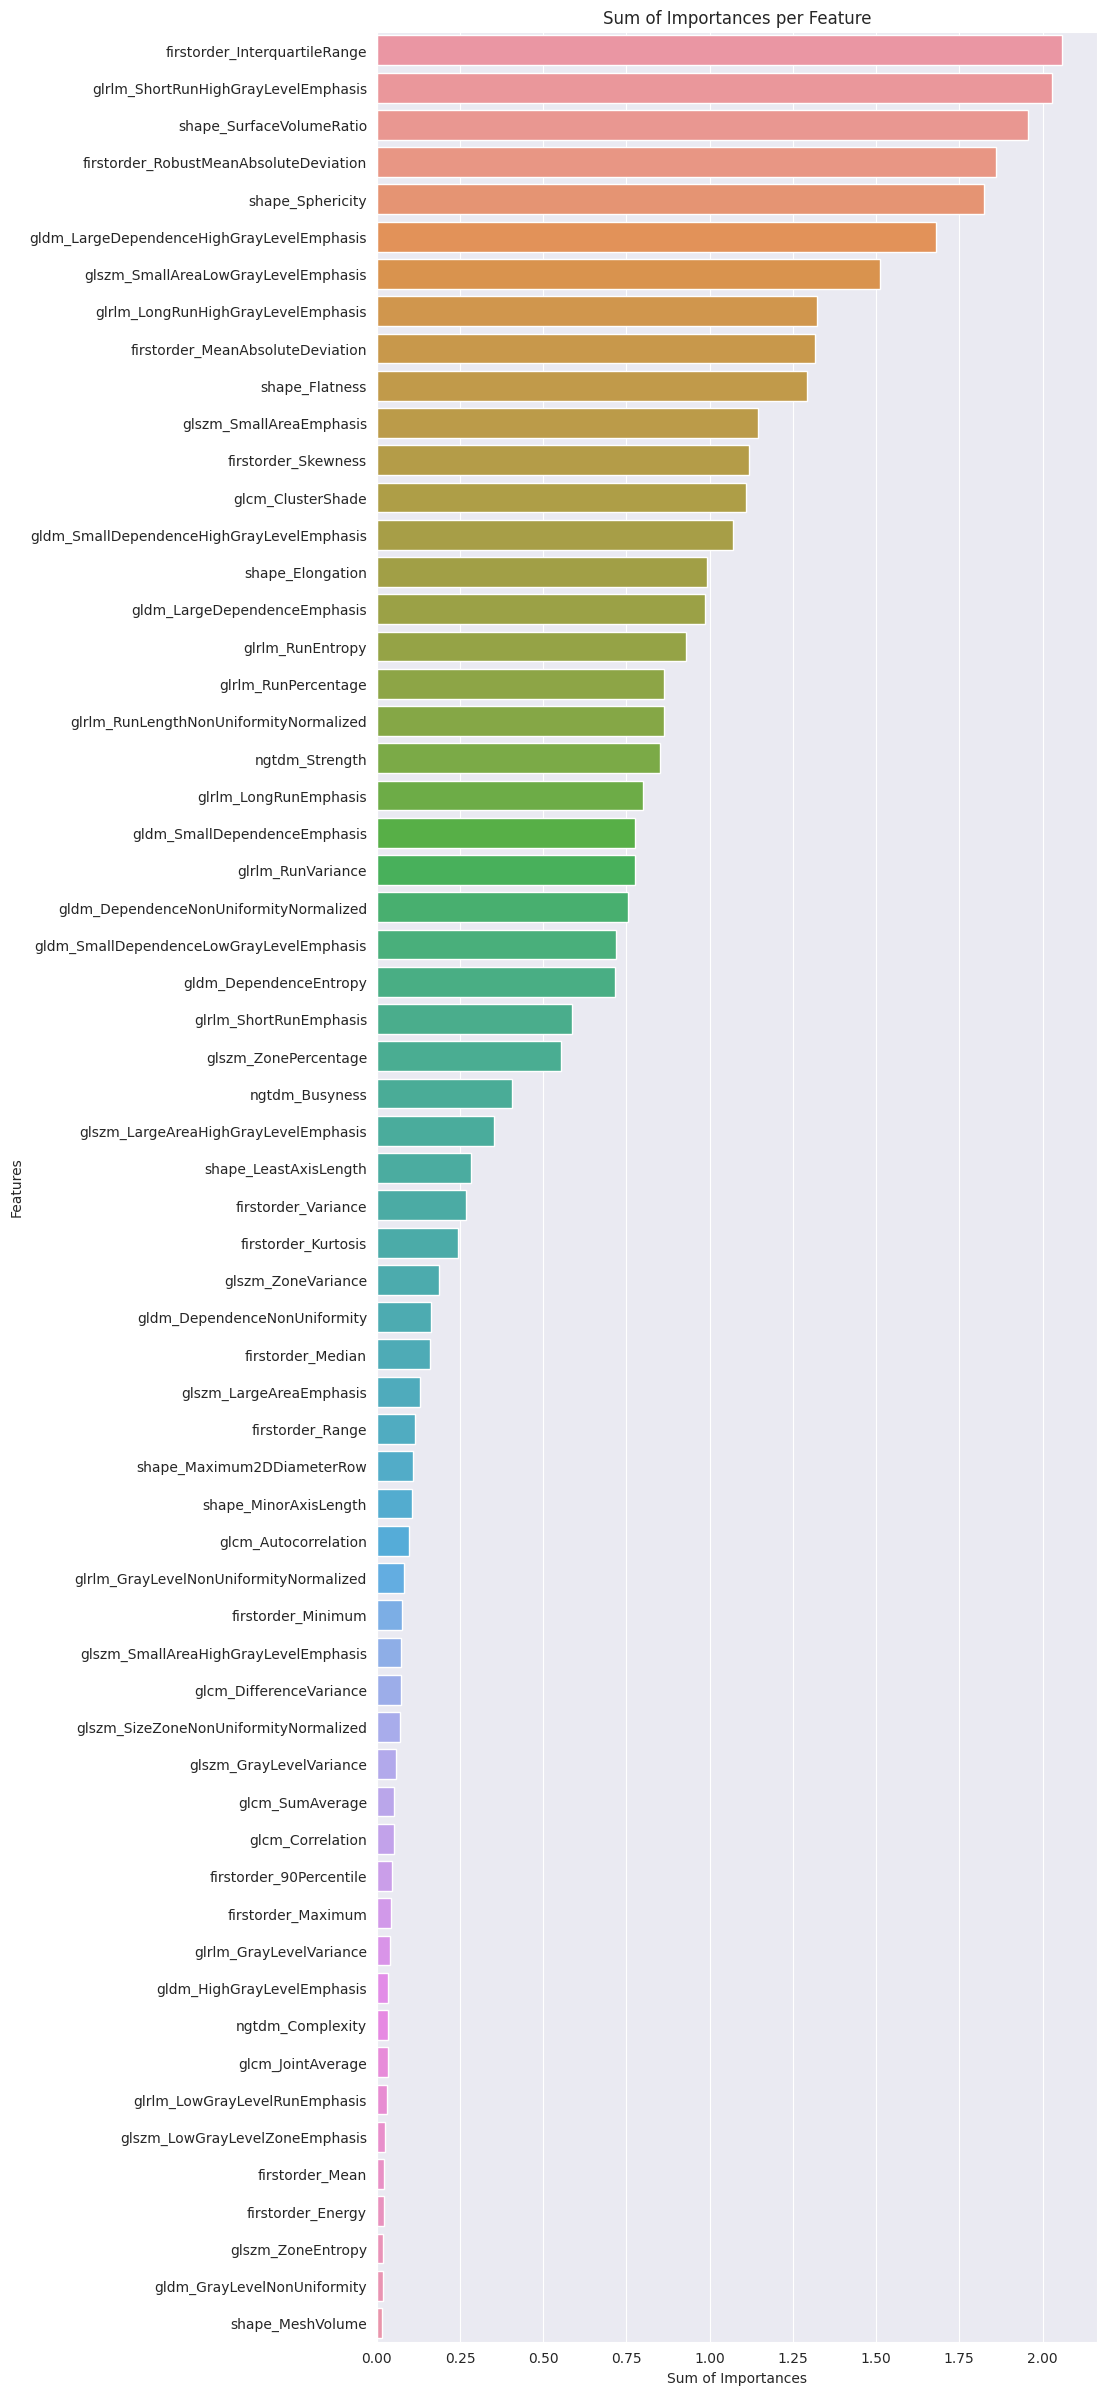

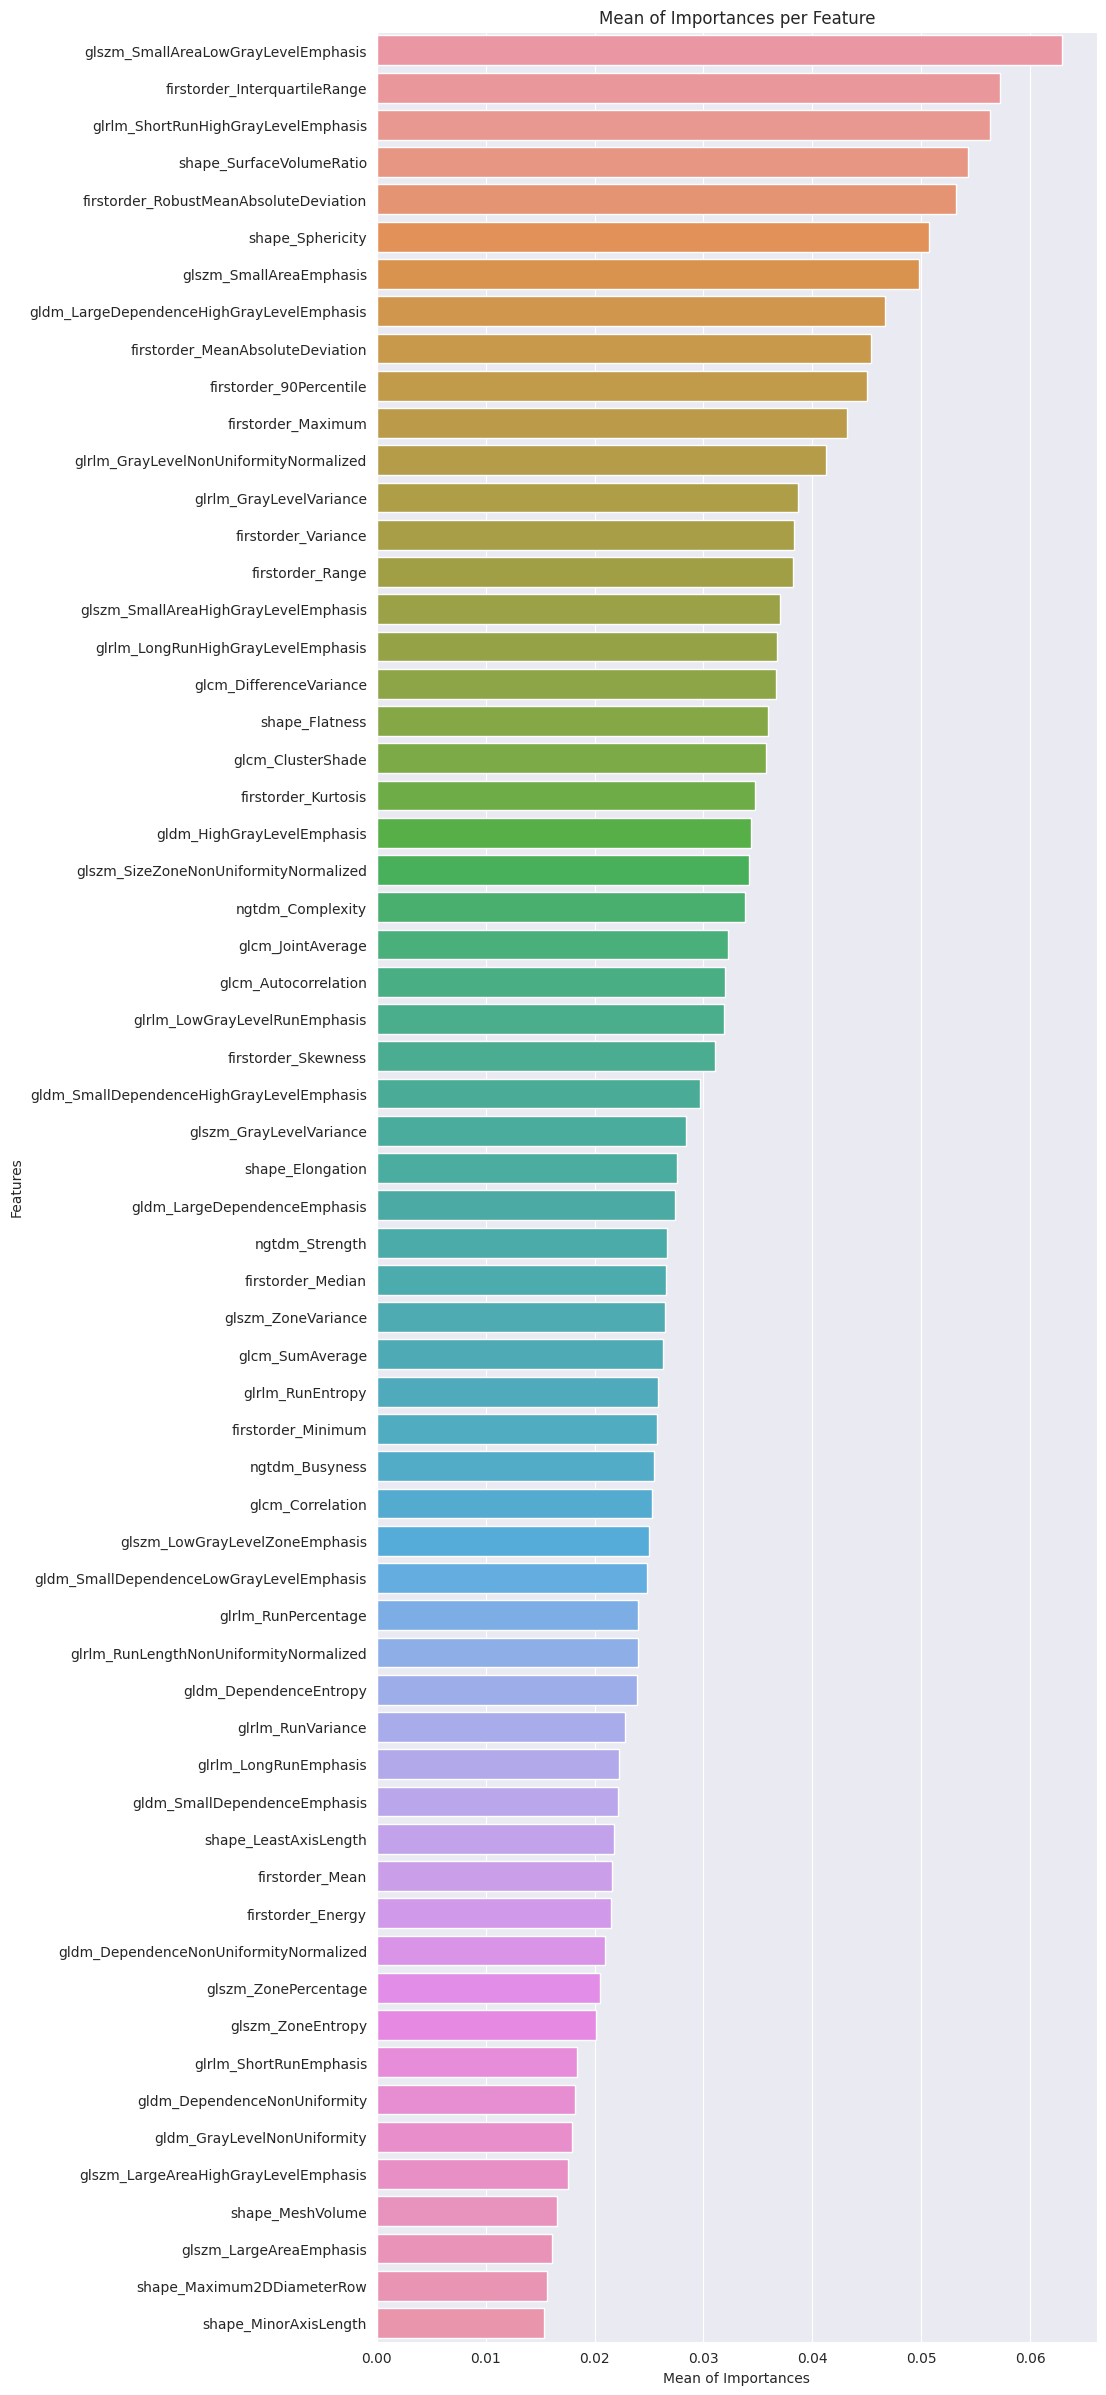

In [42]:

# Calculate the sum of importances per feature
feature_importance_sum = {}
for features, importance in best_features_RF:
    if features in feature_importance_sum:
        feature_importance_sum[features] += importance
    else:
        feature_importance_sum[features] = importance

# Convert the dictionary to lists for plotting
features = list(feature_importance_sum.keys())
importance_sum = list(feature_importance_sum.values())

# Sort the lists in descending order of importance_sum
sorted_indices = sorted(range(len(importance_sum)), key=lambda k: importance_sum[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_sum_sorted = [importance_sum[i] for i in sorted_indices]

# Plot the sum of importances per feature
plt.figure(figsize=(12, 30))
sns.barplot(x=importance_sum_sorted, y=features_sorted)
plt.xlabel('Sum of Importances')
plt.ylabel('Features')
plt.title('Sum of Importances per Feature')
plt.subplots_adjust(left=0.3)
plt.show()

feature_importance_mean = {}
feature_importance_sd = {}
feature_importance_ci = {}

for features, importance in best_features_RF:
    if features in feature_importance_mean:
        feature_importance_mean[features].append(importance)
    else:
        feature_importance_mean[features] = [importance]

feature_importance_mean_ = {feature: np.mean(importances) for feature, importances in feature_importance_mean.items()}
feature_importance_sd = {feature: np.std(importances) for feature, importances in feature_importance_mean.items()}

# Convert the dictionary to lists for plotting
features = list(feature_importance_mean_.keys())
importance_mean = list(feature_importance_mean_.values())

# Sort the lists in descending order of importance_mean
sorted_indices = sorted(range(len(importance_mean)), key=lambda k: importance_mean[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_mean_sorted = [importance_mean[i] for i in sorted_indices]

# Plot the mean of importances per feature
plt.figure(figsize=(12, 30))
sns.barplot(x=importance_mean_sorted, y=features_sorted)
plt.xlabel('Mean of Importances')
plt.ylabel('Features')
plt.title('Mean of Importances per Feature')

# Adjust the position of the figure
plt.subplots_adjust(left=0.3)

plt.show()

In [43]:

p_value_sum = {}
p_value_mean = {}
p_value_sd = {}

for p_value_dict in p_value:
    for feature, value in p_value_dict.items():
        if feature in p_value_sum:
            p_value_sum[feature] += value
        else:
            p_value_sum[feature] = value

# Calculate the mean and standard deviation of p-values per feature
for feature in p_value_sum:
    p_values_per_feature = [p_value_dict[feature] for p_value_dict in p_value if feature in p_value_dict]
    p_value_mean[feature] = np.mean(p_values_per_feature)
    p_value_sd[feature] = np.std(p_values_per_feature)

print('p_value_mean', p_value_mean)

p_value_mean {'shape_Sphericity': 1.6989878998720047e-08, 'shape_LeastAxisLength': 0.0009473928260151955, 'firstorder_Median': 0.2322503151071418, 'shape_SurfaceVolumeRatio': 1.2641548606147338e-08, 'shape_Flatness': 2.4351297447469278e-05, 'glrlm_ShortRunHighGrayLevelEmphasis': 2.868037669812981e-06, 'gldm_LargeDependenceHighGrayLevelEmphasis': 7.1712495345269785e-06, 'shape_Elongation': 5.3046220023814455e-05, 'glrlm_LongRunHighGrayLevelEmphasis': 0.00012742435203988623, 'firstorder_Skewness': 0.013945919770663666, 'glrlm_RunEntropy': 4.9185602608819765e-06, 'gldm_LargeDependenceEmphasis': 2.796487864389888e-06, 'glrlm_RunPercentage': 6.281361669995924e-06, 'glcm_ClusterShade': 0.06762553741539197, 'glrlm_RunLengthNonUniformityNormalized': 1.2648778291153216e-05, 'firstorder_InterquartileRange': 0.05238467222821548, 'glrlm_LongRunEmphasis': 0.00022815667832039787, 'gldm_SmallDependenceEmphasis': 0.0005265476292998026, 'glrlm_ShortRunEmphasis': 0.0003258759850041522, 'gldm_DependenceN

In [44]:
print('p_value_sd', p_value_sd)

p_value_sd {'shape_Sphericity': 4.711554714493575e-08, 'shape_LeastAxisLength': 0.001682518342507035, 'firstorder_Median': 0.08222821531204479, 'shape_SurfaceVolumeRatio': 2.8073867336962688e-08, 'shape_Flatness': 5.777083728394784e-05, 'glrlm_ShortRunHighGrayLevelEmphasis': 4.995900444062914e-06, 'gldm_LargeDependenceHighGrayLevelEmphasis': 1.3329613007372974e-05, 'shape_Elongation': 0.000108500659256053, 'glrlm_LongRunHighGrayLevelEmphasis': 0.0004881755387030806, 'firstorder_Skewness': 0.011733970969218596, 'glrlm_RunEntropy': 1.0781450743137927e-05, 'gldm_LargeDependenceEmphasis': 4.511456376294803e-06, 'glrlm_RunPercentage': 9.643788346569239e-06, 'glcm_ClusterShade': 0.05005562553235243, 'glrlm_RunLengthNonUniformityNormalized': 2.0221520851862862e-05, 'firstorder_InterquartileRange': 0.05308824191350143, 'glrlm_LongRunEmphasis': 0.0007745574363085473, 'gldm_SmallDependenceEmphasis': 0.0006805702945058541, 'glrlm_ShortRunEmphasis': 0.0004463142273096484, 'gldm_DependenceNonUnifor

In [45]:
print('p_value_sum', p_value_sum)

p_value_sum {'shape_Sphericity': 6.116356439539216e-07, 'shape_LeastAxisLength': 0.012316106738197542, 'firstorder_Median': 1.393501890642851, 'shape_SurfaceVolumeRatio': 4.5509574982130425e-07, 'shape_Flatness': 0.0008766467081088941, 'glrlm_ShortRunHighGrayLevelEmphasis': 0.00010324935611326732, 'gldm_LargeDependenceHighGrayLevelEmphasis': 0.00025816498324297127, 'shape_Elongation': 0.00190966392085732, 'glrlm_LongRunHighGrayLevelEmphasis': 0.0045872766734359055, 'firstorder_Skewness': 0.5020531117438919, 'glrlm_RunEntropy': 0.00017706816939175115, 'gldm_LargeDependenceEmphasis': 0.000100673563118036, 'glrlm_RunPercentage': 0.0002261290201198533, 'glcm_ClusterShade': 2.0963916598771513, 'glrlm_RunLengthNonUniformityNormalized': 0.00045535601848151593, 'firstorder_InterquartileRange': 1.8858482002157575, 'glrlm_LongRunEmphasis': 0.008213640419534323, 'gldm_SmallDependenceEmphasis': 0.018429167025493094, 'glrlm_ShortRunEmphasis': 0.010428031520132866, 'gldm_DependenceNonUniformityNorma

## f 50

In [46]:
# Store the scores and metrics
scores_rf = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
scores_svc = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI':[], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
best_features_RF = []
for name, pipeline in pipelines.items():
    # Initialize lists to store scores for each fold
    fold_acc = []
    fold_auc_tot = []
    fold_auc_class = []
    sensi = []
    speci = []
    features = []
    p_value = []
    feat = []
    value = []
    for train_index, test_index in cv_outer.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_normed = scaler.fit_transform(X_train)
        X_test_normed = scaler.transform(X_test)

        X_train_scal = pd.DataFrame(X_train_normed, columns=X_train.columns, index=X_train.index)
        X_test_scal = pd.DataFrame(X_test_normed, columns=X_test.columns, index=X_test.index)

        #select the best 15 features
        selected_feature_names = mrmr_classif(X_train_scal, y_train, K=50)
        X_train_new = X_train_scal[selected_feature_names]
        X_test_new = X_test_scal[selected_feature_names]
        f_scores, p_values = f_classif(X_train_new, y_train)
        feature_p_values = dict(zip(selected_feature_names, p_values))
        p_value.append(feature_p_values)

        cv_inner = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=seed)
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_inner, scoring='roc_auc_ovr', error_score="raise")
        grid_search.fit(X_train_new, y_train)
        clf = grid_search.best_estimator_
        print(clf)
        clf.fit(X_train_new, y_train)
        y_pred = clf.predict(X_test_new)
        accuracy = accuracy_score(y_test, y_pred)
        num_classes = len(np.unique(y_test))
        cm = confusion_matrix(y_test, y_pred)
        specificity = calculate_specificity(cm)
        sensitivity = calculate_sensitivity(cm)
        # Print the results

        accuracy = accuracy_score(y_test, y_pred)
        fold_acc.append(accuracy)

        # Calculate AUC score
        auc_tot = multiclass_roc_auc_score(y_test, y_pred)
        fold_auc_tot.append(auc_tot)

        auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
        fold_auc_class.append(auc_class)

        speci.append(specificity)
        sensi.append(sensitivity)

        print('Auc Score', multiclass_roc_auc_score(y_test, y_pred))
        print('Auc Score OvR', class_vs_rest_roc_auc_score(y_test, y_pred))

        if name == 'rf':
            params_rf = grid_search.best_estimator_
            feature_importance = clf.named_steps['clf'].feature_importances_
            for featureses, importance in zip(selected_feature_names, feature_importance):
                best_features_RF.append((featureses, importance))
        else:
            continue
    # Calculate average scores across folds
    if name == 'rf':
        #acc
        avg_acc = np.mean(fold_acc)
        scores_rf['acc'].append(avg_acc)
        scores_rf['acc'] = scores_rf['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_rf['CI_acc'].append(ci)
        scores_rf['SD_acc'].append(np.std(fold_acc))

        #auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_rf['auc_tot'].append(avg_auc_tot)
        scores_rf['auc_tot'] = scores_rf['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_rf['CI_auc_tot'].append(ci)
        scores_rf['SD_auc_tot'].append(np.std(fold_acc))

        #auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['CI_auc_class'].append(CI_auc_class)

        #sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Sen_CI'].append(CI_sen_class)

        #specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Spe_mean'].append(avg_speci_class)
        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Spe_CI'].append(CI_spe_class)

    elif name == 'svc':
        # acc
        avg_acc = np.mean(fold_acc)
        scores_svc['acc'].append(avg_acc)
        scores_svc['acc'] = scores_svc['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_svc['CI_acc'].append(ci)
        scores_svc['SD_acc'].append(np.std(fold_acc))

        # auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_svc['auc_tot'].append(avg_auc_tot)
        scores_svc['auc_tot'] = scores_svc['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_svc['CI_auc_tot'].append(ci)
        scores_svc['SD_auc_tot'].append(np.std(fold_acc))

        # auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['CI_auc_class'].append(CI_auc_class)

        # sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Sen_CI'].append(CI_sen_class)

        # specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Spe_mean'].append(avg_speci_class)

        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Spe_CI'].append(CI_spe_class)


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.7020814856592826
Auc Score OvR {0: 0.7056277056277057, 1: 0.6232943469785575, 2: 0.7773224043715847}


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5901015267926398
Auc Score OvR {0: 0.5811688311688311, 1: 0.47807017543859653, 2: 0.7110655737704918}


100%|██████████| 50/50 [00:14<00:00,  3.42it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6810944296793354
Auc Score OvR {0: 0.7132034632034633, 1: 0.6858490566037737, 2: 0.6442307692307692}


100%|██████████| 50/50 [00:15<00:00,  3.19it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6009766439011722
Auc Score OvR {0: 0.514069264069264, 1: 0.5792452830188679, 2: 0.7096153846153845}


100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6970305899551184
Auc Score OvR {0: 0.8073593073593074, 1: 0.6042452830188679, 2: 0.6794871794871796}


100%|██████████| 50/50 [00:15<00:00,  3.21it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6756133114603919
Auc Score OvR {0: 0.7748756218905474, 1: 0.550682261208577, 2: 0.7012820512820512}


100%|██████████| 50/50 [00:14<00:00,  3.39it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6216141999863599
Auc Score OvR {0: 0.514069264069264, 1: 0.6062378167641325, 2: 0.7445355191256832}


100%|██████████| 50/50 [00:14<00:00,  3.42it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.6796347965459267
Auc Score OvR {0: 0.6753246753246754, 1: 0.5862573099415204, 2: 0.7773224043715847}


100%|██████████| 50/50 [00:14<00:00,  3.52it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.6574207762887009
Auc Score OvR {0: 0.7694805194805195, 1: 0.6136792452830188, 2: 0.5891025641025641}


100%|██████████| 50/50 [00:14<00:00,  3.45it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6368013537824858
Auc Score OvR {0: 0.7662337662337663, 1: 0.5448113207547169, 2: 0.5993589743589743}


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6783408415483887
Auc Score OvR {0: 0.7132034632034633, 1: 0.5820754716981132, 2: 0.7397435897435898}


100%|██████████| 50/50 [00:15<00:00,  3.31it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6737446184880068
Auc Score OvR {0: 0.7300995024875623, 1: 0.6033138401559455, 2: 0.6878205128205128}


100%|██████████| 50/50 [00:15<00:00,  3.27it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6412160244127458
Auc Score OvR {0: 0.6374458874458875, 1: 0.5833333333333334, 2: 0.7028688524590165}


100%|██████████| 50/50 [00:15<00:00,  3.19it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5907549480313358
Auc Score OvR {0: 0.5854978354978355, 1: 0.5009746588693956, 2: 0.6857923497267759}


100%|██████████| 50/50 [00:16<00:00,  3.04it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.4962600816374401
Auc Score OvR {0: 0.39718614718614714, 1: 0.4287735849056604, 2: 0.6628205128205128}


100%|██████████| 50/50 [00:15<00:00,  3.33it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.58949080269835
Auc Score OvR {0: 0.7056277056277057, 1: 0.5320754716981132, 2: 0.5307692307692309}


100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6875512851927944
Auc Score OvR {0: 0.7099567099567099, 1: 0.6514150943396225, 2: 0.7012820512820512}


100%|██████████| 50/50 [00:16<00:00,  3.04it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5545216636863665
Auc Score OvR {0: 0.47263681592039797, 1: 0.5165692007797271, 2: 0.6743589743589744}


100%|██████████| 50/50 [00:14<00:00,  3.40it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.6699209074460728
Auc Score OvR {0: 0.6493506493506493, 1: 0.6247563352826511, 2: 0.7356557377049181}


100%|██████████| 50/50 [00:15<00:00,  3.31it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.6209932362506421
Auc Score OvR {0: 0.5367965367965367, 1: 0.6062378167641325, 2: 0.7199453551912569}


100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6190234294007878
Auc Score OvR {0: 0.6904761904761906, 1: 0.5037735849056604, 2: 0.6628205128205128}


100%|██████████| 50/50 [00:15<00:00,  3.21it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6030473719152964
Auc Score OvR {0: 0.5627705627705628, 1: 0.5886792452830188, 2: 0.6576923076923077}


100%|██████████| 50/50 [00:14<00:00,  3.49it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.67239458654553
Auc Score OvR {0: 0.7359307359307359, 1: 0.5415094339622641, 2: 0.7397435897435898}


100%|██████████| 50/50 [00:15<00:00,  3.13it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6120764821864585
Auc Score OvR {0: 0.6156716417910447, 1: 0.5628654970760234, 2: 0.6576923076923077}


100%|██████████| 50/50 [00:14<00:00,  3.35it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.647234530826708
Auc Score OvR {0: 0.6525974025974026, 1: 0.6033138401559455, 2: 0.6857923497267759}


100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6216213416745485
Auc Score OvR {0: 0.4913419913419913, 1: 0.5955165692007798, 2: 0.7780054644808744}


100%|██████████| 50/50 [00:15<00:00,  3.14it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6367585768529165
Auc Score OvR {0: 0.577922077922078, 1: 0.6009433962264151, 2: 0.7314102564102565}


100%|██████████| 50/50 [00:15<00:00,  3.13it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5867474768418165
Auc Score OvR {0: 0.6753246753246754, 1: 0.5509433962264151, 2: 0.533974358974359}


100%|██████████| 50/50 [00:17<00:00,  2.86it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6659748532390042
Auc Score OvR {0: 0.672077922077922, 1: 0.5976415094339622, 2: 0.7282051282051282}


100%|██████████| 50/50 [00:16<00:00,  3.03it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.5769909636104975
Auc Score OvR {0: 0.6766169154228855, 1: 0.4902534113060429, 2: 0.5641025641025642}


100%|██████████| 50/50 [00:17<00:00,  2.91it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.5725859053440302
Auc Score OvR {0: 0.461038961038961, 1: 0.5955165692007798, 2: 0.6612021857923498}


100%|██████████| 50/50 [00:16<00:00,  3.04it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6414554698276297
Auc Score OvR {0: 0.6569264069264069, 1: 0.6062378167641325, 2: 0.6612021857923498}


100%|██████████| 50/50 [00:15<00:00,  3.32it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6533352915428389
Auc Score OvR {0: 0.7619047619047621, 1: 0.5570754716981132, 2: 0.6410256410256411}


100%|██████████| 50/50 [00:15<00:00,  3.33it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.7076766524879732
Auc Score OvR {0: 0.7435064935064934, 1: 0.5981132075471699, 2: 0.7814102564102565}


100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6897789317600638
Auc Score OvR {0: 0.6796536796536796, 1: 0.619811320754717, 2: 0.7698717948717949}


100%|██████████| 50/50 [00:15<00:00,  3.23it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6049586749115422
Auc Score OvR {0: 0.5932835820895523, 1: 0.5087719298245614, 2: 0.7128205128205128}


100%|██████████| 50/50 [00:15<00:00,  3.30it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6734021605318702
Auc Score OvR {0: 0.6904761904761906, 1: 0.5769980506822612, 2: 0.7527322404371586}


100%|██████████| 50/50 [00:15<00:00,  3.19it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6677976299417198
Auc Score OvR {0: 0.6601731601731602, 1: 0.5570175438596492, 2: 0.7862021857923498}


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=10,
                                                            class_weight='balanced',
                                                            max_iter=20000,
                                                            random_state=0)))])
Auc Score 0.6801352211729569
Auc Score OvR {0: 0.7922077922077921, 1: 0.560377358490566, 2: 0.6878205128205128}


100%|██████████| 50/50 [00:15<00:00,  3.23it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5582676233619629
Auc Score OvR {0: 0.461038961038961, 1: 0.500943396226415, 2: 0.7128205128205128}


100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.687567621058187
Auc Score OvR {0: 0.8181818181818181, 1: 0.5349056603773585, 2: 0.7096153846153845}


100%|██████████| 50/50 [00:15<00:00,  3.17it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6322681650974399
Auc Score OvR {0: 0.7823383084577115, 1: 0.5151072124756335, 2: 0.5993589743589743}


100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5689784881976426
Auc Score OvR {0: 0.5324675324675324, 1: 0.5043859649122807, 2: 0.6700819672131147}


100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6668948548442365
Auc Score OvR {0: 0.6937229437229437, 1: 0.5214424951267057, 2: 0.7855191256830601}


100%|██████████| 50/50 [00:15<00:00,  3.18it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=10,
                                                            class_weight='balanced',
                                                            max_iter=20000,
                                                            random_state=0)))])
Auc Score 0.5800597201540597
Auc Score OvR {0: 0.777056277056277, 1: 0.47594339622641507, 2: 0.4871794871794872}


100%|██████████| 50/50 [00:15<00:00,  3.32it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6563150685792196
Auc Score OvR {0: 0.7283549783549784, 1: 0.5726415094339623, 2: 0.667948717948718}


100%|██████████| 50/50 [00:15<00:00,  3.24it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.662072623393378
Auc Score OvR {0: 0.6114718614718614, 1: 0.5882075471698113, 2: 0.7865384615384615}


100%|██████████| 50/50 [00:15<00:00,  3.19it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6507079984691925
Auc Score OvR {0: 0.7226368159203981, 1: 0.5833333333333334, 2: 0.6461538461538461}


100%|██████████| 50/50 [00:15<00:00,  3.33it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6294184569997051
Auc Score OvR {0: 0.6266233766233766, 1: 0.5662768031189084, 2: 0.6953551912568307}


100%|██████████| 50/50 [00:14<00:00,  3.51it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5944360473408503
Auc Score OvR {0: 0.6417748917748918, 1: 0.46393762183235865, 2: 0.6775956284153005}


100%|██████████| 50/50 [00:14<00:00,  3.52it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5070842155747816
Auc Score OvR {0: 0.35173160173160173, 1: 0.43490566037735845, 2: 0.7346153846153846}


100%|██████████| 50/50 [00:14<00:00,  3.39it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=10,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6240977575883236
Auc Score OvR {0: 0.682900432900433, 1: 0.5599056603773584, 2: 0.6294871794871795}


100%|██████████| 50/50 [00:15<00:00,  3.28it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=10,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.712025553063289
Auc Score OvR {0: 0.8712121212121212, 1: 0.5853773584905659, 2: 0.6794871794871796}


100%|██████████| 50/50 [00:14<00:00,  3.53it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6453782780504436
Auc Score OvR {0: 0.6766169154228855, 1: 0.5165692007797271, 2: 0.742948717948718}


100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5888057167536604
Auc Score OvR {0: 0.6677489177489178, 1: 0.4873294346978557, 2: 0.6113387978142077}


100%|██████████| 50/50 [00:15<00:00,  3.27it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.639532038546994
Auc Score OvR {0: 0.682900432900433, 1: 0.5492202729044834, 2: 0.6864754098360656}


100%|██████████| 50/50 [00:14<00:00,  3.46it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6007671573709311
Auc Score OvR {0: 0.7619047619047621, 1: 0.44103773584905664, 2: 0.5993589743589743}


100%|██████████| 50/50 [00:15<00:00,  3.18it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5604391939297599
Auc Score OvR {0: 0.4534632034632034, 1: 0.5599056603773584, 2: 0.667948717948718}


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6251584893094326
Auc Score OvR {0: 0.6493506493506493, 1: 0.5165094339622641, 2: 0.7096153846153845}


100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6827683258620677
Auc Score OvR {0: 0.7450248756218906, 1: 0.5769980506822612, 2: 0.7262820512820513}


100%|██████████| 50/50 [00:15<00:00,  3.28it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6378224947753277
Auc Score OvR {0: 0.7316017316017316, 1: 0.5199805068226121, 2: 0.6618852459016393}


100%|██████████| 50/50 [00:15<00:00,  3.26it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6380762235665889
Auc Score OvR {0: 0.7056277056277057, 1: 0.5214424951267057, 2: 0.6871584699453552}


100%|██████████| 50/50 [00:14<00:00,  3.38it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.645365954799917
Auc Score OvR {0: 0.6904761904761906, 1: 0.5693396226415094, 2: 0.6762820512820512}


100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5893021025096497
Auc Score OvR {0: 0.6114718614718614, 1: 0.5070754716981132, 2: 0.6493589743589744}


100%|██████████| 50/50 [00:15<00:00,  3.24it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.66485584645962
Auc Score OvR {0: 0.6753246753246754, 1: 0.5660377358490566, 2: 0.7532051282051281}


100%|██████████| 50/50 [00:18<00:00,  2.74it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6531371109663856
Auc Score OvR {0: 0.6156716417910447, 1: 0.5706627680311891, 2: 0.7730769230769231}


100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.5691246939449413
Auc Score OvR {0: 0.5357142857142857, 1: 0.4858674463937621, 2: 0.6857923497267759}


100%|██████████| 50/50 [00:15<00:00,  3.28it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6626816565341156
Auc Score OvR {0: 0.6645021645021645, 1: 0.6111111111111112, 2: 0.712431693989071}


100%|██████████| 50/50 [00:17<00:00,  2.94it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6083934409406108
Auc Score OvR {0: 0.8106060606060606, 1: 0.47547169811320755, 2: 0.5391025641025642}


100%|██████████| 50/50 [00:14<00:00,  3.36it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6348742452516039
Auc Score OvR {0: 0.682900432900433, 1: 0.5037735849056604, 2: 0.717948717948718}


100%|██████████| 50/50 [00:15<00:00,  3.23it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6987770091543677
Auc Score OvR {0: 0.7694805194805195, 1: 0.6037735849056604, 2: 0.7230769230769232}


100%|██████████| 50/50 [00:15<00:00,  3.28it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6257176779172066
Auc Score OvR {0: 0.5634328358208955, 1: 0.5073099415204678, 2: 0.8064102564102564}


In [47]:
X_train_new

shape_Sphericity  shape_LeastAxisLength  firstorder_Median   
subjid   label                                                               
Oslo01   2              1.314494               1.103040          -0.895422  \
Oslo02   4              1.330546               0.025333           0.194825   
         5              1.146262               0.698142           0.424575   
Oslo03   1              1.018226               0.464185          -0.419986   
Oslo04   1             -1.817738               1.131807           0.360631   
...                          ...                    ...                ...   
Stan_323 6             -0.192159              -0.716581          -0.402527   
         17             0.658595               0.244878          -0.326691   
Stan_328 8             -0.506471              -0.485148          -0.390411   
         11            -0.258684              -0.708806          -0.132607   
Stan_338 4             -0.577675              -0.005478          -0.389711   

                shape_Elongation  gldm_LargeDependenceHighGrayLevelEmphasis   
subjid   label                                                                
Oslo01   2              1.124439                                   1.140830  \
Oslo02   4              0.440892                                   0.059638   
         5              1.093340                                   0.518852   
Oslo03   1              1.027545                                   0.471206   
Oslo04   1              0.485291                                   1.026703   
...                          ...                                        ...   
Stan_323 6              0.026149                                  -0.252027   
         17             0.255783                                   0.293865   
Stan_328 8              1.292739                                  -0.377522   
         11            -1.631396                                  -0.044957   
Stan_338 4              0.228327                                   0.870330   

                glrlm_ShortRunHighGrayLevelEmphasis  shape_Flatness   
subjid   label                                                        
Oslo01   2                                -0.430207        1.710028  \
Oslo02   4                                 0.251303        1.331678   
         5                                -1.024897        1.209568   
Oslo03   1                                -0.437435       -0.010841   
Oslo04   1                                -0.242185       -0.552192   
...                                             ...             ...   
Stan_323 6                                 1.113221       -0.038127   
         17                               -0.228332        0.732968   
Stan_328 8                                 0.208916       -0.216028   
         11                                1.420034       -0.793040   
Stan_338 4                                -0.316566       -0.084181   

                shape_SurfaceVolumeRatio  glrlm_LongRunHighGrayLevelEmphasis   
subjid   label                                                                 
Oslo01   2                     -1.384961                            0.593732  \
Oslo02   4                     -0.607491                           -0.301159   
         5                     -1.216928                            0.111319   
Oslo03   1                     -1.291727                            0.087527   
Oslo04   1                     -1.027096                            0.633788   
...                                  ...                                 ...   
Stan_323 6                      1.222421                           -0.474596   
         17                    -0.801191                           -0.199897   
Stan_328 8                      0.245449                           -0.468087   
         11                     1.062328                           -0.404328   
Stan_338 4                     -0.393246                            0.116059   

        

In [48]:
len(selected_feature_names)
X_train_scal[selected_feature_names]

shape_Sphericity  shape_LeastAxisLength  firstorder_Median   
subjid   label                                                               
Oslo01   2              1.314494               1.103040          -0.895422  \
Oslo02   4              1.330546               0.025333           0.194825   
         5              1.146262               0.698142           0.424575   
Oslo03   1              1.018226               0.464185          -0.419986   
Oslo04   1             -1.817738               1.131807           0.360631   
...                          ...                    ...                ...   
Stan_323 6             -0.192159              -0.716581          -0.402527   
         17             0.658595               0.244878          -0.326691   
Stan_328 8             -0.506471              -0.485148          -0.390411   
         11            -0.258684              -0.708806          -0.132607   
Stan_338 4             -0.577675              -0.005478          -0.389711   

                shape_Elongation  gldm_LargeDependenceHighGrayLevelEmphasis   
subjid   label                                                                
Oslo01   2              1.124439                                   1.140830  \
Oslo02   4              0.440892                                   0.059638   
         5              1.093340                                   0.518852   
Oslo03   1              1.027545                                   0.471206   
Oslo04   1              0.485291                                   1.026703   
...                          ...                                        ...   
Stan_323 6              0.026149                                  -0.252027   
         17             0.255783                                   0.293865   
Stan_328 8              1.292739                                  -0.377522   
         11            -1.631396                                  -0.044957   
Stan_338 4              0.228327                                   0.870330   

                glrlm_ShortRunHighGrayLevelEmphasis  shape_Flatness   
subjid   label                                                        
Oslo01   2                                -0.430207        1.710028  \
Oslo02   4                                 0.251303        1.331678   
         5                                -1.024897        1.209568   
Oslo03   1                                -0.437435       -0.010841   
Oslo04   1                                -0.242185       -0.552192   
...                                             ...             ...   
Stan_323 6                                 1.113221       -0.038127   
         17                               -0.228332        0.732968   
Stan_328 8                                 0.208916       -0.216028   
         11                                1.420034       -0.793040   
Stan_338 4                                -0.316566       -0.084181   

                shape_SurfaceVolumeRatio  glrlm_LongRunHighGrayLevelEmphasis   
subjid   label                                                                 
Oslo01   2                     -1.384961                            0.593732  \
Oslo02   4                     -0.607491                           -0.301159   
         5                     -1.216928                            0.111319   
Oslo03   1                     -1.291727                            0.087527   
Oslo04   1                     -1.027096                            0.633788   
...                                  ...                                 ...   
Stan_323 6                      1.222421                           -0.474596   
         17                    -0.801191                           -0.199897   
Stan_328 8                      0.245449                           -0.468087   
         11                     1.062328                           -0.404328   
Stan_338 4                     -0.393246                            0.116059   

        

In [49]:
for name, score in scores_svc.items():
    print('svc', f'{name}: {score}')

for name, score in scores_rf.items():
    print('rf', f'{name}: {score}')

svc acc: 0.3504566210045662
svc SD_acc: [0.049850697627621114]
svc CI_acc: [(0.3333503107124455, 0.36756293129668693)]
svc auc_tot: 0.631180746167012
svc SD_auc_tot: [0.049850697627621114]
svc CI_auc_tot: [(0.6158972042738527, 0.6464642880601713)]
svc auc_class: [{0: 0.6705052479306209, 1: 0.5330867313578611, 2: 0.6899502592125544}]
svc SD_auc_class: [{0: 0.10692628025892204, 1: 0.04469320085723908, 2: 0.06714538850957925}]
svc CI_auc_class: [{0: (0.6338134017672101, 0.7071970940940318), 1: (0.5177502205727363, 0.5484232421429859), 2: (0.6669092606871206, 0.7129912577379881)}]
svc Sen_mean: [{0: 68.32010582010582, 1: 21.55155679788804, 2: 74.21652421652423}]
svc Sen_CI: [{0: (61.58323473782944, 75.0569769023822), 1: (19.31434767078378, 23.7887659249923), 2: (69.92287547222386, 78.5101729608246)}]
svc Sen_SD: [{0: 19.63238813886791, 1: 6.519607900272836, 2: 12.512422703446553}]
svc Spe_mean: [{0: 65.78094376601838, 1: 85.06578947368422, 2: 63.77352762598663}]
svc Spe_CI: [{0: (63.815890

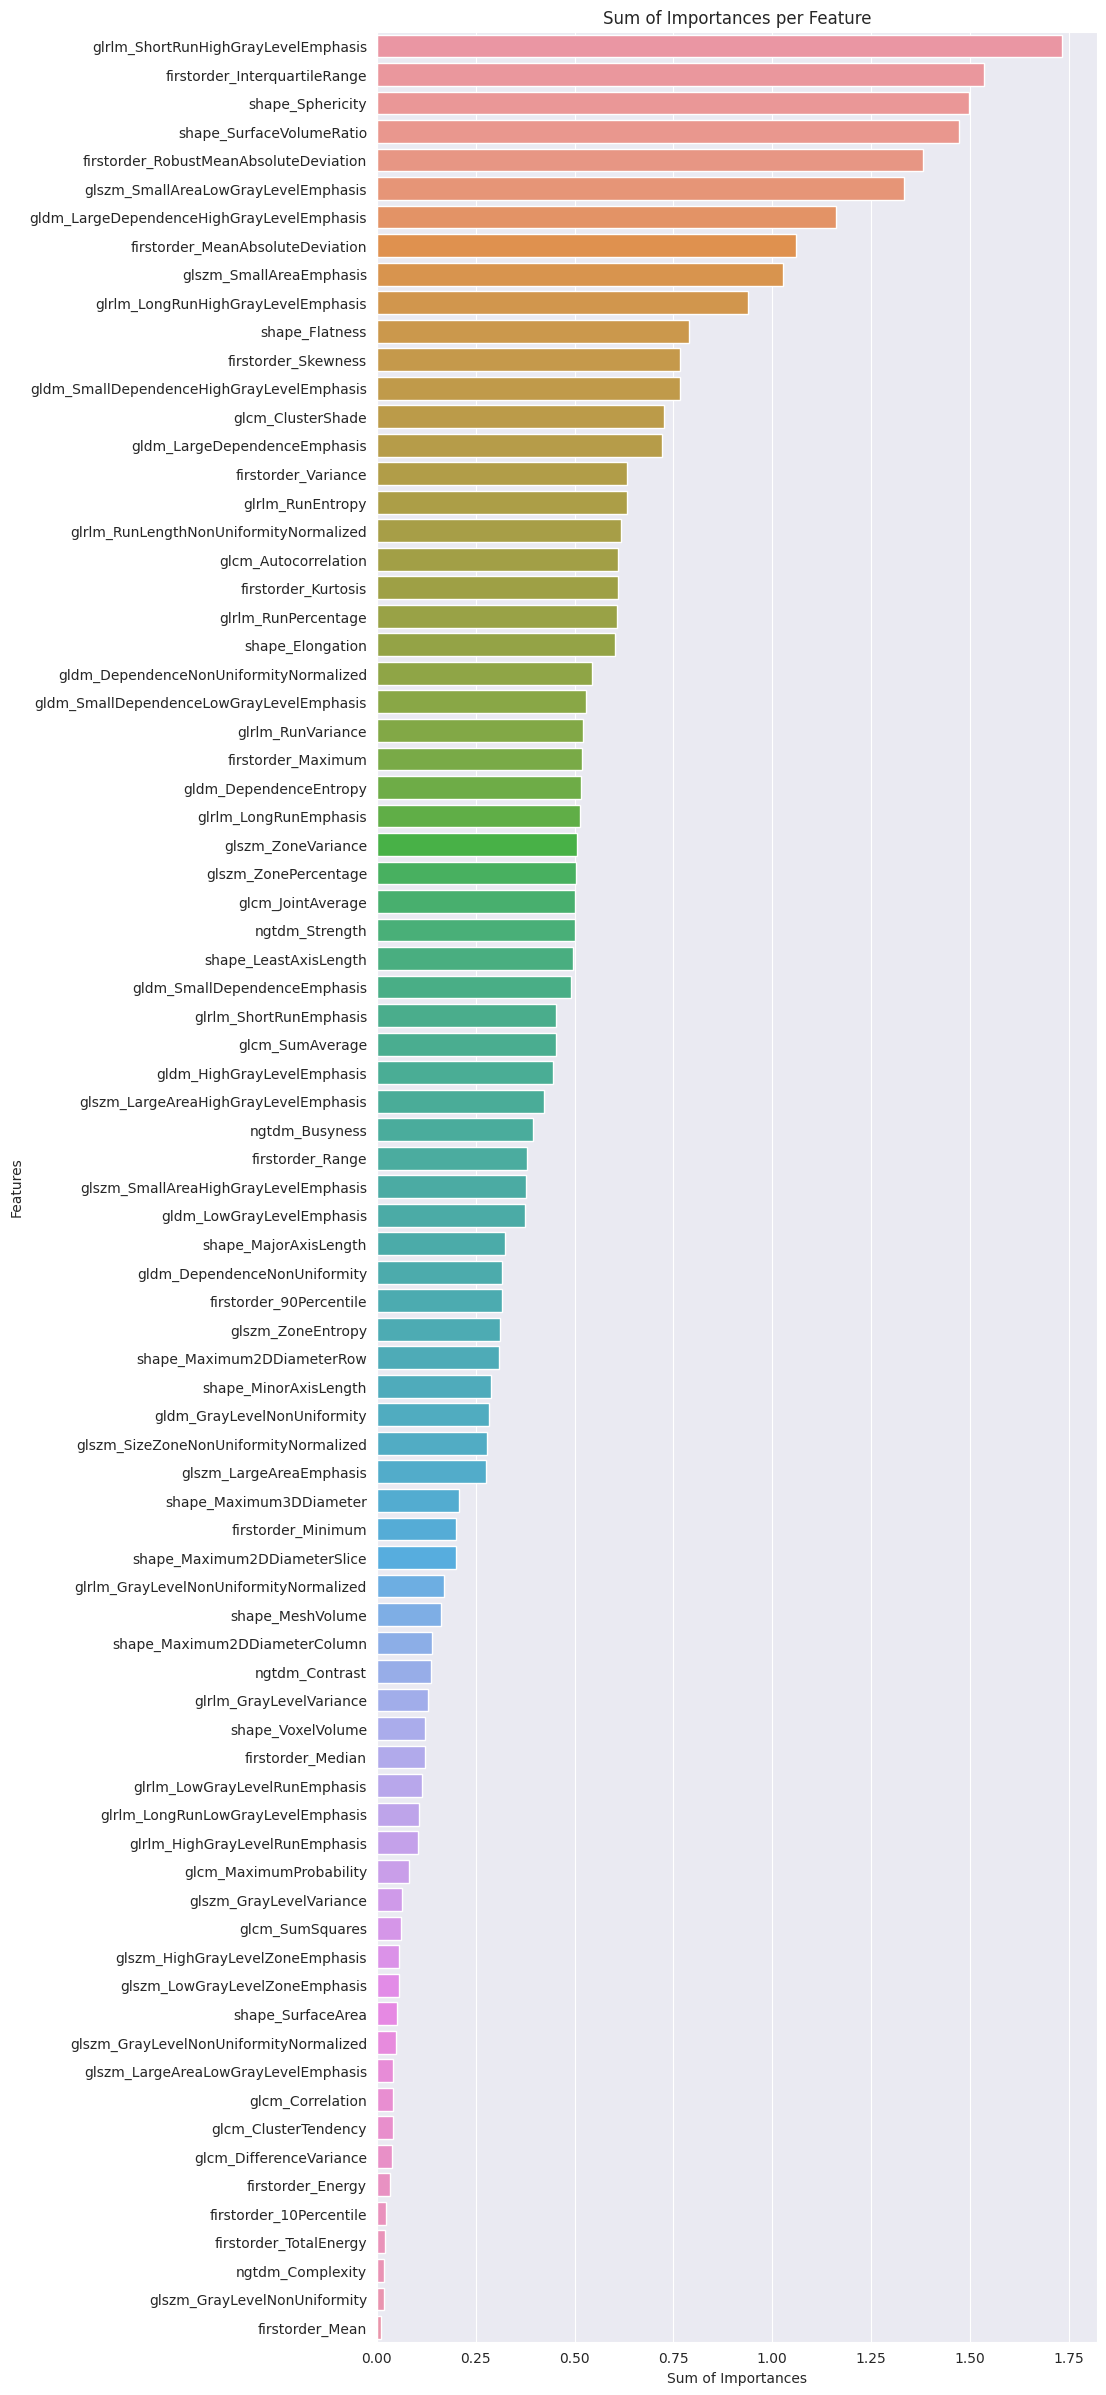

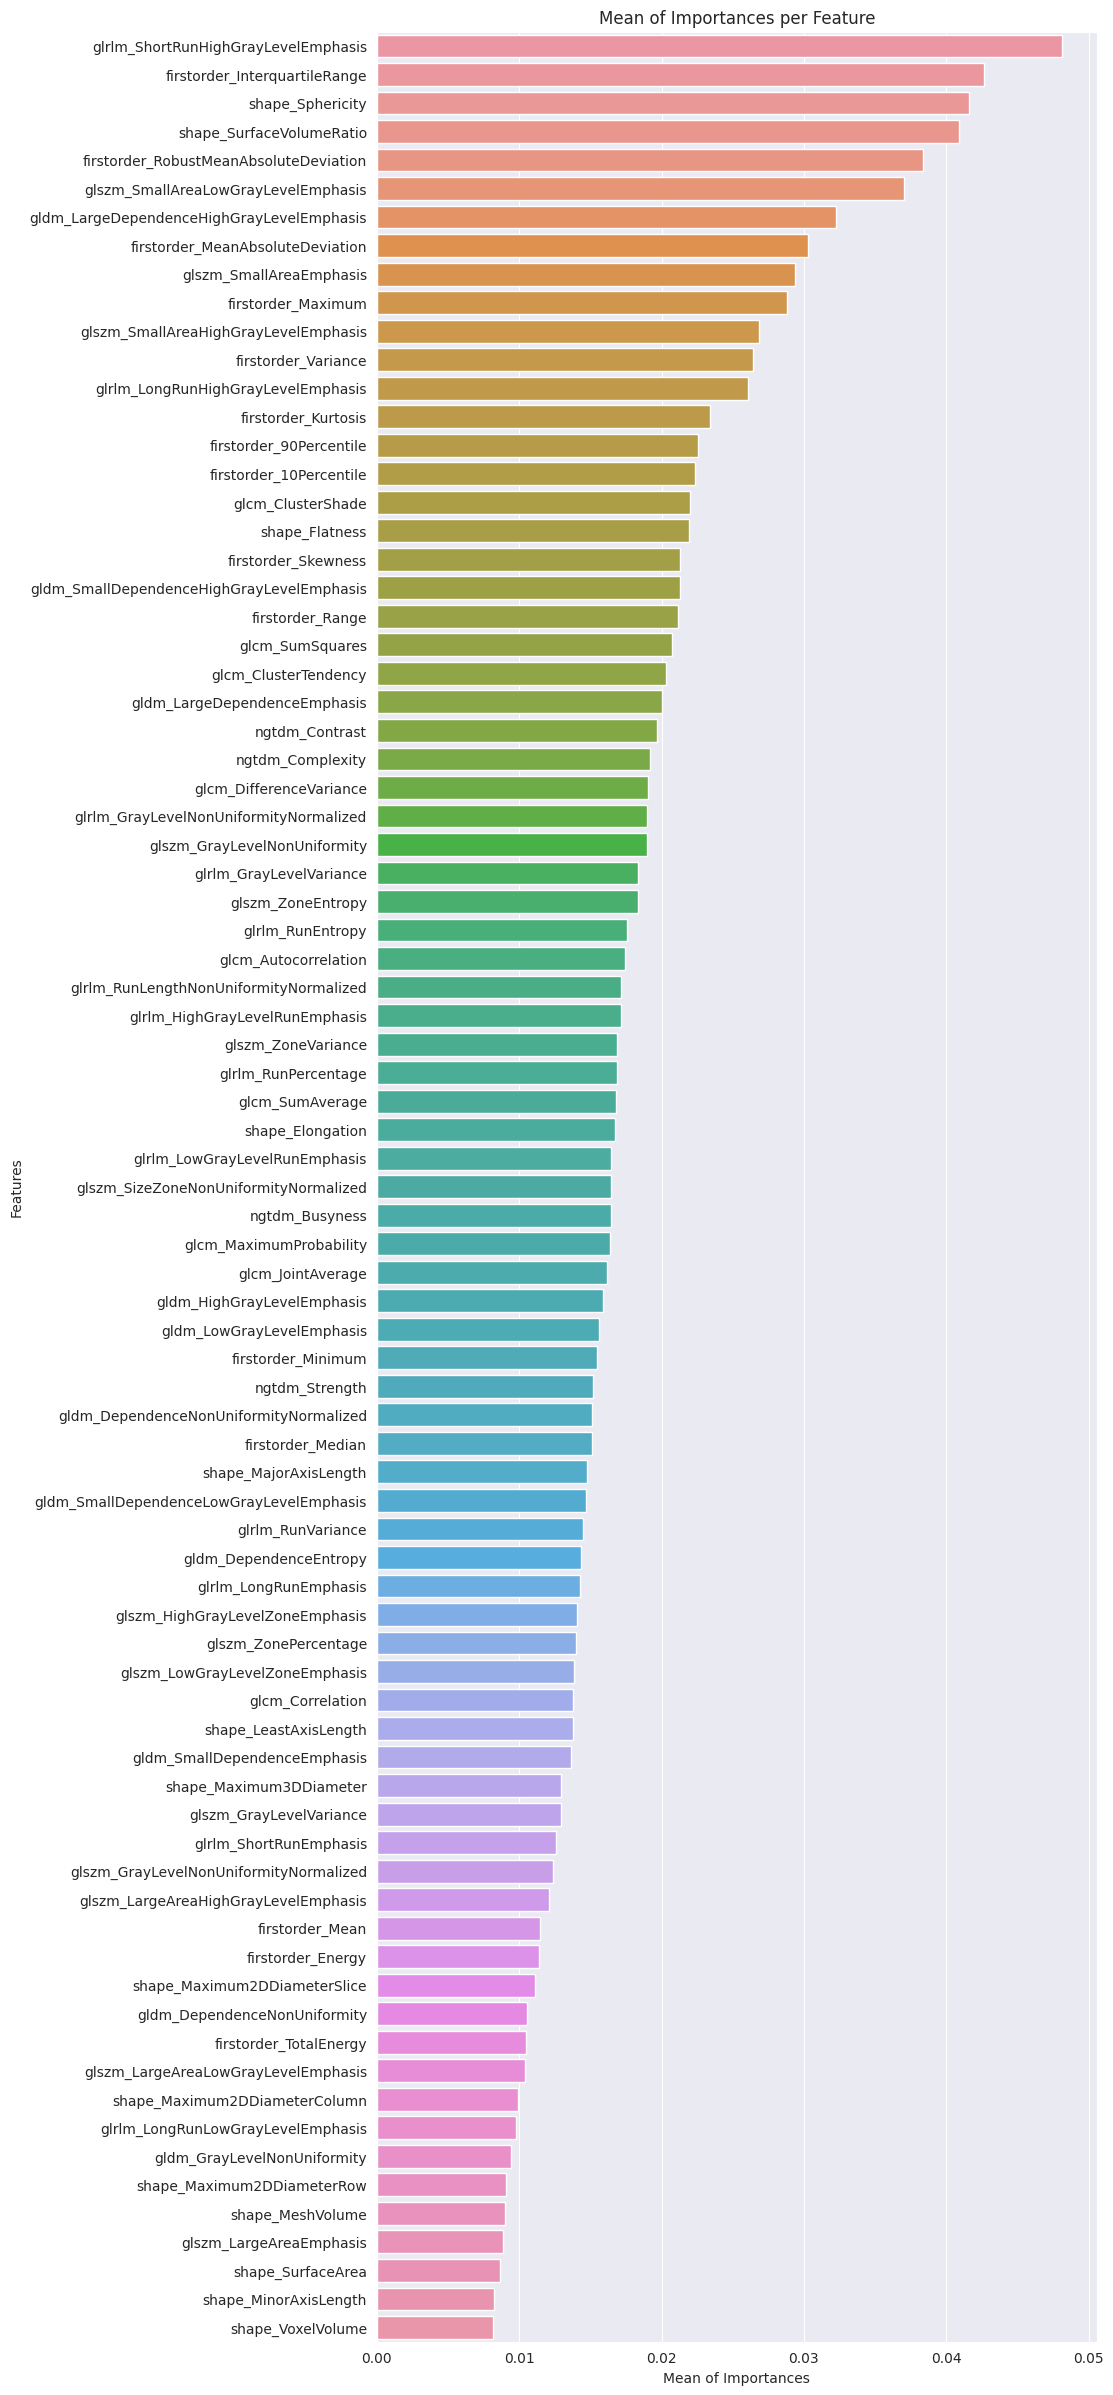

In [50]:

# Calculate the sum of importances per feature
feature_importance_sum = {}
for features, importance in best_features_RF:
    if features in feature_importance_sum:
        feature_importance_sum[features] += importance
    else:
        feature_importance_sum[features] = importance

# Convert the dictionary to lists for plotting
features = list(feature_importance_sum.keys())
importance_sum = list(feature_importance_sum.values())

# Sort the lists in descending order of importance_sum
sorted_indices = sorted(range(len(importance_sum)), key=lambda k: importance_sum[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_sum_sorted = [importance_sum[i] for i in sorted_indices]

# Plot the sum of importances per feature
plt.figure(figsize=(12, 30))
sns.barplot(x=importance_sum_sorted, y=features_sorted)
plt.xlabel('Sum of Importances')
plt.ylabel('Features')
plt.title('Sum of Importances per Feature')
plt.subplots_adjust(left=0.3)
plt.show()

feature_importance_mean = {}
feature_importance_sd = {}
feature_importance_ci = {}

for features, importance in best_features_RF:
    if features in feature_importance_mean:
        feature_importance_mean[features].append(importance)
    else:
        feature_importance_mean[features] = [importance]

feature_importance_mean_ = {feature: np.mean(importances) for feature, importances in feature_importance_mean.items()}
feature_importance_sd = {feature: np.std(importances) for feature, importances in feature_importance_mean.items()}

# Convert the dictionary to lists for plotting
features = list(feature_importance_mean_.keys())
importance_mean = list(feature_importance_mean_.values())

# Sort the lists in descending order of importance_mean
sorted_indices = sorted(range(len(importance_mean)), key=lambda k: importance_mean[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_mean_sorted = [importance_mean[i] for i in sorted_indices]

# Plot the mean of importances per feature
plt.figure(figsize=(12, 30))
sns.barplot(x=importance_mean_sorted, y=features_sorted)
plt.xlabel('Mean of Importances')
plt.ylabel('Features')
plt.title('Mean of Importances per Feature')

# Adjust the position of the figure
plt.subplots_adjust(left=0.3)

In [51]:

plt.show()
p_value_sum = {}
p_value_mean = {}
p_value_sd = {}

for p_value_dict in p_value:
    for feature, value in p_value_dict.items():
        if feature in p_value_sum:
            p_value_sum[feature] += value
        else:
            p_value_sum[feature] = value

# Calculate the mean and standard deviation of p-values per feature
for feature in p_value_sum:
    p_values_per_feature = [p_value_dict[feature] for p_value_dict in p_value if feature in p_value_dict]
    p_value_mean[feature] = np.mean(p_values_per_feature)
    p_value_sd[feature] = np.std(p_values_per_feature)

print('p_value_mean', p_value_mean)

p_value_mean {'shape_Sphericity': 1.6989878998720047e-08, 'shape_LeastAxisLength': 0.0023920191556815987, 'firstorder_Median': 0.20741269252192485, 'shape_SurfaceVolumeRatio': 1.2641548606147338e-08, 'shape_Flatness': 2.4351297447469278e-05, 'glrlm_ShortRunHighGrayLevelEmphasis': 2.868037669812981e-06, 'gldm_LargeDependenceHighGrayLevelEmphasis': 7.1712495345269785e-06, 'shape_Elongation': 5.3046220023814455e-05, 'glrlm_LongRunHighGrayLevelEmphasis': 0.00012742435203988623, 'firstorder_Skewness': 0.013945919770663666, 'glrlm_RunEntropy': 4.9185602608819765e-06, 'gldm_LargeDependenceEmphasis': 2.796487864389888e-06, 'glrlm_RunPercentage': 6.281361669995924e-06, 'glcm_ClusterShade': 0.07465720459176094, 'glrlm_RunLengthNonUniformityNormalized': 1.2648778291153216e-05, 'firstorder_InterquartileRange': 0.05238467222821548, 'glrlm_LongRunEmphasis': 0.00022815667832039787, 'gldm_SmallDependenceEmphasis': 0.0006259386581176366, 'glrlm_ShortRunEmphasis': 0.00040123859168996915, 'gldm_Dependenc

In [52]:
print('p_value_sum', p_value_sum)

p_value_sum {'shape_Sphericity': 6.116356439539216e-07, 'shape_LeastAxisLength': 0.08611268960453754, 'firstorder_Median': 1.6593015401753988, 'shape_SurfaceVolumeRatio': 4.5509574982130425e-07, 'shape_Flatness': 0.0008766467081088941, 'glrlm_ShortRunHighGrayLevelEmphasis': 0.00010324935611326732, 'gldm_LargeDependenceHighGrayLevelEmphasis': 0.00025816498324297127, 'shape_Elongation': 0.00190966392085732, 'glrlm_LongRunHighGrayLevelEmphasis': 0.0045872766734359055, 'firstorder_Skewness': 0.5020531117438919, 'glrlm_RunEntropy': 0.00017706816939175115, 'gldm_LargeDependenceEmphasis': 0.000100673563118036, 'glrlm_RunPercentage': 0.0002261290201198533, 'glcm_ClusterShade': 2.4636877515281115, 'glrlm_RunLengthNonUniformityNormalized': 0.00045535601848151593, 'firstorder_InterquartileRange': 1.8858482002157575, 'glrlm_LongRunEmphasis': 0.008213640419534323, 'gldm_SmallDependenceEmphasis': 0.022533791692234916, 'glrlm_ShortRunEmphasis': 0.014444589300838888, 'gldm_DependenceNonUniformityNorma

In [53]:
print('p_value_sd', p_value_sd)

p_value_sd {'shape_Sphericity': 4.711554714493575e-08, 'shape_LeastAxisLength': 0.0038175948236600287, 'firstorder_Median': 0.0837936750222129, 'shape_SurfaceVolumeRatio': 2.8073867336962688e-08, 'shape_Flatness': 5.777083728394784e-05, 'glrlm_ShortRunHighGrayLevelEmphasis': 4.995900444062914e-06, 'gldm_LargeDependenceHighGrayLevelEmphasis': 1.3329613007372974e-05, 'shape_Elongation': 0.000108500659256053, 'glrlm_LongRunHighGrayLevelEmphasis': 0.0004881755387030806, 'firstorder_Skewness': 0.011733970969218596, 'glrlm_RunEntropy': 1.0781450743137927e-05, 'gldm_LargeDependenceEmphasis': 4.511456376294803e-06, 'glrlm_RunPercentage': 9.643788346569239e-06, 'glcm_ClusterShade': 0.0660428468545733, 'glrlm_RunLengthNonUniformityNormalized': 2.0221520851862862e-05, 'firstorder_InterquartileRange': 0.05308824191350143, 'glrlm_LongRunEmphasis': 0.0007745574363085473, 'gldm_SmallDependenceEmphasis': 0.0008922220066537611, 'glrlm_ShortRunEmphasis': 0.0005138282302660797, 'gldm_DependenceNonUniform